# Stage 0 - Business Understanding

## Background

Companies often face challenges in recruiting quality candidates within budget constraints. In our case, **69% of applicants are ultimately rejected**, which signals either a large volume of unqualified candidates or inefficiencies in the screening process.

Each candidate typically undergoes a **structured interview (~ IDR 320K), a technical skill test (~ IDR 75–225K)**, and a **personality assessment (~ IDR 50–150K)**. When applied to low-fit candidates—who represent 69% of applicants—this leads to wasted HR and tool costs of **approximately IDR 450K–700K per unqualified candidate**. Multiply that by candidate volume, and the financial impact becomes substantial.

Therefore, to address these challenges, our team proposes a **data-driven approach using predictive analytics to improve candidate screening**. By leveraging machine learning, we aim to reduce low-fit recommendations, accelerate hiring decisions, and ultimately reduce costs and risks from poor hiring

## Problem Statement

The recruitment process faces significant cost and time inefficiencies, **with 69% of applicants ultimately identified as low-fit**, despite undergoing structured assessments and interviews. This highlights gaps in both early-stage screening and final hiring decisions. To address this, we propose predictive models that improve the quality of candidate shortlisting and hiring outcomes—ensuring that suitable candidates are prioritized from the start and retained through to successful hires.

## Goal

To enhance the recruitment process using **machine learning models that detect key patterns in candidate success**. These models aim to support more consistent and **objective hiring decisions**, minimize human bias, and streamline candidate evaluation — particularly in the pre- and post-interview stages. Ultimately, we aim to reduce recruitment costs and time-to-hire while ensuring alignment between hires and long-term company goals.

## Objectives

Leverage machine learning to optimize candidate screening and support data-informed decisions throughout recruitment.

**Pre-Interview Model Targets**
- **↑ 113%** increase in the success rate of shortlisting suitable candidates from model recommendations.
- **↓ 70%** reduction in low-fit candidates in shortlist (from 60% to 15%).
- **2.12× lift** in shortlisting rate for model-recommended candidates.

**Post-Interview Model Targets**
- **↑ 184%** increase in the success rate of hires suitable candidates from model recommendations.
- **↓ 88%** reduction in low-fit hires (from 69% to 8%).
- **2.80× lift** in hire conversion rate for model-selected candidates.

# Stage 1 - Data Understanding & EDA & Feature Engineering

## Data Understanding

In [ ]:
# !pip install -q --upgrade gdown

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import gdown, pandas as pd
import warnings
import numpy as np

warnings.filterwarnings("ignore")

url     = f"https://drive.google.com/uc?id=19oxVfnBTnKIl1QDXz_cKs-FmST9mJPnJ"
output  = "recruitment_data.csv"

gdown.download(url, output, quiet=False)

df = pd.read_csv(output)
df.sample(5)

Downloading...
From: https://drive.google.com/uc?id=19oxVfnBTnKIl1QDXz_cKs-FmST9mJPnJ
To: /content/recruitment_data.csv
100%|██████████| 64.0k/64.0k [00:00<00:00, 58.4MB/s]


Age  Gender  EducationLevel  ExperienceYears  PreviousCompanies  \
783    28       0               3                2                  4   
523    45       1               2                2                  2   
12     30       0               3               12                  5   
410    28       1               1               10                  4   
1386   37       0               1                9                  5   

      DistanceFromCompany  InterviewScore  SkillScore  PersonalityScore  \
783             23.887191              45          46                45   
523             45.987154              19          13                27   
12               5.213218              96          46                78   
410             26.697772              64          71                33   
1386             6.312285              42          91                36   

      RecruitmentStrategy  HiringDecision  
783                     2               0  
523                     3               0  
12                      3               1  
410                     2               0  
1386                    3               1

In [ ]:
# Mengubah tipe data fitur2 kategorikal menjadi 'category'
df = df.astype({
    'Gender': 'category',
    'EducationLevel': 'category',
    'RecruitmentStrategy': 'category',
    'HiringDecision': 'category'
})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Age                  1500 non-null   int64   
 1   Gender               1500 non-null   category
 2   EducationLevel       1500 non-null   category
 3   ExperienceYears      1500 non-null   int64   
 4   PreviousCompanies    1500 non-null   int64   
 5   DistanceFromCompany  1500 non-null   float64 
 6   InterviewScore       1500 non-null   int64   
 7   SkillScore           1500 non-null   int64   
 8   PersonalityScore     1500 non-null   int64   
 9   RecruitmentStrategy  1500 non-null   category
 10  HiringDecision       1500 non-null   category
dtypes: category(4), float64(1), int64(6)
memory usage: 88.6 KB


In [ ]:
print(f"\nJumlah nilai duplikat: {df.duplicated().sum()}")
print(f"\nJumlah missing values:\n{df.isna().sum()}")


Jumlah nilai duplikat: 0

Jumlah missing values:
Age                    0
Gender                 0
EducationLevel         0
ExperienceYears        0
PreviousCompanies      0
DistanceFromCompany    0
InterviewScore         0
SkillScore             0
PersonalityScore       0
RecruitmentStrategy    0
HiringDecision         0
dtype: int64


- Jumlah baris: 1500
- Semua kolom tidak memiliki missing values (lengkap)
- Duplikat = 0

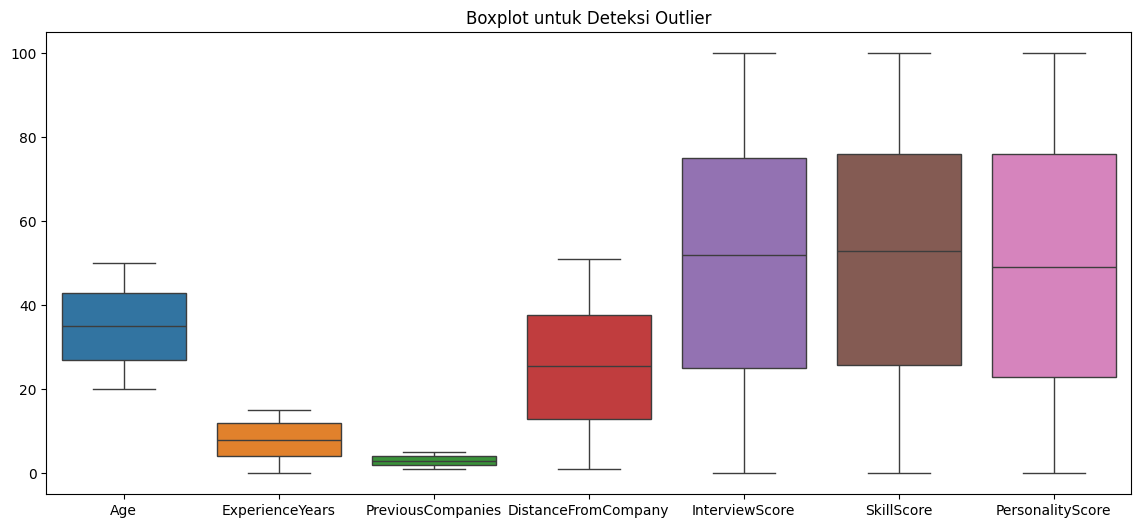

In [ ]:
# kolom numerik
plt.figure(figsize=(14, 6))
sns.boxplot(data=df.select_dtypes(include=['int64', 'float64']))
plt.xticks(rotation=0)
plt.title("Boxplot untuk Deteksi Outlier")
plt.show()

In [ ]:
# Ambil hanya kolom numerik
df_num = df.select_dtypes(include=['int64', 'float64'])

# Menghitung Q1, Q3, dan IQR untuk kolom numerik
Q1 = df_num.quantile(0.25)
Q3 = df_num.quantile(0.75)
IQR = Q3 - Q1

# Menandai outlier
outliers = (df_num < (Q1 - 1.5 * IQR)) | (df_num > (Q3 + 1.5 * IQR))

# Mengambil baris yang mengandung outlier
df_outliers = df[outliers.any(axis=1)]

print(f"Jumlah baris yang mengandung outlier: {df_outliers.shape[0]}")

Jumlah baris yang mengandung outlier: 0


In [ ]:
def iqr_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return series[(series < lower) | (series > upper)]

for col in df_num.columns:
    print(col, "→", len(iqr_outliers(df_num[col])), "outliers")

Age → 0 outliers
ExperienceYears → 0 outliers
PreviousCompanies → 0 outliers
DistanceFromCompany → 0 outliers
InterviewScore → 0 outliers
SkillScore → 0 outliers
PersonalityScore → 0 outliers


## Exploratory Data Analysis

### Target

In [ ]:
df['HiringDecision'].value_counts()

HiringDecision
0    1035
1     465
Name: count, dtype: int64

In [ ]:
df['HiringDecision'] = df['HiringDecision'].map({0: 'Not Hired', 1: 'Hired'})

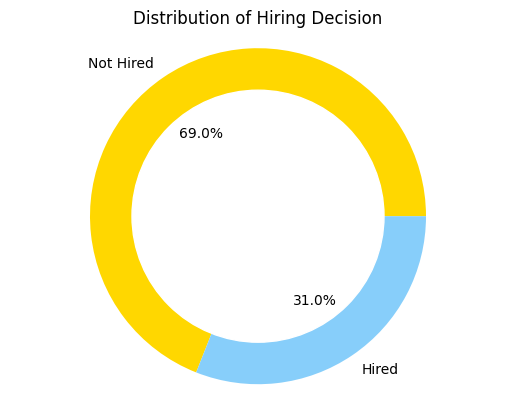

In [ ]:
colors = ['gold','lightskyblue']
Class= df['HiringDecision'].value_counts()
labels=['Not Hired', 'Hired']
fig, ax = plt.subplots()

ax.pie(Class,labels=labels,colors=colors,autopct='%1.1f%%')
circle=plt.Circle((0,0),0.75,color='white')
ax.add_artist(circle)
plt.title('Distribution of Hiring Decision')
ax.axis('equal')
plt.show()

Proporsi target pada dataset ini tergolong tidak seimbang. Mayoritas kandidat memiliki nilai 0 (tidak direkrut / Not Hired) dengan proporsi sebesar 69%, sedangkan kandidat yang direkrut (nilai 1 / Hired) hanya sebesar 31%.

Ketidakseimbangan ini perlu diperhatikan dalam proses pemodelan, karena model dapat terdorong untuk lebih sering memprediksi kelas mayoritas.

### Kolom Numerikal

In [ ]:
variable_num = ['Age', 'ExperienceYears',
       'PreviousCompanies', 'DistanceFromCompany', 'InterviewScore',
       'SkillScore', 'PersonalityScore']

df[variable_num].sample(5)

Age  ExperienceYears  PreviousCompanies  DistanceFromCompany  \
778    31               13                  3            18.476140   
1102   42               12                  5            30.171311   
906    48               12                  5            47.744652   
1488   34                5                  2            18.989471   
1034   33                5                  3             6.094588   

      InterviewScore  SkillScore  PersonalityScore  
778               44          87                 7  
1102              75          41                91  
906                0          60                45  
1488              20          88                24  
1034              56          97                83

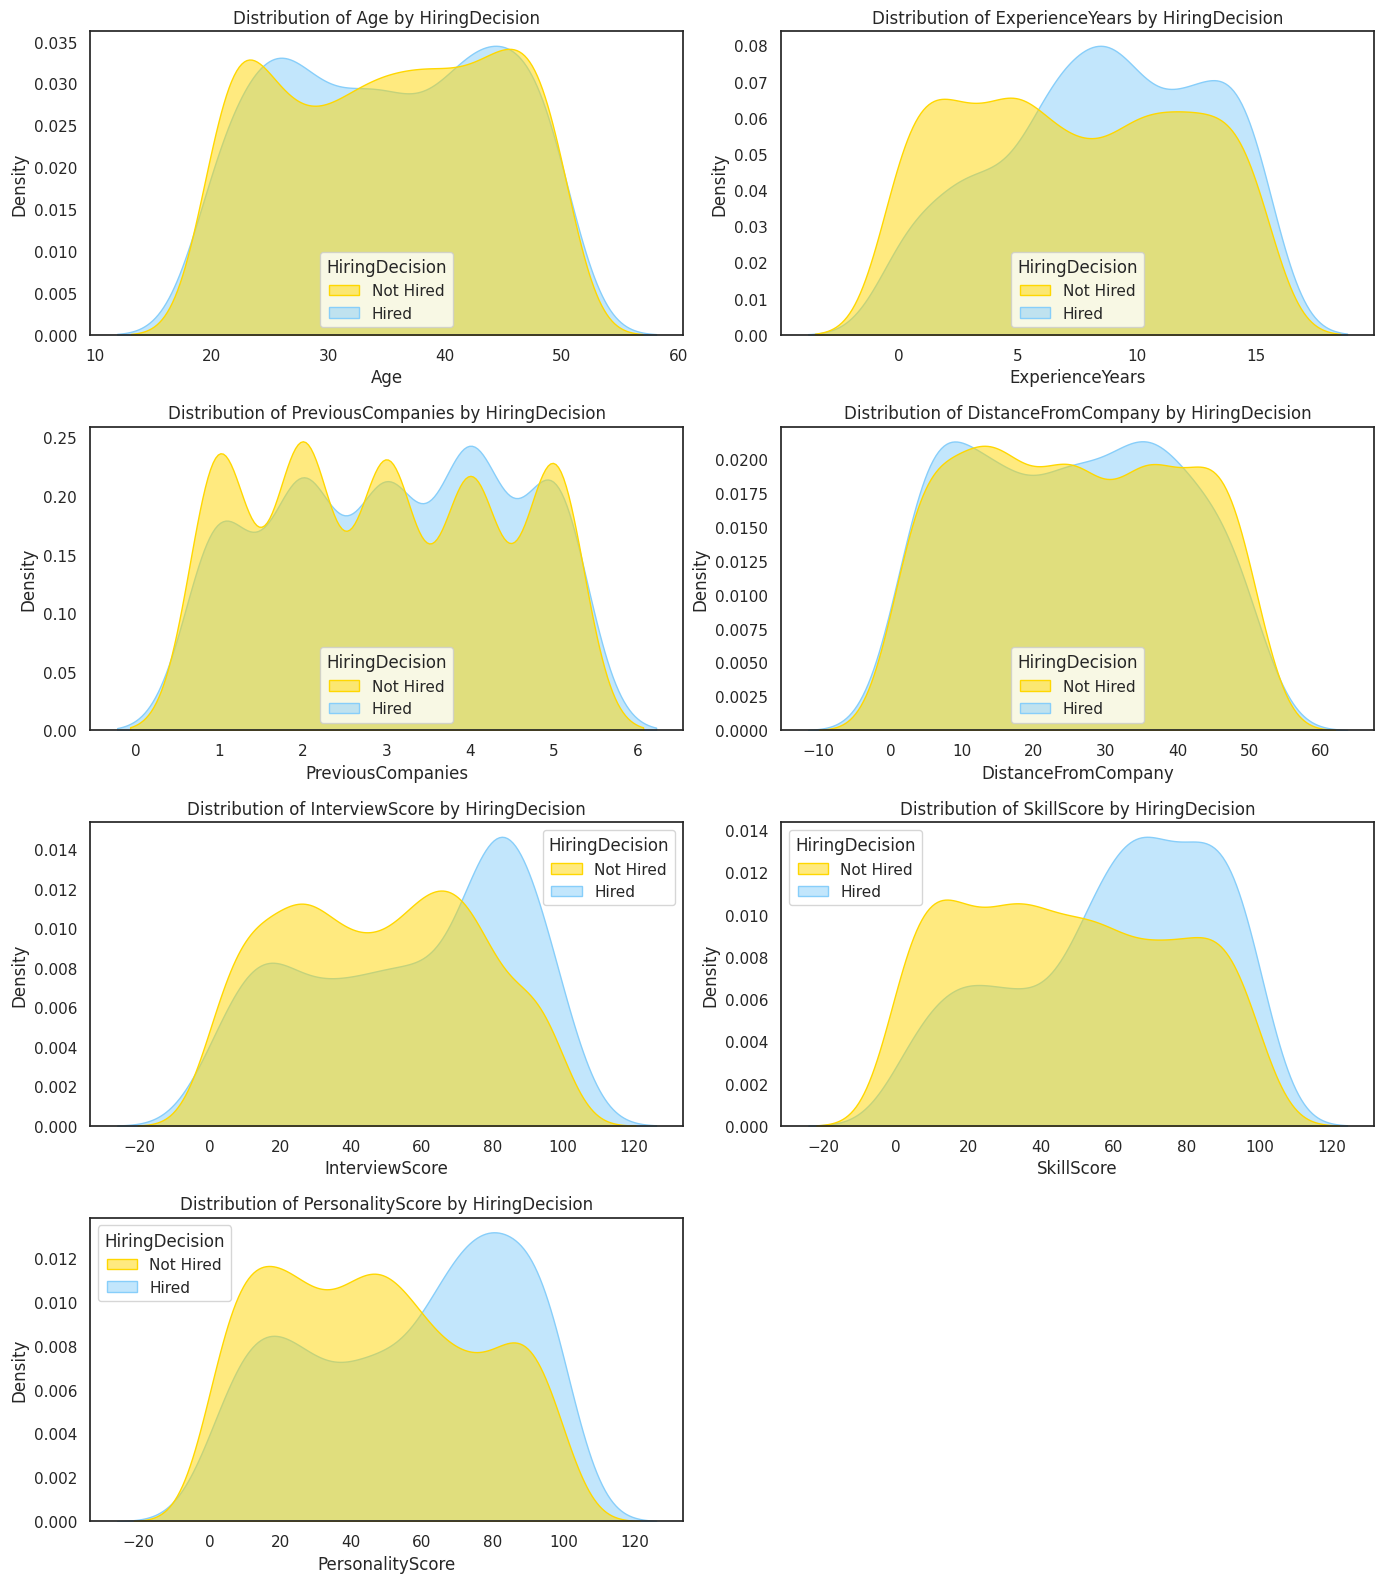

In [ ]:
# Set up the plotting style
sns.set(style="white")

# Plot numerical features using kdeplot with hue
n_cols = 2  # Number of columns per row
n_rows = (len(variable_num) + n_cols - 1) // n_cols  # Calculate number of rows needed

# Define custom color palette
custom_palette = {'Not Hired': 'gold', 'Hired': 'lightskyblue'}

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))  # Adjust the figure size
axes = axes.flatten()

for i, feature in enumerate(variable_num):
    sns.kdeplot(
        data=df,
        x=feature,
        hue='HiringDecision',
        fill=True,
        common_norm=False,
        alpha=0.5,
        ax=axes[i],
        palette=custom_palette
    )
    axes[i].set_title(f'Distribution of {feature} by HiringDecision')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')

# Remove any empty subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Dari hasil visualisasi ini kita mendapatkan informasi bahwa:
- **Age**: Distribusi umur kandidat yang Hired dan Not Hired menunjukkan pola yang hampir sepenuhnya tumpang tindih. Artinya, baik kandidat yang diterima maupun yang tidak diterima memiliki sebaran umur yang serupa. Dengan kata lain, umur bukanlah faktor pembeda utama dalam proses perekrutan pada data ini.
- **ExperienceYears**: Distribusi menunjukkan bahwa kandidat yang diterima cenderung memiliki pengalaman kerja lebih dari 5 tahun. Kurva Hired mulai meningkat tajam pada titik ini, sedangkan Not Hired menurun. Ini mengindikasikan bahwa pengalaman kerja berperan cukup signifikan dalam pengambilan keputusan perekrutan.
- **PreviousCompanies**: Baik kandidat yang diterima maupun yang tidak memiliki distribusi jumlah perusahaan sebelumnya yang hampir identik. Tidak ada pola yang menunjukkan kecenderungan berbeda antar kelompok. Maka dari itu, jumlah perusahaan tempat kandidat pernah bekerja tampaknya tidak terlalu memengaruhi hasil seleksi.
- **DistanceFromCompany**: Distribusi jarak tempat tinggal kandidat ke perusahaan juga tidak menunjukkan perbedaan signifikan antara kedua kelompok. Kurvanya saling tumpang tindih. Ini menunjukkan bahwa jarak rumah ke kantor bukan pertimbangan utama dalam proses seleksi ini.
- **InterviewScore**: Distribusi untuk kandidat yang tidak diterima didominasi oleh nilai di bawah 70, sedangkan kandidat yang diterima mulai mendominasi di atas skor 70. Ini menunjukkan adanya batas skor wawancara informal yang menjadi pertimbangan perekrut. Dengan kata lain, InterviewScore adalah fitur prediktif yang kuat terhadap keputusan perekrutan.
- **SkillScore**: Terlihat jelas bahwa kandidat yang diterima memiliki distribusi skor teknikal yang lebih tinggi, terutama di atas angka 50. Sebaliknya, Not Hired lebih banyak muncul di skor yang lebih rendah. Hal ini mengindikasikan bahwa kemampuan teknikal merupakan salah satu kriteria penting dalam proses seleksi.
- **PersonalityScore**: Distribusi skor kepribadian menunjukkan bahwa kandidat yang diterima cenderung memiliki skor di atas 60, meskipun masih terdapat sedikit tumpang tindih dengan kandidat yang tidak diterima. Hal ini mengindikasikan bahwa kepribadian mungkin menjadi faktor pendukung, meskipun tidak sekuat wawancara atau kemampuan teknikal.

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[variable_num].corr(), cmap='Blues', annot=True, fmt='.2f')

<Axes: >

- **SkillScore (+0.20)**: Semakin tinggi skor skill, semakin besar peluang diterima.
- **PersonalityScore (+0.17)**: Ada pengaruh positif, tapi tidak sekuat Skill. Masih penting untuk dipertimbangkan.
- **InterviewScore (+0.15)**: Punya pengaruh moderat. Bisa jadi karena skor interview subjektif, atau karena hanya bagian dari penilaian keseluruhan.
- **Fitur lain**: Korelasi sangat rendah (sekitar 0.00–0.12), artinya fitur-fitur ini tidak berpengaruh secara linier langsung terhadap keputusan penerimaan. Tapi bisa saja berguna dalam interaksi/fitur non-linear.

### Kolom Kategorikal

In [ ]:
variable_cat = ['Gender', 'EducationLevel', 'RecruitmentStrategy']

# Replace nilai2 kategori sementara
df['Gender'] = df['Gender'].replace({0:'Male', 1: 'Female'})
df['EducationLevel'] = df['EducationLevel'].replace({1:'High School', 2: 'Diploma/Bachelor',
                                                                           3: 'Master', 4: 'Post Graduate'})
df['RecruitmentStrategy'] = df['RecruitmentStrategy'].replace({1:'Headhunter/Agency', 2:'Online platform (LinkedIn, Job Portal)',
                                                                           3:'Walk-in or offline'})
df.sample(5)

Age  Gender    EducationLevel  ExperienceYears  PreviousCompanies  \
302   30  Female       High School                2                  5   
504   45    Male       High School                5                  1   
72    21    Male  Diploma/Bachelor                2                  1   
647   35    Male  Diploma/Bachelor               10                  5   
486   44    Male  Diploma/Bachelor                9                  1   

     DistanceFromCompany  InterviewScore  SkillScore  PersonalityScore  \
302            10.439701              79          79                14   
504             9.707835              95          50                14   
72             44.124481              28          11                43   
647            11.142662              44          55                94   
486             7.852640              53          60                 6   

                        RecruitmentStrategy HiringDecision  
302  Online platform (LinkedIn, Job Portal)      Not Hired  
504                      Walk-in or offline      Not Hired  
72   Online platform (LinkedIn, Job Portal)      Not Hired  
647  Online platform (LinkedIn, Job Portal)      Not Hired  
486  Online platform (LinkedIn, Job Portal)      Not Hired

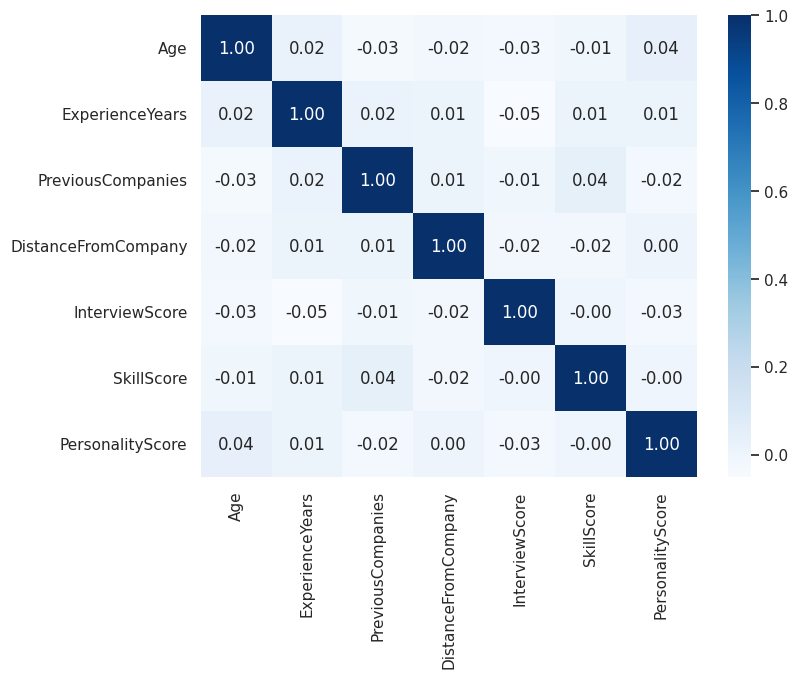

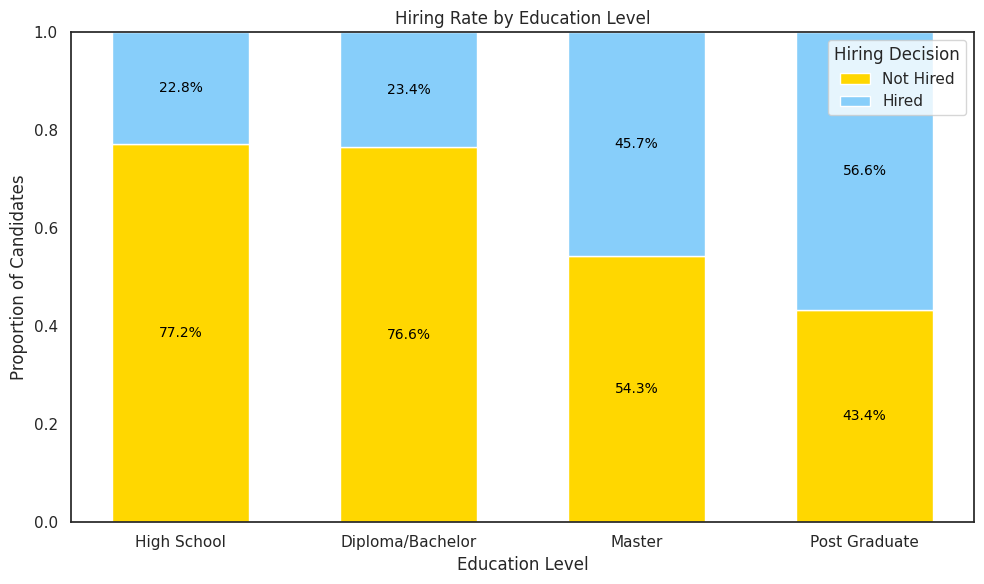

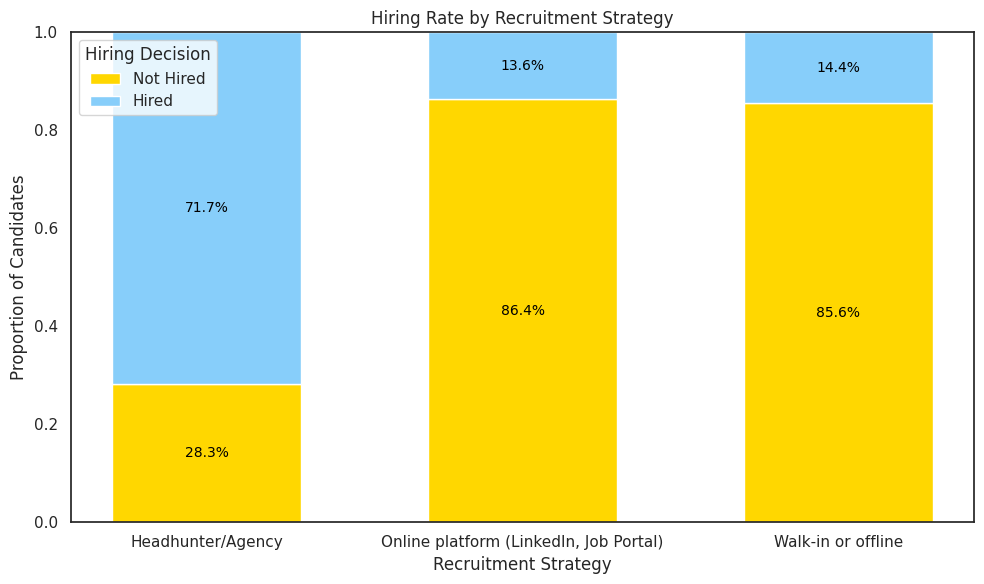

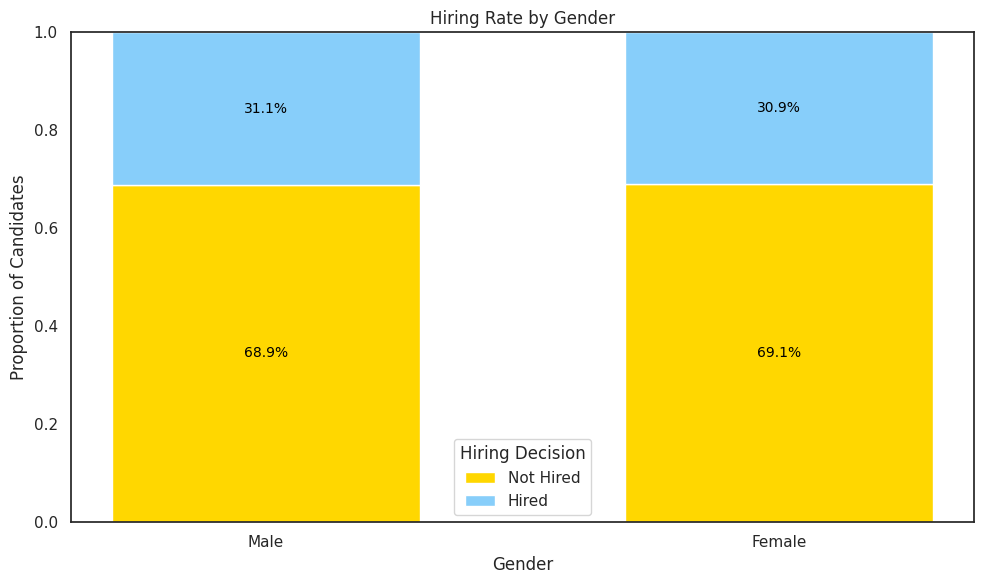

In [ ]:
# Custom color palette
custom_palette = {'Not Hired': 'gold', 'Hired': 'lightskyblue'}

# List of categorical columns and their x-axis labels
cat_columns = {
    'EducationLevel': 'Education Level',
    'RecruitmentStrategy': 'Recruitment Strategy',
    'Gender': 'Gender'
}

# Function to plot stacked hiring rate with percentages
def plot_stacked_hiring_rate_with_labels(df, column, xlabel):
    # Compute normalized proportions
    hiring_rate_df = (
        df.groupby(column)['HiringDecision']
        .value_counts(normalize=True)
        .unstack()
        .fillna(0)
        .reset_index()
    )

    # Sort for stacking order
    hiring_rate_df = hiring_rate_df[[column, 'Not Hired', 'Hired']]

    categories = hiring_rate_df[column]
    bar_width = 0.6
    bottom_vals = np.zeros(len(hiring_rate_df))

    plt.figure(figsize=(10, 6))

    for status in ['Not Hired', 'Hired']:
        heights = hiring_rate_df[status]
        bars = plt.bar(
            categories,
            heights,
            bottom=bottom_vals,
            color=custom_palette[status],
            label=status,
            width=bar_width
        )

        # Add labels
        for i, bar in enumerate(bars):
            percentage = heights.iloc[i] * 100
            if percentage > 3:  # Avoid cluttering with very small segments
                plt.text(
                    bar.get_x() + bar.get_width() / 2,
                    bottom_vals[i] + heights.iloc[i] / 2,
                    f'{percentage:.1f}%',
                    ha='center',
                    va='center',
                    fontsize=10,
                    color='black'
                )
        bottom_vals += heights

    plt.title(f'Hiring Rate by {xlabel}')
    plt.xlabel(xlabel)
    plt.ylabel('Proportion of Candidates')
    plt.ylim(0, 1)
    plt.xticks(rotation=0)
    plt.legend(title='Hiring Decision')
    plt.tight_layout()
    plt.show()

# Generate all enhanced stacked plots
for col, label in cat_columns.items():
    plot_stacked_hiring_rate_with_labels(df, col, label)

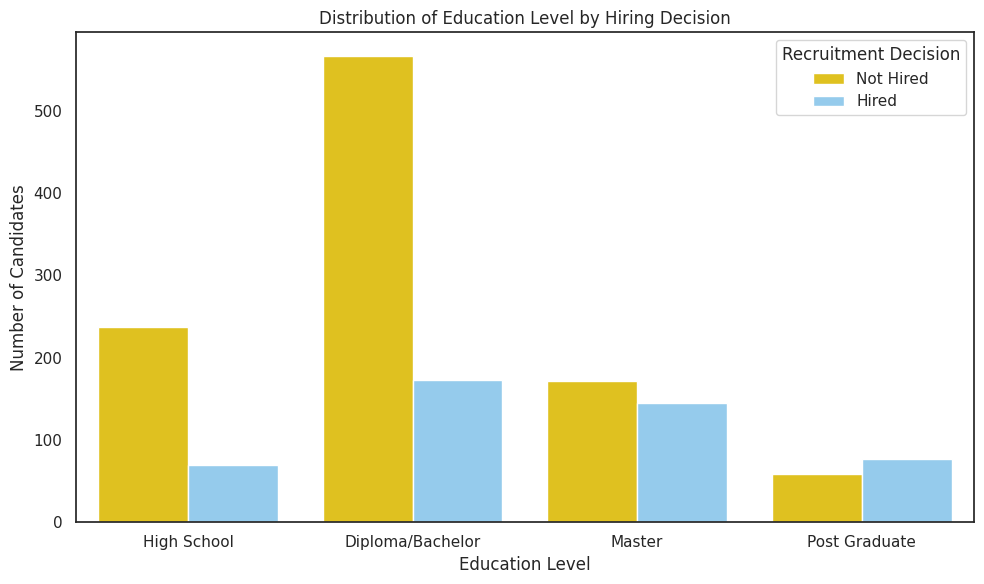

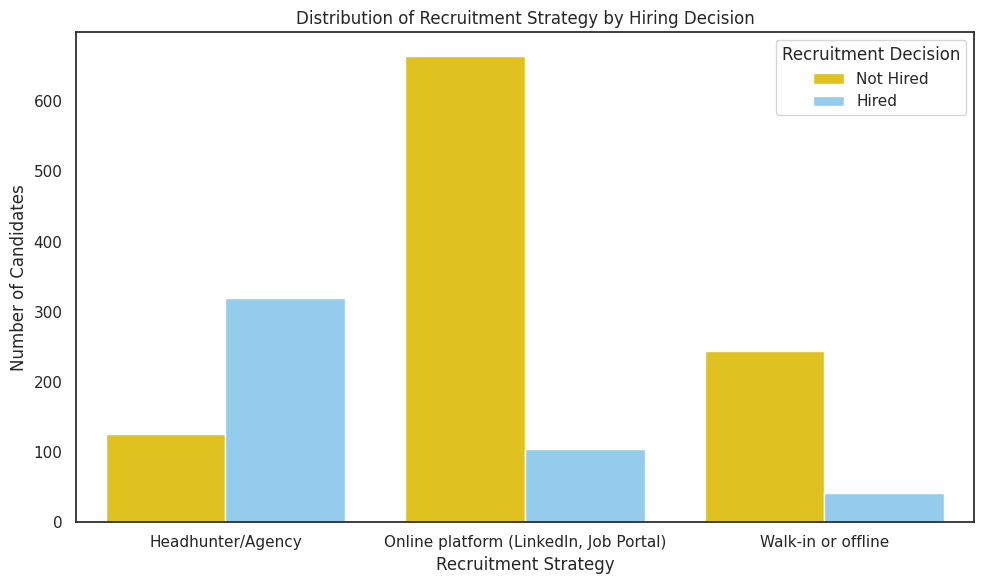

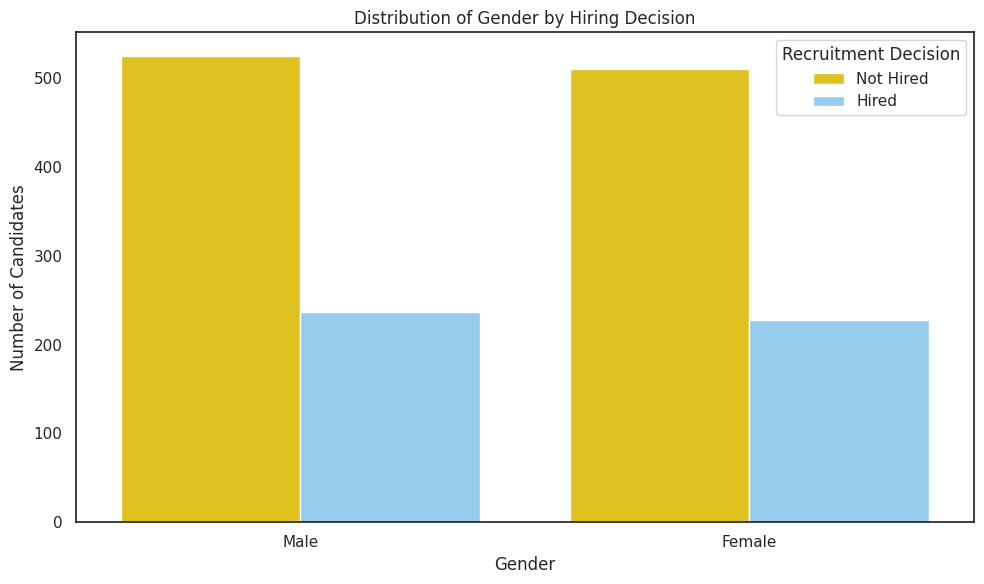

In [ ]:
# Custom color palette
custom_palette = {'Not Hired': 'gold', 'Hired': 'lightskyblue'}

# List of categorical columns and their x-axis labels
cat_columns = {
    'EducationLevel': 'Education Level',
    'RecruitmentStrategy': 'Recruitment Strategy',
    'Gender': 'Gender'
}

# Function to plot countplot
def plot_categorical_influence(df, column, xlabel):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=column, hue='HiringDecision', palette=custom_palette)
    plt.title(f'Distribution of {xlabel} by Hiring Decision')
    plt.xlabel(xlabel)
    plt.ylabel('Number of Candidates')
    plt.xticks(rotation=0)
    plt.legend(title='Recruitment Decision', labels=['Not Hired', 'Hired'])
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Generate all plots
for col, label in cat_columns.items():
    plot_categorical_influence(df, col, label)

- **Gender**: Data balance, risiko bias kuantitatif kecil, namun tetap perlu audit performa model per gender agar tidak ada bias gender.
- **EducationLevel**: Mayoritas ada pada Level 2, model bisa “belajar” bahwa Level 2 lazim, bukan berarti Level 1/3/4 buruk. Bisa mempertimbangkan regularisasi atau balanced loss.
- **RecruitmentStrategy**: Mayoritas ada pada Channel 2, namun berdasarkan heatmap korelasinya negatif, bisa dilakukan audit channel, revisi job‑ad, atau training recruiter.
- **HiringDecision**: Data imbalance, maka harus menentukan metrik yang sesuai (F1, ROC‑AUC) dan metode balancing sebelum training.

Berdasarkan analisis EDA dan visualisasi, beberapa strategi pemilihan fitur dapat dipertimbangkan:

1.  **Features dengan Korelasi Moderat/Tinggi terhadap Target:**
    *   Fitur seperti `RecruitmentStrategy`, `EducationLevel`, `SkillScore`, `PersonalityScore`, dan `InterviewScore` menunjukkan korelasi yang paling signifikan dengan `HiringDecision`. Fitur-fitur ini adalah kandidat utama untuk dipertahankan.
    *   `TotalScore` (hasil feature engineering) juga menunjukkan korelasi yang lebih kuat daripada skor individu, sehingga ini adalah fitur yang baik untuk digunakan.

2.  **Features yang Menunjukkan Pola Berbeda antara Hired dan Not Hired pada Visualisasi:**
    *   `ExperienceCategory`: Meskipun korelasi linear rendah, plot countplot menunjukkan pola yang berbeda (kategori Medium dan High cenderung lebih banyak diterima). Fitur kategorikal ini mungkin berguna untuk model non-linear.
    *   `DistanceCategory`: Mirip dengan Experience, kategori jarak tertentu mungkin memiliki pengaruh.
    *   `Age` dan `ExperienceYears`: Boxplot dan histogram menunjukkan perbedaan distribusi antara kandidat yang diterima dan tidak, meskipun korelasi linear rendah. Ini bisa menjadi indikator bahwa fitur ini masih informatif, terutama untuk model yang dapat menangkap hubungan non-linear.
    *   `PreviousCompanies`: Boxplot menunjukkan sedikit perbedaan median, ini mungkin kurang informatif dibandingkan fitur lain.

3.  **Features Engineering:**
    *   Fitur `TotalScore` jelas meningkatkan informasi karena menggabungkan tiga skor penting.
    *   Fitur interaksi seperti `Distance_x_TotalScore` atau rasio seperti `Skill_Per_Year` mungkin menangkap hubungan kompleks yang tidak terlihat pada fitur tunggal. Bergantung pada performa model awal, fitur-fitur ini bisa ditambahkan atau dihapus.

4.  **Mempertimbangkan Fitur Kategorikal yang Sudah Di-Engineering:**
    *   `DistanceCategory` dan `ExperienceCategory` telah dibuat. Fitur-fitur ini harus di-encode (One-Hot Encoding) sebelum digunakan dalam model.

5.  **Fitur dengan Korelasi Sangat Rendah/Tidak Ada Pola Jelas:**
    *   Fitur seperti `Gender` (meskipun penting untuk audit bias, korelasinya dengan target sangat rendah) dan `PreviousCompanies` (perbedaan kecil di boxplot) mungkin memiliki kontribusi yang minimal terhadap prediksi langsung, tetapi tetap bisa dipertimbangkan tergantung performa. `Gender` harus dipertahankan untuk tujuan audit bias.

**Rekomendasi Awal untuk Pemilihan Fitur:**

Berdasarkan analisis, set fitur awal yang kuat untuk dicoba adalah:

*   `Age`
*   `Gender` (penting untuk audit bias)
*   `EducationLevel`
*   `ExperienceYears`
*   `DistanceFromCompany`
*   `TotalScore` (pengganti `InterviewScore`, `SkillScore`, `PersonalityScore`)
*   `RecruitmentStrategy`
*   `Distance_x_TotalScore` (sebagai fitur interaksi potensial)
*   `Skill_Per_Year` (sebagai fitur rasio potensial)
*   `DistanceCategory` (perlu encoding)
*   `ExperienceCategory` (perlu encoding)

Fitur `PreviousCompanies` tampaknya kurang informatif, tetapi bisa tetap dimasukkan dalam set awal untuk melihat dampaknya. `InterviewScore`, `SkillScore`, dan `PersonalityScore` individu dapat dihapus jika `TotalScore` digunakan, untuk menghindari multikolinearitas dan menyederhanakan model.

**Langkah Selanjutnya:**

*   Lakukan One-Hot Encoding untuk fitur kategorikal (`Gender`, `EducationLevel`, `RecruitmentStrategy`, `DistanceCategory`, `ExperienceCategory`).
*   Implementasikan model machine learning (misalnya, Logistic Regression, Random Forest, Gradient Boosting).
*   Gunakan teknik evaluasi fitur (seperti Feature Importance dari model tree-based, Permutation Importance, atau SelectKBest) untuk memvalidasi dan menyempurnakan pilihan fitur ini.
*   Uji berbagai kombinasi fitur dan bandingkan performa model menggunakan metrik yang sesuai untuk data imbalance (seperti F1-score atau ROC-AUC).
*   Audit bias pada fitur `Gender` meskipun korelasinya rendah.
*   Pertimbangkan strategi *oversampling* atau *undersampling* untuk mengatasi imbalance pada target `HiringDecision`.

## Feature Engineering

In [ ]:
# 1. Total Score
df['TotalScore'] = df['InterviewScore'] + df['SkillScore'] + df['PersonalityScore']

# 2. Distance & Total Score Interaction
df['Distance_x_TotalScore'] = df['DistanceFromCompany'] * df['TotalScore']

# 3. Skill per Year of Experience
# Add a small constant (e.g., 1) to ExperienceYears to avoid division by zero
df['Skill_Per_Year'] = df['SkillScore'] / (df['ExperienceYears'] + 1)

# 4. Distance Category
df['DistanceCategory'] = pd.cut(df['DistanceFromCompany'],
                                bins=[-1,10,20,30,40,100],
                                labels=['<10km','10-20km','20-30km','30-40km','40km+'])

# 5. Experience Category
df['ExperienceCategory'] = pd.cut(df['ExperienceYears'],
                                  bins=[-1,2,5,10,50],
                                  labels=['Very Low (<2)','Low (2-5)','Medium (5-10)','High (10+)'])

# 6. Age Category
df['AgeCategory'] = pd.cut(df['Age'],
                           bins=[0, 20,31,100],
                           labels=['<20','20-30','30+'])

df[['TotalScore', 'Distance_x_TotalScore', 'Skill_Per_Year', 'DistanceCategory', 'ExperienceCategory', 'AgeCategory']].sample(5)

TotalScore  Distance_x_TotalScore  Skill_Per_Year DistanceCategory  \
201          114             298.971138       33.500000            <10km   
1116         193            5821.615302        5.250000          30-40km   
938          223             498.069993        2.937500            <10km   
941          112            3098.526830        5.800000          20-30km   
291          175            2404.051189       11.333333          10-20km   

     ExperienceCategory AgeCategory  
201       Very Low (<2)         30+  
1116         High (10+)         30+  
938          High (10+)         30+  
941          High (10+)       20-30  
291           Low (2-5)         <20

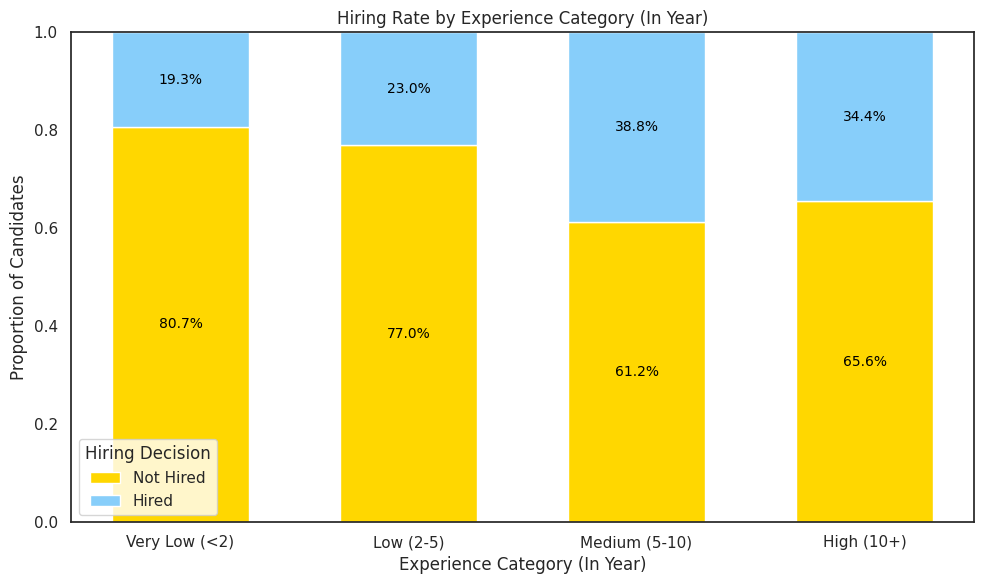

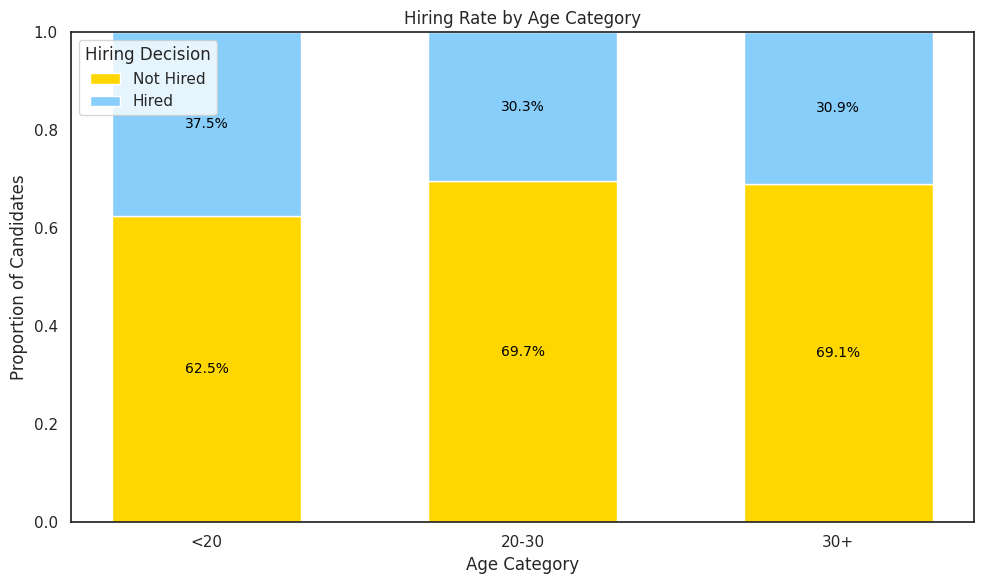

In [ ]:
# Custom color palette
custom_palette = {'Not Hired': 'gold', 'Hired': 'lightskyblue'}

# List of categorical columns and their x-axis labels
cat_columns = {
    'ExperienceCategory': 'Experience Category (In Year)',
    'AgeCategory': 'Age Category'
}

# Generate all enhanced stacked plots
for col, label in cat_columns.items():
    plot_stacked_hiring_rate_with_labels(df, col, label)

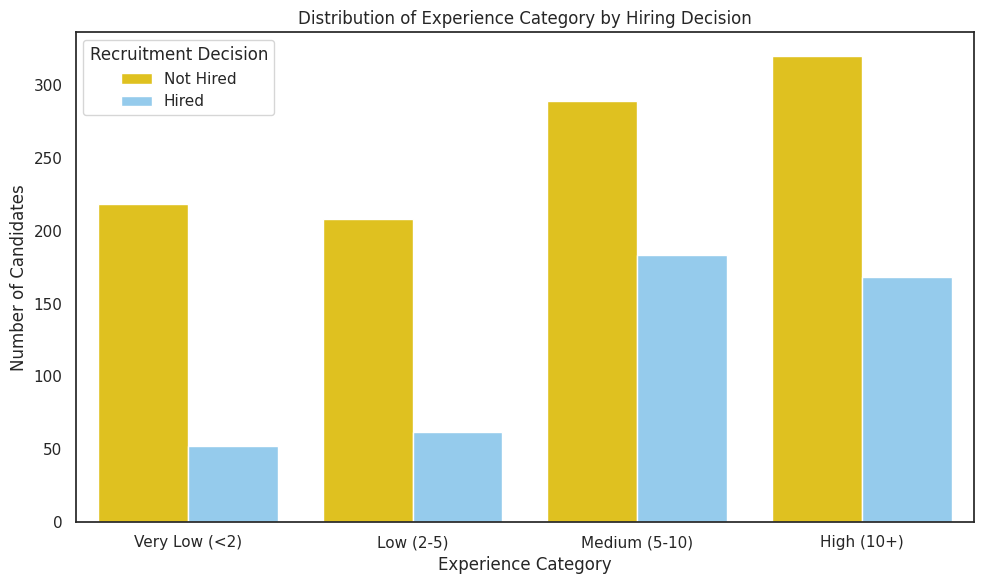

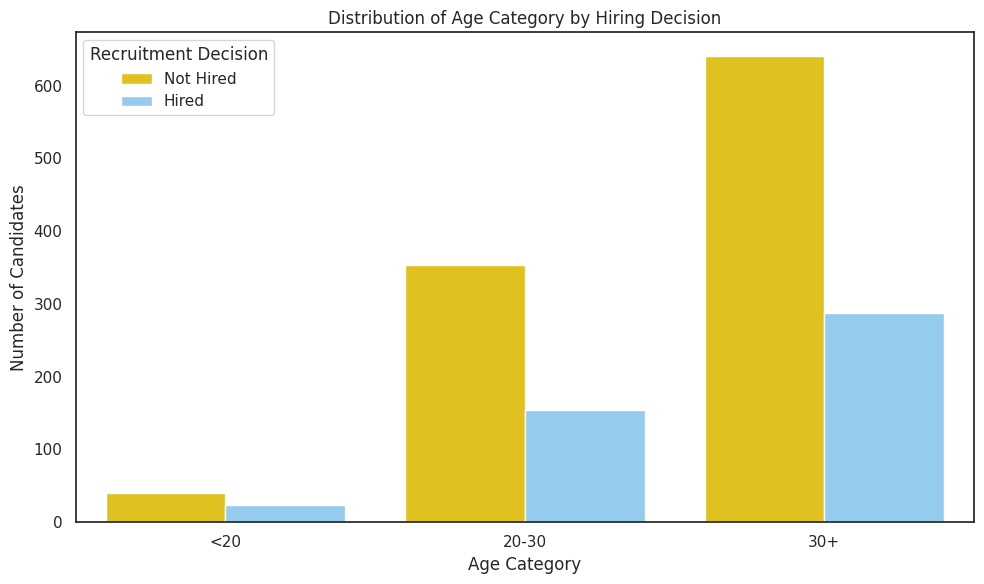

In [ ]:
# Custom color palette
custom_palette = {'Not Hired': 'gold', 'Hired': 'lightskyblue'}

# List of categorical columns and their x-axis labels
cat_columns = {
    'ExperienceCategory': 'Experience Category',
    'AgeCategory': 'Age Category'
}

# Function to plot countplot
def plot_categorical_influence(df, column, xlabel):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=column, hue='HiringDecision', palette=custom_palette)
    plt.title(f'Distribution of {xlabel} by Hiring Decision')
    plt.xlabel(xlabel)
    plt.ylabel('Number of Candidates')
    plt.xticks(rotation=0)
    plt.legend(title='Recruitment Decision', labels=['Not Hired', 'Hired'])
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Generate all plots
for col, label in cat_columns.items():
    plot_categorical_influence(df, col, label)

**Penjelasan**
- **TotalScore**: Menggabungkan tiga skor evaluasi utama menjadi satu metrik gabungan yang merepresentasikan kualitas keseluruhan kandidat.
- **Distance_x_TotalScore**: Menangkap interaksi antara kinerja kandidat dan jaraknya dari perusahaan. Bisa mencerminkan komitmen atau risiko kenyamanan kerja.
- **Skill_Per_Year**: Menormalisasi skill berdasarkan lama pengalaman untuk melihat efisiensi atau produktivitas per tahun pengalaman.
- **DistanceCategory**: Mengelompokkan jarak tempat tinggal ke dalam kategori interval jarak tetap.
- **ExperienceYears**: Mengelompokkan pengalaman kerja ke dalam tingkat senioritas.

## Feature Selection

### Chi-Square & ANOVA Tests

In [ ]:
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Step 1: Check types
categorical_vars = df.select_dtypes(['category']).columns.tolist()
categorical_vars.remove('HiringDecision')  # Remove target variable
numerical_vars = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Step 2: Chi-Square Test for categorical vs. HiringDecision
print("=====Chi-Square Tests (Categorical vs. HiringDecision)=====")
for var in categorical_vars:
    contingency_table = pd.crosstab(df[var], df['HiringDecision'])
    chi2, p, dof, ex = stats.chi2_contingency(contingency_table)
    print(f"{var}: chi2 = {chi2:.3f}, p-value = {p:.4f} {'(Significant)' if p < 0.05 else ''}")

# Step 3: ANOVA for numerical variables vs. HiringDecision
print("\n=====ANOVA Tests (Numerical vs. HiringDecision)=====")
for var in numerical_vars:
    model = ols(f'{var} ~ C(HiringDecision)', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    p_value = anova_table['PR(>F)'][0]
    print(f"{var}: F = {anova_table['F'][0]:.3f}, p-value = {p_value:.4f} {'(Significant)' if p_value < 0.05 else ''}")

=====Chi-Square Tests (Categorical vs. HiringDecision)=====
Gender: chi2 = 0.001, p-value = 0.9751 
EducationLevel: chi2 = 103.675, p-value = 0.0000 (Significant)
RecruitmentStrategy: chi2 = 489.681, p-value = 0.0000 (Significant)
DistanceCategory: chi2 = 4.818, p-value = 0.3065 
ExperienceCategory: chi2 = 41.558, p-value = 0.0000 (Significant)
AgeCategory: chi2 = 1.378, p-value = 0.5021 

=====ANOVA Tests (Numerical vs. HiringDecision)=====
Age: F = 0.005, p-value = 0.9429 
ExperienceYears: F = 22.819, p-value = 0.0000 (Significant)
PreviousCompanies: F = 2.909, p-value = 0.0883 
DistanceFromCompany: F = 0.422, p-value = 0.5158 
InterviewScore: F = 32.656, p-value = 0.0000 (Significant)
SkillScore: F = 64.827, p-value = 0.0000 (Significant)
PersonalityScore: F = 44.137, p-value = 0.0000 (Significant)
TotalScore: F = 152.226, p-value = 0.0000 (Significant)
Distance_x_TotalScore: F = 27.329, p-value = 0.0000 (Significant)
Skill_Per_Year: F = 0.530, p-value = 0.4669 


#### Penjelasan

##### Categorical Variables (Chi-Square Tests)


| Variable            | p-value  | Significance      |
| ------------------- | -------- | ----------------- |
| Gender              | 0.9751   | ❌ Not Significant |
| EducationLevel      | < 0.0001 | ✅ Significant     |
| RecruitmentStrategy | < 0.0001 | ✅ Significant     |
| DistanceCategory    | 0.3065   | ❌ Not Significant |
| ExperienceCategory  | < 0.0001 | ✅ Significant     |

**Penjelasan**
- Tingkat Pendidikan, Strategi Rekrutmen, dan Kategori Pengalaman sangat berkaitan dengan keputusan perekrutan.
- Jenis Kelamin dan Kategori Jarak tidak memiliki hubungan yang signifikan, menunjukkan bahwa keduanya tidak memengaruhi hasil perekrutan secara signifikan.

##### Numerical Variables (ANOVA Tests)

| Variable                  | p-value  | Significance         |
| ------------------------- | -------- | -------------------- |
| Age                       | 0.9429   | ❌ Not Significant    |
| ExperienceYears           | < 0.0001 | ✅ Significant        |
| PreviousCompanies         | 0.0883   | ❌ Not Significant    |
| DistanceFromCompany       | 0.5158   | ❌ Not Significant    |
| InterviewScore            | < 0.0001 | ✅ Significant        |
| SkillScore                | < 0.0001 | ✅ Significant        |
| PersonalityScore          | < 0.0001 | ✅ Significant        |
| **TotalScore**            | < 0.0001 | ✅ Highly Significant |
| **Distance × TotalScore** | < 0.0001 | ✅ Significant        |
| Skill\_Per\_Year          | 0.4669   | ❌ Not Significant    |

**Penjelasan**

Variabel numerik berikut menunjukkan hubungan yang kuat dan signifikan secara statistik dengan keputusan perekrutan:

- Pengalaman Tahun
- Skor Wawancara
- Skor Keterampilan
- Skor Kepribadian
- Skor Total
- Jarak × Skor Total (istilah interaksi)

Variabel seperti Usia, Jarak dari Perusahaan, Perusahaan Sebelumnya, dan Keterampilan Per Tahun tidak signifikan secara statistik.

##### Kesimpulan

Analisis ini menegaskan bahwa keputusan perekrutan dipengaruhi oleh kombinasi:
- **Kualifikasi dan kinerja**: Tingkat Pendidikan, Skor Wawancara, Skor Keterampilan, Skor Kepribadian, dan Skor Total keseluruhan.
- **Faktor strategis**: Strategi Rekrutmen dan Tingkat Pengalaman (baik mentah maupun terkategori).
- **Efek interaktif**: Interaksi antara jarak dan skor kinerja total juga memainkan peran penting.

Sebaliknya, variabel demografis seperti Jenis Kelamin dan Usia, serta beberapa fitur turunan seperti Keterampilan Per Tahun dan Jarak dari Perusahaan, tidak secara signifikan memengaruhi keputusan perekrutan dalam kumpulan data ini.

### T-Test

In [ ]:
from scipy.stats import ttest_ind

# Ensure binary target encoded as 0/1
df['HiringDecision'] = df['HiringDecision'].astype('category')
group0 = df[df['HiringDecision'] == df['HiringDecision'].cat.categories[0]]
group1 = df[df['HiringDecision'] == df['HiringDecision'].cat.categories[1]]

print("=====T-Tests Between Hired vs Not Hired=====")
for var in numerical_vars:
    t_stat, p = ttest_ind(group0[var], group1[var], equal_var=False)
    print(f"{var}: t = {t_stat:.3f}, p = {p:.4f} {'(Significant)' if p < 0.05 else ''}")

=====T-Tests Between Hired vs Not Hired=====
Age: t = -0.072, p = 0.9429 
ExperienceYears: t = -4.930, p = 0.0000 (Significant)
PreviousCompanies: t = -1.721, p = 0.0855 
DistanceFromCompany: t = 0.654, p = 0.5130 
InterviewScore: t = -5.525, p = 0.0000 (Significant)
SkillScore: t = -8.246, p = 0.0000 (Significant)
PersonalityScore: t = -6.546, p = 0.0000 (Significant)
TotalScore: t = -12.650, p = 0.0000 (Significant)
Distance_x_TotalScore: t = -4.935, p = 0.0000 (Significant)
Skill_Per_Year: t = 0.757, p = 0.4495 


#### Penjelasan

**Ringkasan**
| Variable                  | p-value | Significant? | Interpretation                                                                               |
| ------------------------- | ------- | ------------ | -------------------------------------------------------------------------------------------- |
| **Age**                   | 0.9429  | ❌ No         | Tidak ada perbedaan usia rata-rata                                                                |
| **ExperienceYears**       | 0.0000  | ✅ Yes        | Kandidat yang direkrut memiliki **pengalaman lebih banyak** rata-rata.                                        |
| **PreviousCompanies**     | 0.0855  | ❌ No         | Sedikit perbedaan, tetapi tidak signifikan secara statistik.                                        |
| **DistanceFromCompany**   | 0.5130  | ❌ No         | Tidak ada perbedaan jarak perjalanan yang signifikan.                                                |
| **InterviewScore**        | 0.0000  | ✅ Yes        | Kandidat yang direkrut mendapat skor **jauh lebih tinggi** dalam wawancara.                              |
| **SkillScore**            | 0.0000  | ✅ Yes        | Kandidat yang direkrut menunjukkan **penilaian keterampilan yang lebih kuat**.                                        |
| **PersonalityScore**      | 0.0000  | ✅ Yes        | Kandidat yang direkrut memiliki skor **kesesuaian kepribadian yang lebih baik**.                                     |
| **TotalScore**            | 0.0000  | ✅ Yes        | **Sangat signifikan**—skor total merupakan prediktor perekrutan yang kuat.                             |
| **Distance × TotalScore** | 0.0000  | ✅ Yes        | Istilah interaksi menunjukkan signifikansi—**karyawan berkinerja tinggi yang dekat dengan perusahaan** mungkin lebih disukai. |
| **Skill\_Per\_Year**      | 0.4495  | ❌ No         | Tidak ada perbedaan signifikan ketika keterampilan dinormalisasi berdasarkan pengalaman.                          |

**Kesimpulan**
- Metrik terkait kinerja (**InterviewScore**, **SkillScore**, **PersonalityScore**, dan terutama **TotalScore**) secara signifikan lebih tinggi pada kandidat yang direkrut.
- **ExperienceYears** juga merupakan faktor pembeda, yang memperkuat pentingnya paparan industri.
- Tidak ada bukti yang mendukung **Usia**, **Jarak dari Perusahaan**, atau **Skill_Per_Year** sebagai faktor yang memengaruhi keputusan perekrutan.

### WOE (Weight of Evidence) & IV (Information Value)

In [ ]:
import pandas as pd
import numpy as np

def calc_woe_iv(df, feature, target):
    df = df[[feature, target]].copy()
    df[feature] = df[feature].astype(str)

    # Calculate good/bad totals
    total_good = (df[target] == 0).sum()
    total_bad = (df[target] == 1).sum()

    # Group by feature
    grouped = df.groupby(feature).agg(
        good=(target, lambda x: (x == 0).sum()),
        bad=(target, lambda x: (x == 1).sum())
    ).reset_index()

    # Calculate distributions
    grouped['dist_good'] = grouped['good'] / total_good
    grouped['dist_bad'] = grouped['bad'] / total_bad

    # Calculate WOE and IV
    grouped['WOE'] = np.log((grouped['dist_good'] + 1e-6) / (grouped['dist_bad'] + 1e-6))
    grouped['IV'] = (grouped['dist_good'] - grouped['dist_bad']) * grouped['WOE']

    # Add feature name (optional, for clarity)
    grouped['Variable'] = feature

    iv = grouped['IV'].sum()
    return grouped[['Variable', feature, 'WOE', 'IV']], iv

# Example for one variable
df['HiringDecision_bin'] = df['HiringDecision'].cat.codes
categorical_vars = ['Gender', 'EducationLevel', 'RecruitmentStrategy', 'DistanceCategory', 'ExperienceCategory']
iv_results = []

print("=====WOE/IV Function Between Hired vs Not Hired=====\n")
for col in categorical_vars:
    woe_df, iv = calc_woe_iv(df, col, 'HiringDecision_bin')
    print(f"{col}: IV = {iv:.4f}")
    iv_results.append((col, iv))

=====WOE/IV Function Between Hired vs Not Hired=====

Gender: IV = 0.0000
EducationLevel: IV = 0.3084
RecruitmentStrategy: IV = 1.5565
DistanceCategory: IV = 0.0149
ExperienceCategory: IV = 0.1377


#### Penjelasan

**Ringkasan**
| Variable                | IV     | Predictive Strength                    |
| ----------------------- | ------ | -------------------------------------- |
| **Gender**              | 0.0000 | ❌ None                                 |
| **EducationLevel**      | 0.3084 | ✅ **Strong**                           |
| **RecruitmentStrategy** | 1.5565 | ✅✅ **Very Strong** (Highly predictive) |
| **DistanceCategory**    | 0.0149 | ❌ Very Weak / None                     |
| **ExperienceCategory**  | 0.1377 | ✅ **Moderate**                         |

**Penjelasan**
- Strategi Rekrutmen (IV = 1,56): Prediktor yang sangat kuat. Metode yang digunakan untuk menemukan kandidat sangat menunjukkan apakah mereka diterima. Kemungkinan mencerminkan proses terstruktur vs. rekrutmen ad hoc.
- Tingkat Pendidikan (IV = 0,31): Prediktor yang kuat—mendukung gagasan bahwa latar belakang akademis secara signifikan memengaruhi keputusan perekrutan.
- Kategori Pengalaman (IV = 0,14): Menunjukkan daya prediksi sedang. Pengalaman praktis berperan tetapi bukan satu-satunya penentu.
- Kategori Gender (IV = 0,00) dan Jarak (IV = 0,01): Tidak memberikan nilai prediksi yang berarti. Hal ini positif dari perspektif keadilan, karena perekrutan tampaknya tidak dipengaruhi oleh gender atau kedekatan.

### Rekomendasi

#### Fitur dengan Signifikansi Statistik Tinggi terhadap Target (`HiringDecision`)

Berdasarkan **Chi-Square, ANOVA, T-Test, dan IV analysis**, fitur-fitur berikut menunjukkan pengaruh yang **signifikan secara statistik** terhadap keputusan hiring:

* **RecruitmentStrategy**

  * Sangat signifikan secara statistik di semua uji (Chi-Square, IV = 1.56 → *Very Strong Predictor*).
* **EducationLevel**

  * Konsisten signifikan (Chi-Square, IV = 0.31 → *Strong Predictor*).
* **ExperienceYears**

  * Signifikan (ANOVA & T-Test) → lebih tinggi pada kandidat yang diterima.
* **InterviewScore, SkillScore, PersonalityScore**

  * Semua signifikan (ANOVA & T-Test).
* **TotalScore**

  * Paling signifikan (F = 152, t = -12.6) → sebaiknya digunakan sebagai pengganti tiga skor terpisah.
* **Distance\_x\_TotalScore**

  * Signifikan (ANOVA & T-Test) → fitur interaksi yang kuat.
* **ExperienceCategory**

  * Signifikan (Chi-Square, IV = 0.14 → Moderate predictor).

#### Fitur dengan Pengaruh Lemah atau Tidak Signifikan

* **Gender**

  * Tidak signifikan di Chi-Square, T-Test, maupun IV (IV = 0.0000).

    > Tetap dipertahankan untuk **audit bias** dan fairness, tetapi bukan fitur prediktif.
* **DistanceCategory**

  * Tidak signifikan (Chi-Square, IV = 0.01), tetapi bisa dipertahankan untuk **model non-linear** atau segmentasi.
* **Age**, **DistanceFromCompany**, **Skill\_Per\_Year**, **PreviousCompanies**

  * Tidak signifikan di ANOVA/T-Test. Bisa **dipertimbangkan untuk di-drop**, atau dipertahankan sementara untuk validasi awal model.

#### Pilihan Fitur Awal untuk Modeling

| Status           | Fitur                                              | Alasan                                          |
| ---------------- | -------------------------------------------------- | ----------------------------------------------- |
| ✅ Gunakan        | `RecruitmentStrategy`                              | Sangat signifikan (IV = 1.56)                   |
| ✅ Gunakan        | `EducationLevel`                                   | Signifikan (IV = 0.31)                          |
| ✅ Gunakan        | `ExperienceYears`                                  | Signifikan (ANOVA & T-Test)                     |
| ✅ Gunakan        | `TotalScore`                                       | Sangat signifikan, menggantikan 3 skor          |
| ✅ Gunakan        | `Distance_x_TotalScore`                            | Fitur interaksi signifikan                      |
| ✅ Gunakan        | `ExperienceCategory`                               | Signifikan, cocok untuk model non-linear        |
| ✅ Gunakan        | `Gender`                                           | Tidak signifikan, tapi penting untuk audit bias |
| 🔁 Pertimbangkan | `Skill_Per_Year`                                   | Tidak signifikan, bisa diuji di model awal      |
| 🔁 Pertimbangkan | `DistanceCategory`                                 | Tidak signifikan, berguna di segmentasi         |
| 🔁 Pertimbangkan | `Age`                                              | Tidak signifikan, tetapi berbeda distribusi     |
| ❌ Opsional drop  | `InterviewScore`, `SkillScore`, `PersonalityScore` | Redundan dengan `TotalScore`                    |
| ❌ Opsional drop  | `PreviousCompanies`                                | Tidak informatif dalam statistik awal           |

#### Kesimpulan

* Proses seleksi fitur didasarkan tidak hanya pada korelasi dan visualisasi, tetapi juga pada **signifikansi statistik dan nilai prediktif**.
* **Fokus utama** pada fitur yang terbukti signifikan dari berbagai sudut analisis akan meningkatkan kinerja dan interpretabilitas model.
* **Fitur dengan nilai IV tinggi dan signifikan di T-Test & ANOVA** memiliki prioritas tinggi.
* **Fitur seperti Gender tetap disimpan untuk audit fairness**, meskipun tidak prediktif.

## Feature Encoding

- Ubah nilai-nilai pada kolom `Gender` dan `RecruitmentStrategy` menjadi format biner (0 dan 1) menggunakan One-Hot Encoding.
- Lakukan pengkodean urutan (ordinal) pada kolom `DistanceCategory`, `ExperienceCategory`, dan `EducationLevel`.

In [ ]:
# Fitur nominal
nominal_features = ['Gender', 'RecruitmentStrategy']

print("Sebelum One-Hot Encoding:")
df[nominal_features].sample(5)

Sebelum One-Hot Encoding:


Gender                     RecruitmentStrategy
652     Male                      Walk-in or offline
145     Male                       Headhunter/Agency
1326  Female  Online platform (LinkedIn, Job Portal)
200     Male                       Headhunter/Agency
552   Female  Online platform (LinkedIn, Job Portal)

In [ ]:
# Terapkan One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=nominal_features, drop_first=True)

print("Setelah One-Hot Encoding:")
df_encoded.sample(5)

Setelah One-Hot Encoding:


Age    EducationLevel  ExperienceYears  PreviousCompanies  \
1103   29     Post Graduate               15                  1   
1123   49       High School               13                  1   
397    49       High School                9                  2   
985    37  Diploma/Bachelor               11                  5   
258    29  Diploma/Bachelor               10                  3   

      DistanceFromCompany  InterviewScore  SkillScore  PersonalityScore  \
1103            24.130515              50          80                79   
1123            23.678640              94          29                11   
397             44.625998              88          88                25   
985             49.246430              62          16                86   
258             38.846383              14          96                20   

     HiringDecision  TotalScore  Distance_x_TotalScore  Skill_Per_Year  \
1103          Hired         209            5043.277669        5.000000   
1123      Not Hired         134            3172.937824        2.071429   
397       Not Hired         201            8969.825516        8.800000   
985       Not Hired         164            8076.414532        1.333333   
258           Hired         130            5050.029786        8.727273   

     DistanceCategory ExperienceCategory AgeCategory  HiringDecision_bin  \
1103          20-30km         High (10+)       20-30                   1   
1123          20-30km         High (10+)         30+                   0   
397             40km+      Medium (5-10)         30+                   0   
985             40km+         High (10+)         30+                   0   
258           30-40km      Medium (5-10)       20-30                   1   

      Gender_Female  \
1103          False   
1123          False   
397            True   
985            True   
258           False   

      RecruitmentStrategy_Online platform (LinkedIn, Job Portal)  \
1103                                               True            
1123                                               True            
397                                                True            
985                                                True            
258                                               False            

      RecruitmentStrategy_Walk-in or offline  
1103                                   False  
1123                                   False  
397                                    False  
985                                    False  
258                                    False

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

# Fitur ordinal dan urutannya
ordinal_features = ['EducationLevel', 'DistanceCategory', 'ExperienceCategory']

print("Sebelum Ordinal Encoding:")
df[ordinal_features].head(5)

Sebelum Ordinal Encoding:


EducationLevel DistanceCategory ExperienceCategory
0  Diploma/Bachelor          20-30km      Very Low (<2)
1     Post Graduate          20-30km         High (10+)
2  Diploma/Bachelor            <10km          Low (2-5)
3  Diploma/Bachelor            <10km          Low (2-5)
4       High School            40km+      Medium (5-10)

In [ ]:
# Urutan kategori
education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']
distance_order = ['<10km', '10-20km', '20-30km', '30-40km', '40km+']
experience_order = ['Very Low (<2)', 'Low (2-5)', 'Medium (5-10)', 'High (10+)']

# Buat encoder
ordinal_encoder = OrdinalEncoder(categories=[education_order, distance_order, experience_order])

# Terapkan encoding
df_encoded[ordinal_features] = ordinal_encoder.fit_transform(df[ordinal_features])

print("Setelah Ordinal Encoding:")
df_encoded[ordinal_features].head(5)

Setelah Ordinal Encoding:


EducationLevel  DistanceCategory  ExperienceCategory
0             1.0               2.0                 0.0
1             3.0               2.0                 3.0
2             1.0               0.0                 1.0
3             1.0               0.0                 1.0
4             0.0               4.0                 2.0

# Stage 2 - Modelling & Hyperparameter Tuning

## Custom Functions

### Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, RepeatedStratifiedKFold,
    cross_val_score, cross_val_predict, RandomizedSearchCV, GridSearchCV
)
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer,
    QuantileTransformer, FunctionTransformer, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
)
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import (
    recall_score, roc_auc_score, classification_report, confusion_matrix,
    roc_curve, f1_score, precision_score, ConfusionMatrixDisplay
)

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek

import optuna
from optuna.samplers import TPESampler

### Feature Engineering

In [ ]:
# === Feature Engineering ===
def feature_engineering(df):
    # Map
    df['Gender'] = df['Gender'].replace({0:'Male', 1: 'Female'})
    df['EducationLevel'] = df['EducationLevel'].replace({1:'High School', 2: 'Diploma/Bachelor',
                                                                               3: 'Master', 4: 'Post Graduate'})
    df['RecruitmentStrategy'] = df['RecruitmentStrategy'].replace({1:'Headhunter/Agency', 2: 'Online platform (LinkedIn, Job Portal)',
                                                                               3: 'Walk-in or offline'})

    return df

# === Load Dataset ===
def load_data():
  url     = f"https://drive.google.com/uc?id=19oxVfnBTnKIl1QDXz_cKs-FmST9mJPnJ"
  output  = "recruitment_data.csv"

  gdown.download(url, output, quiet=False)

  df = pd.read_csv(output)
  return df

### Data Scaling

In [ ]:
# === Evaluate Scaling Methods ===
def get_scaling_and_transformation_pipelines(num_features, nominal_features, ordinal_features):
    education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']

    # Define transformation techniques, now including "No Scaling"
    transformations = {
        'No Scaling': FunctionTransformer(),  # Tidak melakukan transformasi apa pun
        'StandardScaler': StandardScaler(),
        'MinMaxScaler': MinMaxScaler(),
        'RobustScaler': RobustScaler(),
        'PowerTransformer': PowerTransformer(method='yeo-johnson'),
        'QuantileTransformer': QuantileTransformer(output_distribution='normal', random_state=42),
        'PolynomialFeatures': Pipeline([
            ('scale', StandardScaler()),  # scale before polynomial to avoid explosion
            ('poly', PolynomialFeatures(degree=2, include_bias=False))
        ])
    }

    pipelines, names = [], []

    for name, transformer in transformations.items():
        if name == 'PolynomialFeatures':
            preprocessor = ColumnTransformer([
                ('num_poly', transformer, num_features),
                ('oh', OneHotEncoder(handle_unknown='ignore'), nominal_features),
                ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
            ])
        else:
            preprocessor = ColumnTransformer([
                ('num', transformer, num_features),
                ('oh', OneHotEncoder(handle_unknown='ignore'), nominal_features),
                ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
            ])

        pipeline = ImbPipeline([
            ('preprocessor', preprocessor),
            ('classifier', XGBClassifier(
                scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
                use_label_encoder=False,
                eval_metric='logloss',
                n_jobs=-1
            ))
        ])
        pipelines.append(pipeline)
        names.append(name)

    return pipelines, names

### Data Sampling

In [ ]:
# === Data Sampling & Preprocessing ===
def get_sampling_pipelines_with_preprocessing(num_features, nominal_features, ordinal_features):
    education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']

    # ColumnTransformer preprocessing
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), num_features),
        ('oh', OneHotEncoder(handle_unknown='ignore'), nominal_features),
        ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
    ])

    # Sampling methods to compare
    sampling_methods = {
        'No Sampling': None,
        'RandomOverSampler': RandomOverSampler(random_state=42),
        'RandomUnderSampler': RandomUnderSampler(random_state=42),
        'SMOTE': SMOTE(random_state=42),
        'SMOTEENN': SMOTEENN(random_state=42),
        'SMOTETomek': SMOTETomek(random_state=42),
    }

    pipelines, names = [], []

    for name, sampler in sampling_methods.items():
        if sampler:
            pipeline = ImbPipeline([
                ('preprocessor', preprocessor),
                ('sampler', sampler),
                ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1))
            ])
        else:
            pipeline = ImbPipeline([
                ('preprocessor', preprocessor),
                ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1))
            ])
        pipelines.append(pipeline)
        names.append(name)

    return pipelines, names

# === Evaluate Model with SMOTE ===
def evaluate_classifier_with_sampling(X, y, pipeline):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    metrics = {
        'train': {'precision': [], 'recall': [], 'f1_score': [], 'roc_auc': []},
        'test': {'precision': [], 'recall': [], 'f1_score': [], 'roc_auc': []}
    }

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipeline.fit(X_train, y_train)

        # --- Train predictions ---
        y_pred_train = pipeline.predict(X_train)
        y_proba_train = pipeline.predict_proba(X_train)[:, 1]

        metrics['train']['precision'].append(precision_score(y_train, y_pred_train))
        metrics['train']['recall'].append(recall_score(y_train, y_pred_train))
        metrics['train']['f1_score'].append(f1_score(y_train, y_pred_train))
        metrics['train']['roc_auc'].append(roc_auc_score(y_train, y_proba_train))

        # --- Test predictions ---
        y_pred_test = pipeline.predict(X_test)
        y_proba_test = pipeline.predict_proba(X_test)[:, 1]

        metrics['test']['precision'].append(precision_score(y_test, y_pred_test))
        metrics['test']['recall'].append(recall_score(y_test, y_pred_test))
        metrics['test']['f1_score'].append(f1_score(y_test, y_pred_test))
        metrics['test']['roc_auc'].append(roc_auc_score(y_test, y_proba_test))

    return metrics

### Modeling

In [ ]:
# ==== Get Models ====
def get_classifiers():
    models = [
        LogisticRegression(max_iter=1000),
        KNeighborsClassifier(n_jobs=-1),
        DecisionTreeClassifier(random_state=42),
        RandomForestClassifier(random_state=42, n_jobs=-1),
        GradientBoostingClassifier(random_state=42),
        XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
        SVC(probability=True, random_state=42)
    ]
    names = ['LogReg', 'KNN', 'DecisionTree', 'RandomForest', 'GradientBoost', 'XGBoost', 'SVM']
    return models, names

# ==== Evaluation Function ====
def evaluate_classifier(X, y, pipeline):
    rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

    recall = cross_val_score(pipeline, X, y, scoring='recall', cv=rskf, n_jobs=-1)
    precision = cross_val_score(pipeline, X, y, scoring='precision', cv=rskf, n_jobs=-1)
    f1 = cross_val_score(pipeline, X, y, scoring='f1', cv=rskf, n_jobs=-1)
    roc_auc = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=rskf, n_jobs=-1)

    return {
        'Recall': recall,
        'Precision': precision,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

# === Evaluate Model with Sampling ===
def evaluate_classifier_with_sampling_training(X, y, pipeline):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    precision_scores, recall_scores, f1_scores, roc_auc_scores = [], [], [], []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]

        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        roc_auc_scores.append(roc_auc_score(y_test, y_proba))

    return {
        'precision': precision_scores,
        'recall': recall_scores,
        'f1_score': f1_scores,
        'roc_auc': roc_auc_scores
    }

### Feature Importance

In [ ]:
def feature_importance(pipeline, model_name, X, y, top_n=10, plot=True):
    # Fit pipeline
    pipeline.fit(X, y)

    # Ambil model setelah preprocessing dan SMOTE
    clf = pipeline.named_steps['classifier']

    # Ambil nama fitur dari preprocessor
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

    # Ambil nilai feature importance
    if hasattr(clf, 'feature_importances_'):
        importances = clf.feature_importances_
    elif hasattr(clf, 'coef_'):
        importances = np.abs(clf.coef_).flatten()
    else:
        print(f"Model {model_name} tidak mendukung feature importance secara langsung.")
        return

    # Buat DataFrame untuk visualisasi
    fi_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False).head(top_n)

    if plot:
        # Visualisasi
        plt.figure(figsize=(10, 6))
        plt.barh(fi_df['feature'], fi_df['importance'])
        plt.title(f'Top {top_n} Feature Importances - {model_name}')
        plt.gca().invert_yaxis()
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()
    else:
        print(f"\n{model_name}")
        print(fi_df)

    return fi_df

### Hyperparameter Tuning

In [ ]:
!pip install optuna

In [ ]:
def objective_dt(trial):
    # Sample hyperparameters for RandomForest
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    max_features = trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])

    # Define model
    dt = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion=criterion,
        random_state=42
    )

    # ==== Preprocessor ====
    education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']
    num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany']
    nominal_features = ['Gender', 'RecruitmentStrategy']
    ordinal_features = ['EducationLevel']

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
        ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
    ])

    # Build pipeline
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('ros', RandomOverSampler(random_state=42)),
        ('classifier', dt)
    ])

    # Evaluate using cross-validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    f1 = cross_val_score(pipeline, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)

    return np.mean(f1)

In [ ]:
def objective_xgb(trial):
    # Sample hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 30, 80)                # Lower number of trees
    max_depth = trial.suggest_int('max_depth', 3, 5)                         # Shallow trees generalize better
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.15)        # Conservative learning
    subsample = trial.suggest_float('subsample', 0.6, 0.8)                   # Add stochasticity
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 0.8)     # Feature sampling
    min_child_weight = trial.suggest_int('min_child_weight', 5, 10)         # Avoid overly-specific splits
    gamma = trial.suggest_float('gamma', 0.1, 5)                             # Add regularization
    reg_alpha = trial.suggest_float('reg_alpha', 0.5, 2.0)                     # L1 regularization
    reg_lambda = trial.suggest_float('reg_lambda', 2.0, 10.0)                 # L2 regularization

    # Define model
    xgb = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        min_child_weight=min_child_weight,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        tree_method='hist',
        device='cpu'
    )

    # ==== Preprocessor ====
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
        ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
    ])

    # Build pipeline
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('ros', RandomOverSampler(random_state=42)),
        ('classifier', xgb)
    ])

    # Evaluate using cross-validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    f1 = cross_val_score(pipeline, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)

    return np.mean(f1)

## Create New Label (Shortlisted)

In [ ]:
# === Generate New Label ===
def generate_shortlist_labels(
    df: pd.DataFrame,
    model=None,
    threshold_strategy='percentile',  # or 'fixed'
    threshold_value=70,               # percentile (70 → top 30%) or probability (0.5)
    random_state=42,
    return_model=False,
    return_classification_report=False
):
    """
    Generate 'Shortlisted' label using a pre-interview model trained on HiringDecision.

    Parameters:
    - df: DataFrame with original data (must contain HiringDecision)
    - model: sklearn classifier (default: RandomForestClassifier)
    - threshold_strategy: 'percentile' (top N%) or 'fixed' (probability threshold)
    - threshold_value: value used for thresholding (percentile or probability)
    - return_model: return trained model (useful for inference later)

    Returns:
    - df with new column 'Shortlisted'
    - (optional) trained model
    """

    # Step 1: Define pre-interview features
    pre_interview_features = [
        'Age', 'Gender', 'EducationLevel', 'ExperienceYears',
        'PreviousCompanies', 'DistanceFromCompany', 'RecruitmentStrategy'
    ]

    # Target
    X = df[pre_interview_features]
    y = df['HiringDecision']

    # Step 2: Define preprocessing
    num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany']
    nominal_features = ['Gender', 'RecruitmentStrategy']
    ordinal_features = ['EducationLevel']
    education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
        ('ord', OrdinalEncoder(categories=[education_order]), ordinal_features)
    ])

    # Step 3: Define model
    if model is None:
        model = RandomForestClassifier(class_weight='balanced', random_state=random_state, n_jobs=-1)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Step 4: Train/test split and fit
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    pipeline.fit(X_train, y_train)

    # Evaluate
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X)[:, 1]

    if return_classification_report:
        print("\nClassification Report (pre-screening model):")
        print(classification_report(y_test, pipeline.predict(X_test)))
        print(f"ROC-AUC: {roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1]):.4f}")

    # Step 5: Generate 'Shortlisted' label
    if threshold_strategy == 'percentile':
        threshold = np.percentile(y_proba, threshold_value)
        df['Shortlisted'] = (y_proba >= threshold).astype(int)
    elif threshold_strategy == 'fixed':
        df['Shortlisted'] = (y_proba >= threshold_value).astype(int)
    else:
        raise ValueError("threshold_strategy must be either 'percentile' or 'fixed'")

    if return_classification_report:
        print(f"\nKandidat di-shortlist: {df['Shortlisted'].sum()} dari {len(df)} kandidat "
              f"({df['Shortlisted'].mean() * 100:.2f}%)")

    return (df, pipeline) if return_model else df

Fungsi `generate_shortlist_labels()` secara teknis membuat label baru bernama `Shortlisted` dengan melatih sebuah model machine learning (default-nya Random Forest) untuk mempelajari pola dari data pre-interview terhadap label `HiringDecision`. Model ini dilatih hanya menggunakan fitur-fitur awal kandidat (seperti usia, pendidikan, pengalaman kerja, dan strategi rekrutmen), tanpa mempertimbangkan informasi dari proses interview atau penilaian akhir lainnya. Setelah model dilatih, ia digunakan untuk menghasilkan probabilitas bahwa setiap kandidat akan diterima (**HiringDecision == 1**).

Probabilitas ini kemudian digunakan untuk mengklasifikasikan kandidat sebagai shortlisted atau tidak, berdasarkan dua strategi: **(1) percentile, yaitu hanya kandidat dalam persentil tertinggi (misalnya 30% teratas) yang dianggap layak**, atau **(2) fixed threshold, di mana kandidat dengan probabilitas di atas ambang batas tertentu (misalnya 0.6) akan dianggap layak**. Dengan demikian, fungsi ini membuat label `Shortlisted` yang bersifat prediktif terhadap keputusan akhir hiring, namun hanya berbasis informasi awal, yang sangat berguna untuk tahap penyaringan awal otomatis dalam proses rekrutmen.

In [ ]:
df = load_data()
df_fe = feature_engineering(df)

df_shortlisted, shortlist_model = generate_shortlist_labels(
    df=df_fe,
    model=None,  # Gunakan default RandomForest
    threshold_strategy='percentile',  # ex: top 30%
    threshold_value=60,
    return_model=True,
    return_classification_report=True
)

Downloading...
From: https://drive.google.com/uc?id=19oxVfnBTnKIl1QDXz_cKs-FmST9mJPnJ
To: /content/recruitment_data.csv
100%|██████████| 64.0k/64.0k [00:00<00:00, 53.5MB/s]



Classification Report (pre-screening model):
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       215
           1       0.76      0.74      0.75        85

    accuracy                           0.86       300
   macro avg       0.83      0.82      0.83       300
weighted avg       0.86      0.86      0.86       300

ROC-AUC: 0.8926

Kandidat di-shortlist: 602 dari 1500 kandidat (40.13%)


Output ini menunjukkan performa model pre-screening yang digunakan untuk membuat label Shortlisted:

- Akurasi model cukup tinggi, yaitu 89%, artinya model berhasil memprediksi HiringDecision dengan baik.
- Untuk kandidat yang tidak diterima (kelas 0), model memiliki precision 0.90 dan recall 0.91 — artinya sangat akurat dalam mengenali kandidat yang tidak lolos.
- Untuk kandidat yang diterima (kelas 1), model punya precision 0.76 dan recall 0.74, yang berarti cukup baik meskipun tidak seakurat kelas 0.
- ROC-AUC: 0.893, menunjukkan kemampuan model membedakan antara dua kelas secara keseluruhan sangat baik.

Berdasarkan model ini dan strategi threshold yang digunakan, sebanyak 602 dari 1500 kandidat (sekitar 40.13%) ditandai sebagai Shortlisted. Ini adalah hasil klasifikasi probabilistik berdasarkan model terhadap data awal kandidat.

In [ ]:
# export dataset
df_shortlisted.to_csv("recruitment_data_shortlisted.csv", index=False)

#### Mengecek Kemiripan Shortlisted vs HiringDecision

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df['HiringDecision'], df_shortlisted['Shortlisted'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Not Hired', 'Hired'])
disp.plot(cmap='Blues')

Ini akan menunjukkan seberapa sering keputusan shortlist cocok dengan keputusan akhir hiring.

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(df['HiringDecision'], df_shortlisted['Shortlisted']))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1035
           1       0.76      0.98      0.86       465

    accuracy                           0.90      1500
   macro avg       0.88      0.92      0.89      1500
weighted avg       0.92      0.90      0.90      1500



Jika F1-score atau recall mendekati 1.0 → Shortlisted sangat mirip dengan HiringDecision.

In [ ]:
correlation = df['Shortlisted'].corr(df_shortlisted['HiringDecision'])
print(f"Pearson Correlation: {correlation:.4f}")

Pearson Correlation: 0.7951


- Jika hasilnya > 0.8 → label cukup mirip.
- Jika < 0.5 → model 1 memang menangkap aspek yang berbeda dari keputusan akhir.

In [ ]:
pd.crosstab(df['Shortlisted'], df_shortlisted['HiringDecision'], normalize='index')

HiringDecision         0         1
Shortlisted                       
0               0.991091  0.008909
1               0.240864  0.759136

In [ ]:
shortlist_rate = df_shortlisted['Shortlisted'].mean()
print(f"Shortlisted rate: {shortlist_rate * 100:.2f}%")

Shortlisted rate: 40.13%


Menunjukkan proporsi kandidat yang benar-benar di-hire dari kelompok yang di-shortlist dan yang tidak.

## Pre-Interview Model

### Data Scaling

In [ ]:
df = pd.read_csv("recruitment_data_shortlisted.csv")
df = feature_engineering(df)

num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany']
nominal_features = ['Gender', 'RecruitmentStrategy']
ordinal_features = ['EducationLevel']
selected_features = num_features + nominal_features + ordinal_features

# ==== Features & Target ====
X = df[selected_features]
y = df['Shortlisted']

# Split Train & Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
pipelines, names = get_scaling_and_transformation_pipelines(num_features, nominal_features, ordinal_features)

# Initialize results dictionary
results = {
    'F1_Train': {},
    'F1_Test': {},
    'Precision_Train': {},
    'Precision_Test': {},
    'Recall_Train': {},
    'Recall_Test': {},
    'ROC_AUC_Train': {},
    'ROC_AUC_Test': {},
}

for name, pipeline in zip(names, pipelines):
    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Predict labels
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    # Predict probabilities for ROC-AUC
    y_train_proba = pipeline.predict_proba(X_train)[:, 1]
    y_test_proba = pipeline.predict_proba(X_test)[:, 1]

    # Store metrics
    results['F1_Train'][name] = f1_score(y_train, y_train_pred)
    results['F1_Test'][name] = f1_score(y_test, y_test_pred)

    results['Precision_Train'][name] = precision_score(y_train, y_train_pred)
    results['Precision_Test'][name] = precision_score(y_test, y_test_pred)

    results['Recall_Train'][name] = recall_score(y_train, y_train_pred)
    results['Recall_Test'][name] = recall_score(y_test, y_test_pred)

    results['ROC_AUC_Train'][name] = roc_auc_score(y_train, y_train_proba)
    results['ROC_AUC_Test'][name] = roc_auc_score(y_test, y_test_proba)

# Convert to DataFrame and sort by F1_Test
results_df = pd.DataFrame(results).sort_values(by='F1_Test', ascending=False)
results_df

F1_Train   F1_Test  Precision_Train  Precision_Test  \
No Scaling                1.0  0.803493              1.0        0.844037   
StandardScaler            1.0  0.803493              1.0        0.844037   
MinMaxScaler              1.0  0.803493              1.0        0.844037   
RobustScaler              1.0  0.803493              1.0        0.844037   
PowerTransformer          1.0  0.803493              1.0        0.844037   
QuantileTransformer       1.0  0.803493              1.0        0.844037   
PolynomialFeatures        1.0  0.789238              1.0        0.854369   

                     Recall_Train  Recall_Test  ROC_AUC_Train  ROC_AUC_Test  
No Scaling                    1.0     0.766667            1.0      0.913102  
StandardScaler                1.0     0.766667            1.0      0.913102  
MinMaxScaler                  1.0     0.766667            1.0      0.913102  
RobustScaler                  1.0     0.766667            1.0      0.913102  
PowerTransformer              1.0     0.766667            1.0      0.913102  
QuantileTransformer           1.0     0.766667            1.0      0.913102  
PolynomialFeatures            1.0     0.733333            1.0      0.908009

Hasil evaluasi terbaru terhadap berbagai metode skaling fitur numerik menggunakan model XGBoost menunjukkan bahwa seluruh metode skaling populer memberikan performa yang identik, dengan f1-score sebesar 0.8476 pada data training dengan Cross Validation dan 0.8034 pada data testing. Evaluasi dilakukan setelah pembagian dataset menggunakan train_test_split dengan parameter test_size=0.2, dan penerapan parameter scale_pos_weight pada XGBoost tanpa metode data sampling tambahan (seperti SMOTE atau undersampling).

Metode PolynomialFeatures justru menurunkan performa model dengan f1-score sebesar 0.8256, kemungkinan karena peningkatan kompleksitas dan penambahan noise yang tidak relevan terhadap target.

Oleh karena itu, penggunaan skaling menjadi opsional dalam konteks ini, dan pendekatan sederhana seperti tanpa skaling sekalipun sudah cukup efektif. Namun, di proses berikutnya kami akan menggunakan `StandardScaler` sebagai metode scaling untuk fitur-fitur numerikal.

### Data Sampling

In [ ]:
df = pd.read_csv("recruitment_data_shortlisted.csv")
df = feature_engineering(df)

num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany']
nominal_features = ['Gender', 'RecruitmentStrategy']
ordinal_features = ['EducationLevel']
selected_features = num_features + nominal_features + ordinal_features

# ==== Features & Target ====
X = df[selected_features]
y = df['Shortlisted']

# ==== Split Train & Test ====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

pipelines, names = get_sampling_pipelines_with_preprocessing(num_features, nominal_features, ordinal_features)

results_train = {}
results_test = {}

for name, pipeline in zip(names, pipelines):
    metric_scores = evaluate_classifier_with_sampling(X_train, y_train, pipeline)

    # Train results
    results_train[name] = {
        'Training F1-score (mean)': round(np.mean(metric_scores['train']['f1_score']), 4),
        'Training Precision (mean)': round(np.mean(metric_scores['train']['precision']), 4),
        'Training Recall (mean)': round(np.mean(metric_scores['train']['recall']), 4),
        'Training ROC-AUC (mean)': round(np.mean(metric_scores['train']['roc_auc']), 4),
    }

    # Test results
    results_test[name] = {
        'Testing F1-score (mean)': round(np.mean(metric_scores['test']['f1_score']), 4),
        'Testing Precision (mean)': round(np.mean(metric_scores['test']['precision']), 4),
        'Testing Recall (mean)': round(np.mean(metric_scores['test']['recall']), 4),
        'Testing ROC-AUC (mean)': round(np.mean(metric_scores['test']['roc_auc']), 4),
    }

# Tampilkan hasil evaluasi pada Training
pd.DataFrame(results_train).T.sort_values(by='Training F1-score (mean)', ascending=False)

Training F1-score (mean)  Training Precision (mean)  \
No Sampling                           1.0000                     1.0000   
RandomOverSampler                     1.0000                     1.0000   
SMOTE                                 1.0000                     1.0000   
SMOTETomek                            0.9730                     0.9870   
RandomUnderSampler                    0.9719                     0.9454   
SMOTEENN                              0.8630                     0.8580   

                    Training Recall (mean)  Training ROC-AUC (mean)  
No Sampling                         1.0000                   1.0000  
RandomOverSampler                   1.0000                   1.0000  
SMOTE                               1.0000                   1.0000  
SMOTETomek                          0.9594                   0.9850  
RandomUnderSampler                  1.0000                   0.9954  
SMOTEENN                            0.8681                   0.9251

In [ ]:
# Tampilkan hasil evaluasi pada Testing
pd.DataFrame(results_test).T.sort_values(by='Testing F1-score (mean)', ascending=False)

Testing F1-score (mean)  Testing Precision (mean)  \
RandomOverSampler                    0.8504                    0.8670   
SMOTE                                0.8436                    0.8646   
SMOTETomek                           0.8426                    0.8674   
No Sampling                          0.8400                    0.8658   
SMOTEENN                             0.8377                    0.8385   
RandomUnderSampler                   0.8279                    0.8167   

                    Testing Recall (mean)  Testing ROC-AUC (mean)  
RandomOverSampler                  0.8361                  0.9306  
SMOTE                              0.8258                  0.9306  
SMOTETomek                         0.8216                  0.9297  
No Sampling                        0.8175                  0.9312  
SMOTEENN                           0.8404                  0.9058  
RandomUnderSampler                 0.8403                  0.9293

Hasil evaluasi terhadap berbagai metode penanganan ketidakseimbangan kelas menggunakan model yang sama menunjukkan bahwa **RandomOverSampler	memberikan performa terbaik secara keseluruhan**, dengan **F1-score rata-rata sebesar 0.8504**, yang merupakan tertinggi di antara semua metode yang diuji.

Metode ini juga mempertahankan keseimbangan yang baik antara **precision (0.8670)** dan **recall (0.8361)**, serta menghasilkan skor **ROC-AUC yang kompetitif sebesar 0.9306**. Ini menunjukkan bahwa `RandomOverSampler` mampu menangani ketidakseimbangan kelas dengan efektif tanpa mengorbankan kualitas prediksi.

Namun, ketika model yang dilatih menggunakan RandomOverSampler diuji pada data testing yang sebelumnya tidak terlihat oleh model, performa mengalami penurunan, dengan F1 Score testing sebesar 0.7946.

Meskipun terdapat penurunan performa pada data testing, `RandomOverSampler` masih merupakan metode penanganan ketidakseimbangan kelas yang efektif, dengan performa training dan validasi terbaik secara konsisten. Namun, evaluasi pada data testing menggarisbawahi pentingnya penyesuaian model dan pemantauan potensi overfitting, serta mendorong eksplorasi alternatif lain seperti SMOTE atau penggabungan sampling dengan teknik regularisasi untuk mendapatkan performa yang lebih stabil.

Dengan demikian, `RandomOverSampler` tetap dipilih sebagai metode sampling utama untuk proses modeling selanjutnya, namun dengan catatan bahwa strategi validasi silang dan pemantauan testing performance akan menjadi prioritas dalam iterasi berikutnya.

### Baseline Model

In [ ]:
df = pd.read_csv("recruitment_data_shortlisted.csv")
df = feature_engineering(df)

num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany']
nominal_features = ['Gender', 'RecruitmentStrategy']
ordinal_features = ['EducationLevel']

education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']

selected_features = num_features + nominal_features + ordinal_features

# ==== Features & Target ====
X = df[selected_features]
y = df['Shortlisted']

# ==== Preprocessor ====
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
    ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
])

# define the reference model
model = DummyClassifier(strategy='stratified', random_state=42)

# define pipeline
dummy_pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('ros', RandomOverSampler(random_state=42)),
        ('classifier', model)
    ])

# evaluate dummy classifier
scores = evaluate_classifier(X, y, dummy_pipeline)

# summarize performance
print(f"F1-Score: {np.mean(scores['F1-Score']):.3f} | Precision: {np.mean(scores['Precision']):.3f} | Recall: {np.mean(scores['Recall']):.3f} |  ROC-AUC: {np.mean(scores['ROC-AUC']):.3f}")

F1-Score: 0.467 | Precision: 0.410 | Recall: 0.544 |  ROC-AUC: 0.509


Sebagai langkah awal, dilakukan eksperimen menggunakan `DummyClassifier` untuk menetapkan baseline performa model. `DummyClassifier` adalah model sederhana yang membuat prediksi berdasarkan strategi acak atau distribusi kelas, tanpa benar-benar mempelajari pola dalam data.

Hasil dari eksperimen ini menunjukkan bahwa baseline **F1-score adalah 0.472**, dengan **precision sebesar 0.414, recall sebesar 0.550**, dan **ROC-AUC sebesar 0.514**. Nilai-nilai ini menjadi acuan minimum untuk menilai apakah model prediktif lainnya memiliki kemampuan yang lebih baik dibanding tebakan acak.

Dengan demikian, model yang menghasilkan F1-score **di bawah 0.472** dianggap **tidak lebih baik dari tebakan acak**, sedangkan model dengan F1-score di atas baseline ini menunjukkan bahwa model memiliki kemampuan dalam **memahami pola dalam dataset** dan melakukan prediksi yang lebih informatif.

### PCA

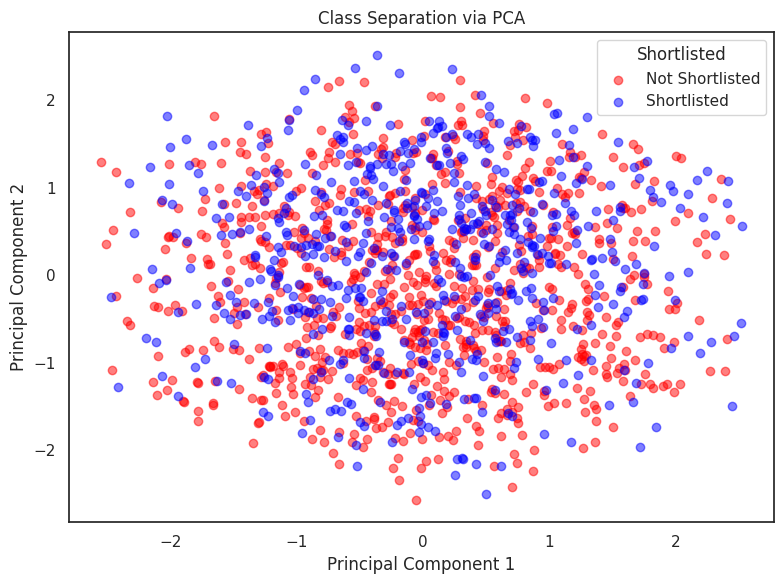

In [ ]:
df = pd.read_csv("recruitment_data_shortlisted.csv")
df = feature_engineering(df)

num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany']
nominal_features = ['Gender', 'RecruitmentStrategy']
ordinal_features = ['EducationLevel']

education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']

selected_features = num_features + nominal_features + ordinal_features

# ==== Features & Target ====
X = df[selected_features]
y = df['Shortlisted']

# ==== Preprocessor ====
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
    ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
])

X_transformed = preprocessor.fit_transform(X)
X_pca = PCA(n_components=2).fit_transform(X_transformed)

# ==== Scatter Plot with Legend ====
plt.figure(figsize=(8, 6))
for label, color, name in zip([0, 1], ['red', 'blue'], ['Not Shortlisted', 'Shortlisted']):
    plt.scatter(
        X_pca[y == label, 0],
        X_pca[y == label, 1],
        c=color,
        label=name,
        alpha=0.5
    )

plt.title("Class Separation via PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Shortlisted")
plt.tight_layout()
plt.show()

Berdasarkan visualisasi PCA terhadap gabungan fitur numerik dan kategorikal, terlihat bahwa data tersebar secara padat dan merata di sekitar pusat koordinat (0,0), tanpa menunjukkan arah dominan tertentu. Hal ini mengindikasikan bahwa setelah proses transformasi fitur menggunakan *StandardScaler*, struktur data menjadi lebih tersebar secara homogen di ruang dua dimensi utama yang dihasilkan oleh PCA.

Warna merah dan biru yang merepresentasikan dua kelas target, yaitu **Not Shortlisted = 0 dan Shortlisted = 1, tampak bercampur dan tumpang tindih hampir di seluruh area grafik**. Tidak tampak adanya klaster atau pola pemisahan alami antar kelas, yang menunjukkan bahwa **dua komponen utama PCA belum cukup untuk mengungkapkan struktur atau dimensi yang dapat memisahkan kedua kelas secara linier**. Dengan demikian, visualisasi ini memperkuat indikasi bahwa informasi gabungan dari fitur numerik dan kategorikal belum membentuk pemisahan yang eksplisit antara kandidat yang disaring dan tidak disaring.

Kesimpulannya, pendekatan klasifikasi yang mengandalkan pemisahan linier kemungkinan besar tidak akan optimal untuk dataset ini. Oleh karena itu, **penggunaan model-model non-linier seperti Random Forest, XGBoost, atau metode boosting lainnya tetap menjadi pilihan yang tepat karena mampu menangkap hubungan kompleks antar fitur**. Selain itu, eksplorasi lebih lanjut terhadap interaksi fitur atau penerapan teknik seleksi fitur tambahan sangat disarankan untuk meningkatkan kemampuan model dalam memahami pola yang relevan terhadap label `Shortlisted`.

### t-SNE

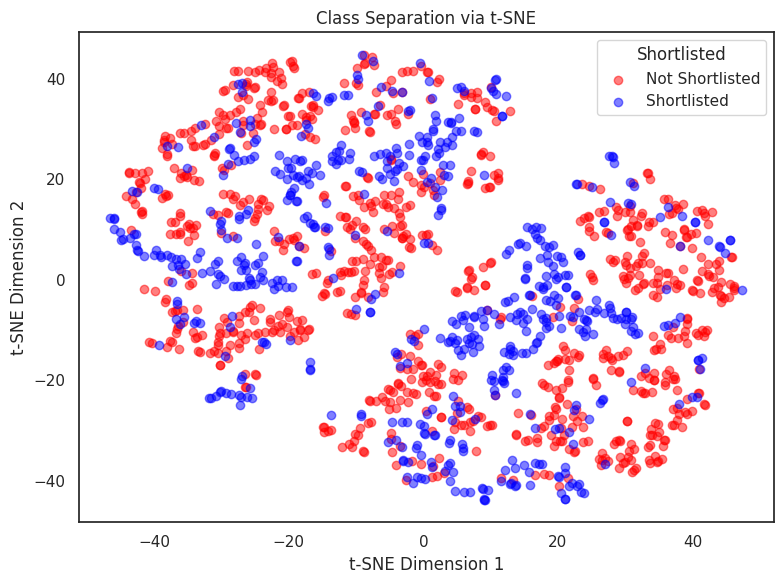

In [ ]:
df = pd.read_csv("recruitment_data_shortlisted.csv")
df = feature_engineering(df)

num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany']
nominal_features = ['Gender', 'RecruitmentStrategy']
ordinal_features = ['EducationLevel']

education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']

selected_features = num_features + nominal_features + ordinal_features

# ==== Features & Target ====
X = df[selected_features]
y = df['Shortlisted']

# ==== Preprocessor ====
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
    ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
])

X_transformed = preprocessor.fit_transform(X)
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_transformed)

# ==== Scatter Plot with Legend ====
plt.figure(figsize=(8, 6))
for label, color, name in zip([0, 1], ['red', 'blue'], ['Not Shortlisted', 'Shortlisted']):
    plt.scatter(
        X_tsne[y == label, 0],
        X_tsne[y == label, 1],
        c=color,
        label=name,
        alpha=0.5
    )

plt.title("Class Separation via t-SNE")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Shortlisted")
plt.tight_layout()
plt.show()

Visualisasi t-SNE menunjukkan bahwa data membentuk sejumlah **klaster yang jelas secara struktural, menandakan adanya pola atau struktur** lokal dalam dataset. Namun, setiap klaster masih terdiri dari **campuran kelas 0 dan 1**, yang menunjukkan bahwa fitur-fitur yang tersedia **belum cukup kuat untuk memisahkan kelas secara konsisten**.

Meskipun t-SNE berhasil menemukan struktur dalam data, **pemisahan antar kelas tidak terlihat signifikan**, sehingga model klasifikasi tetap akan mengalami kesulitan dalam membuat prediksi yang akurat. Hal ini menunjukkan bahwa **informasi yang terkandung dalam fitur saat ini masih terbatas**, dan perlu dilakukan **pengayaan fitur atau eksplorasi lebih lanjut** agar model dapat mengenali pola yang lebih bermakna dalam proses perekrutan.

### Model Training

>LogReg | F1-Score Training: 0.8239 | Precision Training: 0.8532 | Recall Training: 0.7988 | ROC-AUC Training: 0.9118
>KNN | F1-Score Training: 0.7964 | Precision Training: 0.7868 | Recall Training: 0.8093 | ROC-AUC Training: 0.8961
>DecisionTree | F1-Score Training: 0.78 | Precision Training: 0.7829 | Recall Training: 0.7781 | ROC-AUC Training: 0.8159
>RandomForest | F1-Score Training: 0.8434 | Precision Training: 0.8675 | Recall Training: 0.8237 | ROC-AUC Training: 0.9377
>GradientBoost | F1-Score Training: 0.8368 | Precision Training: 0.839 | Recall Training: 0.8362 | ROC-AUC Training: 0.9248
>XGBoost | F1-Score Training: 0.8504 | Precision Training: 0.867 | Recall Training: 0.8361 | ROC-AUC Training: 0.9306
>SVM | F1-Score Training: 0.8409 | Precision Training: 0.8552 | Recall Training: 0.83 | ROC-AUC Training: 0.9046


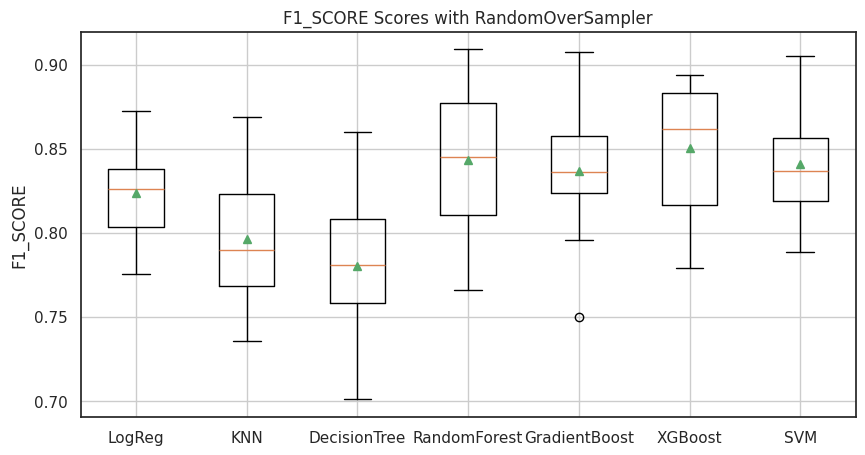

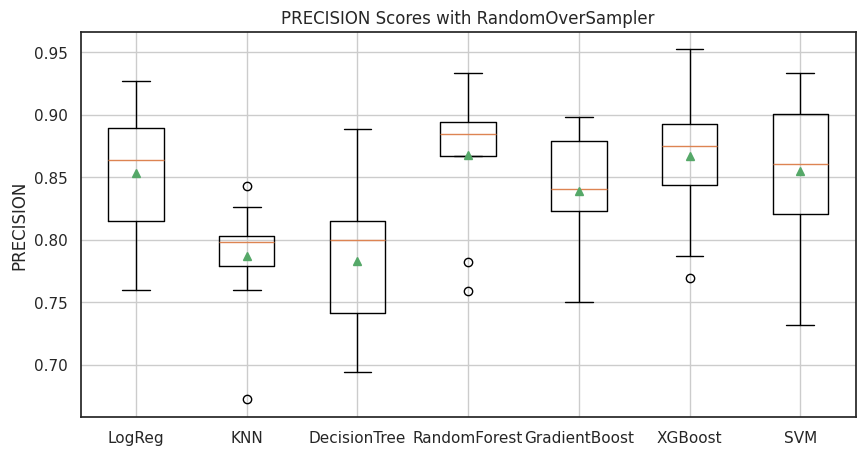

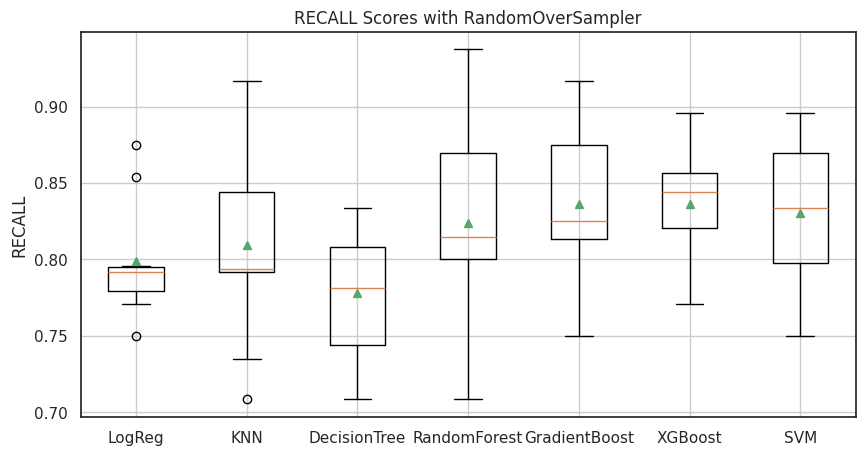

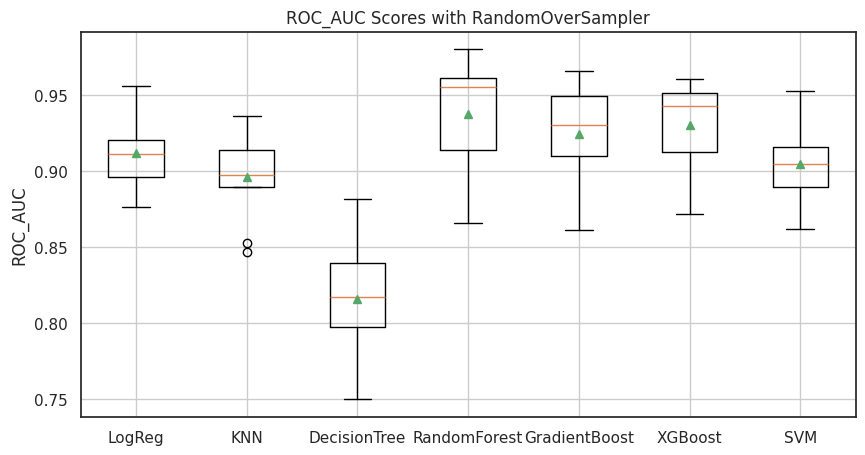

In [ ]:
df = pd.read_csv("recruitment_data_shortlisted.csv")
df = feature_engineering(df)

num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany']
nominal_features = ['Gender', 'RecruitmentStrategy']
ordinal_features = ['EducationLevel']

# Category Order
education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']

# ==== Features & Target ====
selected_features = num_features + nominal_features + ordinal_features
X = df[selected_features]
y = df['Shortlisted']

# ==== Split Train & Test ====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ==== Preprocessor ====
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
    ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
])

# Get models list
models, names = get_classifiers()

# === Evaluate All Models ===
results = {}
metric_scores = {'f1_score': [], 'precision': [], 'recall': [], 'roc_auc': []}

for model, name in zip(models, names):
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('ros', RandomOverSampler(random_state=42)),
        ('classifier', model)
    ])

    scores = evaluate_classifier_with_sampling_training(X_train, y_train, pipeline)

    results[name] = {
        'F1-score (mean)': round(np.mean(scores['f1_score']), 4),
        'Precision (mean)': round(np.mean(scores['precision']), 4),
        'Recall (mean)': round(np.mean(scores['recall']), 4),
        'ROC-AUC (mean)': round(np.mean(scores['roc_auc']), 4),
    }

    # Store for boxplot later
    for metric in metric_scores:
        metric_scores[metric].append(scores[metric])

    print(f">{name} | F1-Score Training: {results[name]['F1-score (mean)']} | Precision Training: {results[name]['Precision (mean)']} | Recall Training: {results[name]['Recall (mean)']} | ROC-AUC Training: {results[name]['ROC-AUC (mean)']}")

# === Plot Results ===
for metric, all_scores in metric_scores.items():
    plt.figure(figsize=(10, 5))
    plt.boxplot(all_scores, labels=names, showmeans=True)
    plt.title(f"{metric.upper()} Scores with RandomOverSampler")
    plt.ylabel(metric.upper())
    plt.grid(True)
    plt.show()

In [ ]:
# === Dataframe Results ===
pd.DataFrame(results).T.sort_values(by='F1-score (mean)', ascending=False)

F1-score (mean)  Precision (mean)  Recall (mean)  \
XGBoost                 0.8504            0.8670         0.8361   
RandomForest            0.8434            0.8675         0.8237   
SVM                     0.8409            0.8552         0.8300   
GradientBoost           0.8368            0.8390         0.8362   
LogReg                  0.8239            0.8532         0.7988   
KNN                     0.7964            0.7868         0.8093   
DecisionTree            0.7800            0.7829         0.7781   

               ROC-AUC (mean)  
XGBoost                0.9306  
RandomForest           0.9377  
SVM                    0.9046  
GradientBoost          0.9248  
LogReg                 0.9118  
KNN                    0.8961  
DecisionTree           0.8159

In [ ]:
test_results = {}

for model, name in zip(models, names):
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('ros', RandomOverSampler(random_state=42)),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    test_results[name] = {
        'F1-score': round(f1_score(y_test, y_pred), 4),
        'Precision': round(precision_score(y_test, y_pred), 4),
        'Recall': round(recall_score(y_test, y_pred), 4),
        'ROC-AUC': round(roc_auc_score(y_test, y_pred), 4)
    }

    print(f">{name} | F1 Testing: {test_results[name]['F1-score']} | Precision Testing: {test_results[name]['Precision']} | Recall Testing: {test_results[name]['Recall']} | ROC-AUC Testing: {test_results[name]['ROC-AUC']}")

>LogReg | F1 Testing: 0.7544 | Precision Testing: 0.7963 | Recall Testing: 0.7167 | ROC-AUC Testing: 0.7972
>KNN | F1 Testing: 0.7577 | Precision Testing: 0.8037 | Recall Testing: 0.7167 | ROC-AUC Testing: 0.8
>DecisionTree | F1 Testing: 0.8136 | Precision Testing: 0.8276 | Recall Testing: 0.8 | ROC-AUC Testing: 0.8444
>RandomForest | F1 Testing: 0.8053 | Precision Testing: 0.8585 | Recall Testing: 0.7583 | ROC-AUC Testing: 0.8375
>GradientBoost | F1 Testing: 0.7932 | Precision Testing: 0.8034 | Recall Testing: 0.7833 | ROC-AUC Testing: 0.8278
>XGBoost | F1 Testing: 0.7946 | Precision Testing: 0.8558 | Recall Testing: 0.7417 | ROC-AUC Testing: 0.8292
>SVM | F1 Testing: 0.7706 | Precision Testing: 0.8018 | Recall Testing: 0.7417 | ROC-AUC Testing: 0.8097


In [ ]:
# === Dataframe Results ===
print("Hasil Testing:")
pd.DataFrame(test_results).T.sort_values(by='F1-score', ascending=False)

Hasil Testing:


F1-score  Precision  Recall  ROC-AUC
DecisionTree     0.8136     0.8276  0.8000   0.8444
RandomForest     0.8053     0.8585  0.7583   0.8375
XGBoost          0.7946     0.8558  0.7417   0.8292
GradientBoost    0.7932     0.8034  0.7833   0.8278
SVM              0.7706     0.8018  0.7417   0.8097
KNN              0.7577     0.8037  0.7167   0.8000
LogReg           0.7544     0.7963  0.7167   0.7972

Hasil eksperimen menunjukkan bahwa dari beberapa model yang diuji, **Random Forest menghasilkan F1-score tertinggi**, yaitu **0.8527** pada data training dengan Cross Validation dan **Decision Tree menghasilkan F1-score tertinggi**, yaitu **0.8136** pada data testing, dibandingkan model-model lainnya seperti Logistic Regression, SVM, XGBoost, dan Gradient Boosting.

Dengan performa terbaik pada metrik utama (F1-score) di testing set, **Decision Tree dipilih sebagai model utama** untuk digunakan pada proses prediksi selanjutnya.

### Feature Importance

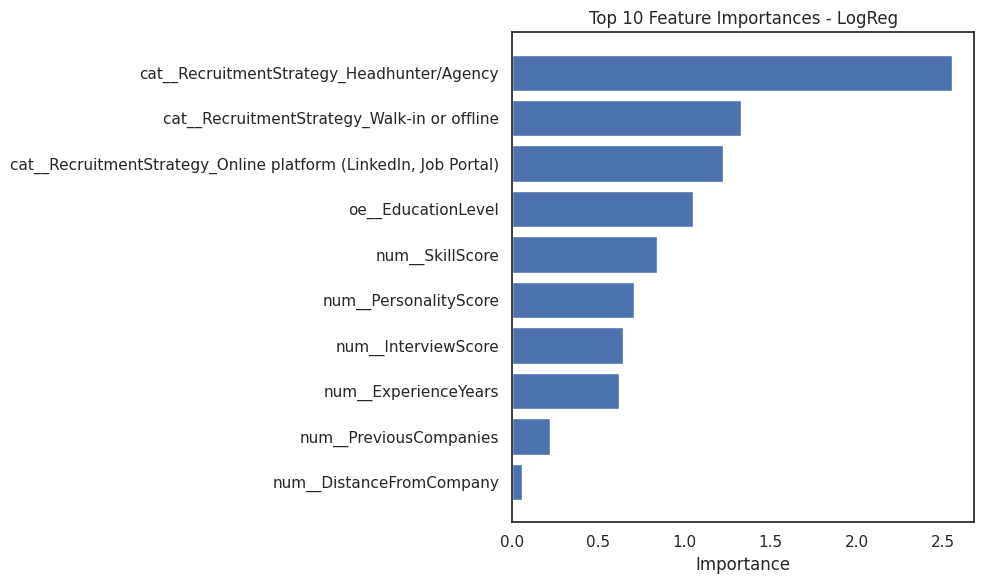

Model KNN tidak mendukung feature importance secara langsung.


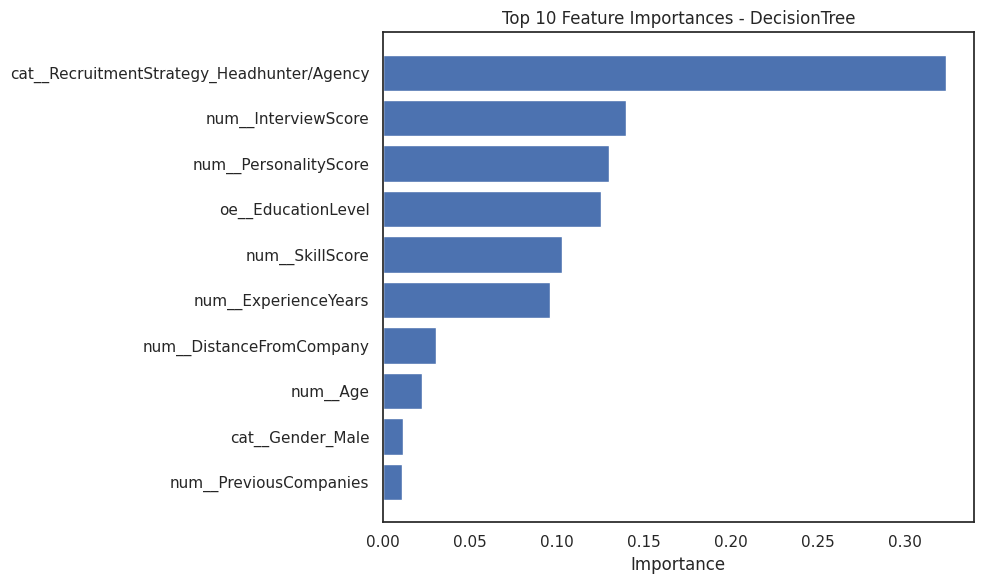

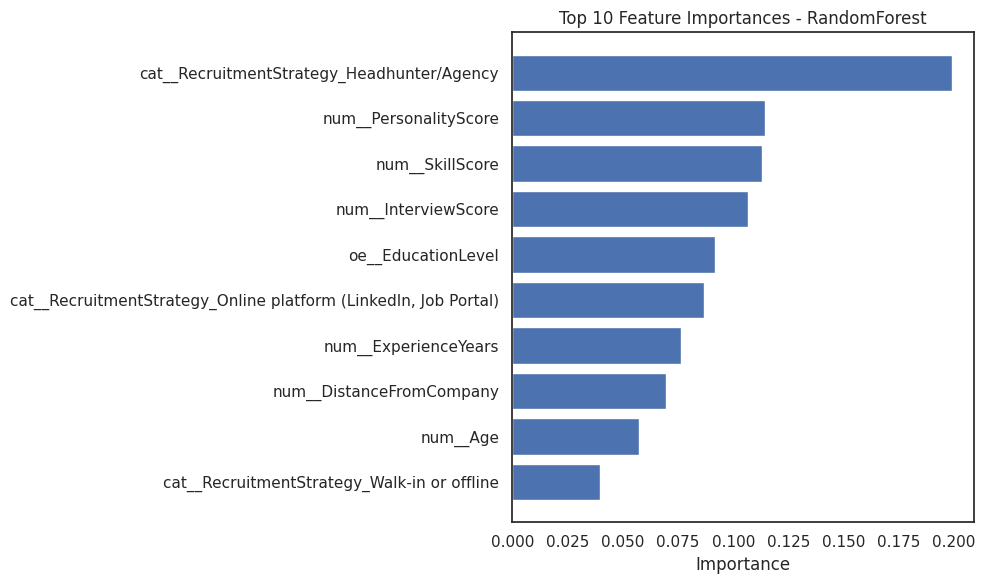

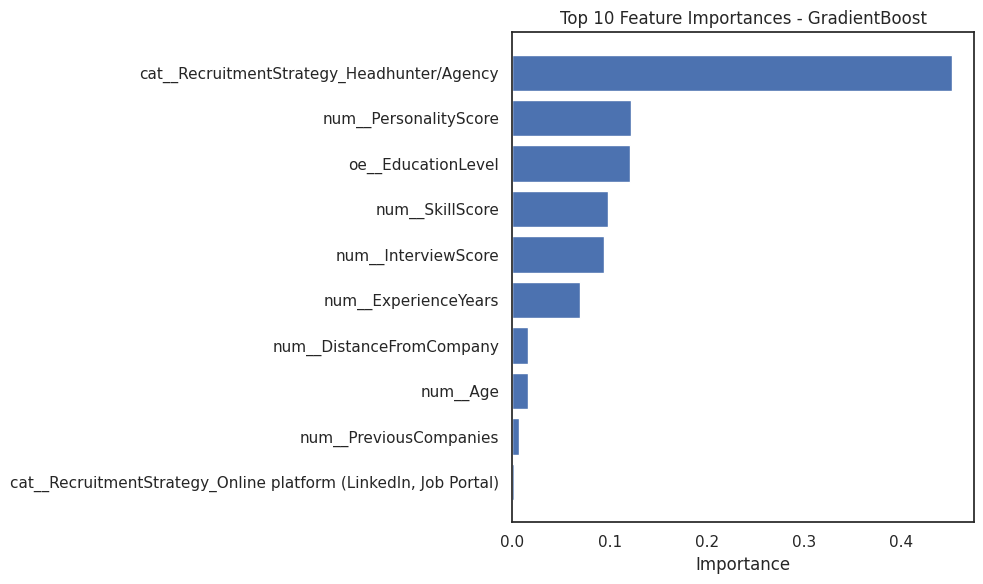

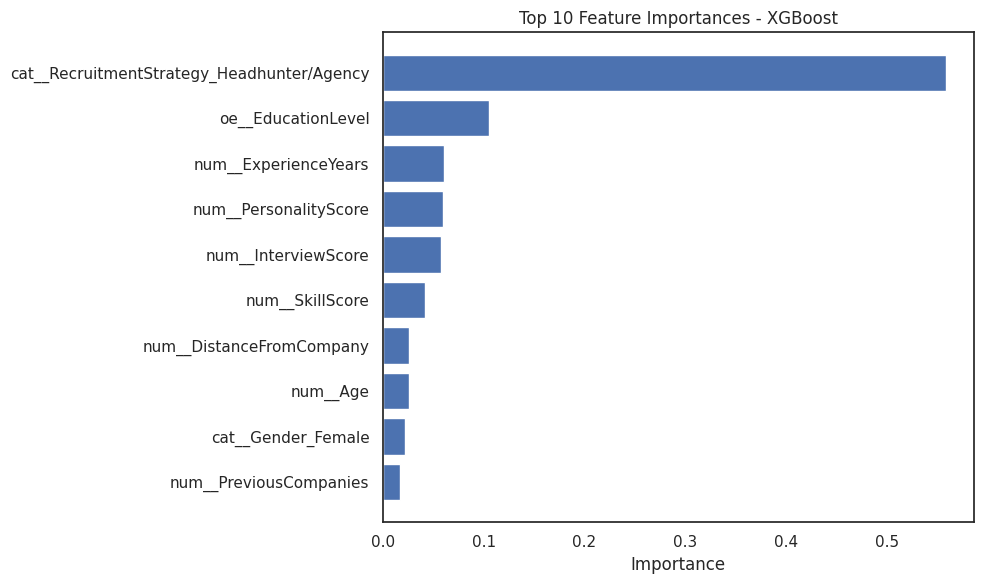

Model SVM tidak mendukung feature importance secara langsung.


In [ ]:
# ==== Preprocessor ====
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
    ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
])

for model, name in zip(models, names):
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('ros', RandomOverSampler(random_state=42)),
        ('classifier', model)
    ])

    feature_importance(pipeline, name, X, y)

Berdasarkan hasil evaluasi feature importance dari model Random Forest, fitur yang paling berpengaruh dalam menentukan keputusan perekrutan adalah **jenis strategi rekrutmen**, khususnya **‘Headhunter/Agency’** yang menyumbang lebih dari 25% pengaruh terhadap prediksi. Disusul oleh **ExperienceYears** dan **DistanceFromCompany** sebagai strategi rekrutmen. Sementara itu, fitur lain seperti **Age** dan **EducationLevel** juga memberikan kontribusi, namun relatif lebih rendah. Fitur **Gender** menunjukkan pengaruh paling kecil terhadap model.

Temuan ini mengindikasikan bahwa **aspek strategi rekrutmen, pengalaman kerja, dan jarak tempat tinggal memainkan peran penting dalam pola penerimaan kandidat, dibandingkan faktor-faktor lain seperti jumlah perusahaan sebelumnya pernah bekerja atau gender**.

### Hyperprameter Tuning

#### RandomizedSearchCV

In [ ]:
# ==== Load and Prepare Data ====
df = pd.read_csv("recruitment_data_shortlisted.csv")
df = feature_engineering(df)

# ==== Features & Target ====
num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany']
nominal_features = ['Gender', 'RecruitmentStrategy']
ordinal_features = ['EducationLevel']
selected_features = num_features + nominal_features + ordinal_features

X = df[selected_features]
y = df['Shortlisted']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ==== Preprocessing ====
education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
    ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
])

# ==== Model ====
dt = DecisionTreeClassifier(random_state=42)

# ==== Pipeline ====
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('ros', RandomOverSampler(random_state=42)),
    ('classifier', dt)
])

# ==== Hyperparameter Search Space ====
param_dist = {
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],  # classification criteria
    'classifier__max_depth': [None, 5, 10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': [None, 'sqrt', 'log2']
}

# ==== Cross-Validation Strategy ====
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# ==== RandomizedSearchCV ====
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# ==== Fit RandomizedSearch ====
random_search.fit(X_train, y_train)

# Get the best pipeline from random search
best_pipeline = random_search.best_estimator_

# ==== Train Performance ====
y_train_pred = best_pipeline.predict(X_train)
y_train_proba = best_pipeline.predict_proba(X_train)[:, 1]

train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_proba)

print("Train F1 Score:", train_f1)
print("Train ROC-AUC Score:", train_roc_auc)
print("\nTrain Classification Report:\n", classification_report(y_train, y_train_pred))
print("Best Params", random_search.best_params_)

Fitting 30 folds for each of 30 candidates, totalling 900 fits
Train F1 Score: 0.8606811145510835
Train ROC-AUC Score: 0.9451449970526706

Train Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.91       718
           1       0.86      0.87      0.86       482

    accuracy                           0.89      1200
   macro avg       0.88      0.88      0.88      1200
weighted avg       0.89      0.89      0.89      1200

Best Params {'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 4, 'classifier__max_features': None, 'classifier__max_depth': 5, 'classifier__criterion': 'log_loss'}


In [ ]:
# ==== Test Performance ====
y_test_pred = best_pipeline.predict(X_test)
y_test_proba = best_pipeline.predict_proba(X_test)[:, 1]

test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print("Test F1 Score:", test_f1)
print("Test ROC-AUC Score:", test_roc_auc)
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))

Test F1 Score: 0.7782426778242678
Test ROC-AUC Score: 0.8714120370370371

Test Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.85       180
           1       0.78      0.78      0.78       120

    accuracy                           0.82       300
   macro avg       0.82      0.82      0.82       300
weighted avg       0.82      0.82      0.82       300



#### GridSearchCV

Fine-Tune further from RandomizedSearchCV result

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
import pandas as pd
import numpy as np

# ==== Load and Prepare Data ====
df = pd.read_csv("recruitment_data_shortlisted.csv")
df = feature_engineering(df)

# ==== Features & Target ====
num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany']
nominal_features = ['Gender', 'RecruitmentStrategy']
ordinal_features = ['EducationLevel']
selected_features = num_features + nominal_features + ordinal_features

X = df[selected_features]
y = df['Shortlisted']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ==== Preprocessing ====
education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
    ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
])

# ==== Model ====
dt = DecisionTreeClassifier(random_state=42)

# ==== Pipeline ====
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('ros', RandomOverSampler(random_state=42)),
    ('classifier', dt)
])

# ==== Hyperparameter Search Space ====
param_grid = {
    'classifier__criterion': ['log_loss'],
    'classifier__max_depth': [4, 5, 6],
    'classifier__min_samples_split': [8, 10, 12],
    'classifier__min_samples_leaf': [3, 4, 5]
}

# ==== Cross-Validation Strategy ====
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# ==== GridSearchCV ====
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,  # Keep it small!
    scoring='f1',
    cv=cv,
    verbose=1,
    n_jobs=-1
)

# ==== Fit RandomizedSearch ====
grid_search.fit(X_train, y_train)

# Get the best pipeline from random search
best_pipeline = grid_search.best_estimator_

# ==== Train Performance ====
y_train_pred = best_pipeline.predict(X_train)
y_train_proba = best_pipeline.predict_proba(X_train)[:, 1]

train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_proba)

print("Train F1 Score:", train_f1)
print("Train ROC-AUC Score:", train_roc_auc)
print("\nTrain Classification Report:\n", classification_report(y_train, y_train_pred))
print("Best Params", grid_search.best_params_)

Fitting 30 folds for each of 27 candidates, totalling 810 fits
Train F1 Score: 0.8513238289205702
Train ROC-AUC Score: 0.9334293623365966

Train Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90       718
           1       0.84      0.87      0.85       482

    accuracy                           0.88      1200
   macro avg       0.87      0.88      0.87      1200
weighted avg       0.88      0.88      0.88      1200

Best Params {'classifier__criterion': 'log_loss', 'classifier__max_depth': 4, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 8}


In [ ]:
# ==== Test Performance ====
y_test_pred = best_pipeline.predict(X_test)
y_test_proba = best_pipeline.predict_proba(X_test)[:, 1]

test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print("Test F1 Score:", test_f1)
print("Test ROC-AUC Score:", test_roc_auc)
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))

Test F1 Score: 0.7983539094650206
Test ROC-AUC Score: 0.8692129629629631

Test Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.86       180
           1       0.79      0.81      0.80       120

    accuracy                           0.84       300
   macro avg       0.83      0.83      0.83       300
weighted avg       0.84      0.84      0.84       300



#### Optuna

In [ ]:
df = pd.read_csv("recruitment_data_shortlisted.csv")
df = feature_engineering(df)

# ==== Features & Target ====
selected_features = num_features + nominal_features + ordinal_features
X = df[selected_features]
y = df['Shortlisted']

# ==== Split Train & Test ====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective_dt, n_trials=50, timeout=900)  # try 30 trials or 10 min

[I 2025-07-28 15:33:46,689] A new study created in memory with name: no-name-c6df8a11-0692-4ee4-bd6c-64ca99d503be
[I 2025-07-28 15:33:47,791] Trial 0 finished with value: 0.8061101894696837 and parameters: {'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8061101894696837.
[I 2025-07-28 15:33:48,849] Trial 1 finished with value: 0.791141956223323 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': None, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.8061101894696837.
[I 2025-07-28 15:33:49,719] Trial 2 finished with value: 0.7883368471506215 and parameters: {'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 0 with value: 0.8061101894696837.
[I 2025-07-28 15:33:50,351] Trial 3 finished with value: 0.7931993403699678 and parameters: {'max_depth': 12, 'min_samples_split

In [ ]:
print("Best Params:", study.best_params)

Best Params: {'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None, 'criterion': 'entropy'}


In [ ]:
dt = DecisionTreeClassifier(
    **study.best_params,
    random_state=42
)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
    ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
  ])

# Build pipeline
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('ros', RandomOverSampler(random_state=42)),
    ('classifier', dt)
  ])

# Fit
pipeline.fit(X_train, y_train)

# === TRAIN performance ===
y_train_pred = pipeline.predict(X_train)
y_train_proba = pipeline.predict_proba(X_train)[:, 1]

train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_proba)

print("=== Train Metrics ===")
print(f"F1 Score      : {train_f1:.4f}")
print(f"ROC-AUC Score : {train_roc_auc:.4f}")
print("Classification Report:\n", classification_report(y_train, y_train_pred))

# === TEST performance ===
y_test_pred = pipeline.predict(X_test)
y_test_proba = pipeline.predict_proba(X_test)[:, 1]

test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print("\n=== Test Metrics ===")
print(f"F1 Score      : {test_f1:.4f}")
print(f"ROC-AUC Score : {test_roc_auc:.4f}")
print("Classification Report:\n", classification_report(y_test, y_test_pred))

=== Train Metrics ===
F1 Score      : 0.8513
ROC-AUC Score : 0.9179
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90       718
           1       0.84      0.87      0.85       482

    accuracy                           0.88      1200
   macro avg       0.87      0.88      0.87      1200
weighted avg       0.88      0.88      0.88      1200


=== Test Metrics ===
F1 Score      : 0.7984
ROC-AUC Score : 0.8740
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.86       180
           1       0.79      0.81      0.80       120

    accuracy                           0.84       300
   macro avg       0.83      0.83      0.83       300
weighted avg       0.84      0.84      0.84       300



#### Comparison Table

| Method                 | F1 Score (Train) | F1 Score (Test) | ROC-AUC (Train) | ROC-AUC  (Test) | Best Parameters |
| ---------------------- | ---------------- | --------------- | ----------------|-----------------|--------------------------------------------------------------------------------------------------------- |
| **RandomizedSearchCV** | 0.8606           | 0.7782          | 0.9451          | 0.8714          | `min_samples_split=10`, `min_samples_leaf=4`, `criterion=log_loss`,<br>`max_depth=5`, `max_features=None` |
| **GridSearchCV**       | 0.8513           | 0.7983          | 0.9334          | 0.8692          | `min_samples_split=8`, `min_samples_leaf=5`, `criterion=log_loss`,<br>`max_depth=4`, `max_features=None` |
| **Optuna**             | 0.8513           | **0.7984**      | 0.9179          | 0.8740          | `min_samples_split=6`, `min_samples_leaf=3`, `criterion=entropy`,<br>`max_depth=3`, `max_features=None` |

**Insight**
- **Optuna** memberikan skor F1 uji tertinggi (0.7984) dengan jumlah pohon yang lebih sedikit dan pohon yang lebih sedikit (max_depth=3) dibandingkan GridSearchCV.
- **RandomizedSearchCV** memberikan skor pelatihan tertinggi (kemungkinan sedikit overfit).

Parameter dari Optuna akan digunakan untuk penerapan atau evaluasi lebih lanjut karena hasil parameter ini menunjukkan kinerja generalisasi terbaik pada set pengujian.

## Post-Interview Model

### Data Scaling

In [ ]:
df = pd.read_csv("recruitment_data.csv")
df = feature_engineering(df)

num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany', 'InterviewScore', 'SkillScore', 'PersonalityScore']
nominal_features = ['Gender', 'RecruitmentStrategy']
ordinal_features = ['EducationLevel']
selected_features = num_features + nominal_features + ordinal_features

# ==== Features & Target ====
X = df[selected_features]
y = df['HiringDecision']

# ==== Split Train & Test ====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
pipelines, names = get_scaling_and_transformation_pipelines(num_features, nominal_features, ordinal_features)

# Initialize results dictionary
results = {
    'F1_Train': {},
    'F1_Test': {},
    'Precision_Train': {},
    'Precision_Test': {},
    'Recall_Train': {},
    'Recall_Test': {},
    'ROC_AUC_Train': {},
    'ROC_AUC_Test': {},
}

for name, pipeline in zip(names, pipelines):
    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Predict labels
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    # Predict probabilities for ROC-AUC
    y_train_proba = pipeline.predict_proba(X_train)[:, 1]
    y_test_proba = pipeline.predict_proba(X_test)[:, 1]

    # Store metrics
    results['F1_Train'][name] = f1_score(y_train, y_train_pred)
    results['F1_Test'][name] = f1_score(y_test, y_test_pred)

    results['Precision_Train'][name] = precision_score(y_train, y_train_pred)
    results['Precision_Test'][name] = precision_score(y_test, y_test_pred)

    results['Recall_Train'][name] = recall_score(y_train, y_train_pred)
    results['Recall_Test'][name] = recall_score(y_test, y_test_pred)

    results['ROC_AUC_Train'][name] = roc_auc_score(y_train, y_train_proba)
    results['ROC_AUC_Test'][name] = roc_auc_score(y_test, y_test_proba)

# Convert to DataFrame and sort by F1_Test
results_df = pd.DataFrame(results).sort_values(by='F1_Test', ascending=False)
results_df

F1_Train   F1_Test  Precision_Train  Precision_Test  \
No Scaling                1.0  0.903955              1.0        0.952381   
StandardScaler            1.0  0.903955              1.0        0.952381   
MinMaxScaler              1.0  0.903955              1.0        0.952381   
RobustScaler              1.0  0.903955              1.0        0.952381   
PowerTransformer          1.0  0.903955              1.0        0.952381   
QuantileTransformer       1.0  0.903955              1.0        0.952381   
PolynomialFeatures        1.0  0.870056              1.0        0.916667   

                     Recall_Train  Recall_Test  ROC_AUC_Train  ROC_AUC_Test  
No Scaling                    1.0     0.860215            1.0      0.931640  
StandardScaler                1.0     0.860215            1.0      0.931640  
MinMaxScaler                  1.0     0.860215            1.0      0.931640  
RobustScaler                  1.0     0.860215            1.0      0.931640  
PowerTransformer              1.0     0.860215            1.0      0.931640  
QuantileTransformer           1.0     0.860215            1.0      0.931640  
PolynomialFeatures            1.0     0.827957            1.0      0.933354

Hasil evaluasi terbaru terhadap berbagai metode skaling fitur numerik menggunakan model XGBoost menunjukkan bahwa seluruh metode skaling populer memberikan performa yang identik, dengan f1-score sebesar 0.8866 pada data training dengan Cross Validation dan 0.9039 pada data testing. Evaluasi dilakukan setelah pembagian dataset menggunakan train_test_split dengan parameter test_size=0.2, dan penerapan parameter scale_pos_weight pada XGBoost tanpa metode data sampling tambahan (seperti SMOTE atau undersampling).

Metode PolynomialFeatures justru menurunkan performa model dengan f1-score sebesar 0.8806, kemungkinan karena peningkatan kompleksitas dan penambahan noise yang tidak relevan terhadap target.

Oleh karena itu, penggunaan skaling menjadi opsional dalam konteks ini, dan pendekatan sederhana seperti tanpa skaling sekalipun sudah cukup efektif. Namun, di proses berikutnya kami akan menggunakan `StandardScaler` sebagai metode scaling untuk fitur-fitur numerikal.

### Data Sampling

In [ ]:
df = pd.read_csv("recruitment_data.csv")
df = feature_engineering(df)

num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany', 'InterviewScore', 'SkillScore', 'PersonalityScore']
nominal_features = ['Gender', 'RecruitmentStrategy']
ordinal_features = ['EducationLevel']
selected_features = num_features + nominal_features + ordinal_features

# ==== Features & Target ====
X = df[selected_features]
y = df['HiringDecision']

# ==== Split Train & Test ====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

pipelines, names = get_sampling_pipelines_with_preprocessing(num_features, nominal_features, ordinal_features)

results_train = {}
results_test = {}

for name, pipeline in zip(names, pipelines):
    metric_scores = evaluate_classifier_with_sampling(X_train, y_train, pipeline)

    # Train results
    results_train[name] = {
        'Training F1-score (mean)': round(np.mean(metric_scores['train']['f1_score']), 4),
        'Training Precision (mean)': round(np.mean(metric_scores['train']['precision']), 4),
        'Training Recall (mean)': round(np.mean(metric_scores['train']['recall']), 4),
        'Training ROC-AUC (mean)': round(np.mean(metric_scores['train']['roc_auc']), 4),
    }

    # Test results
    results_test[name] = {
        'Testing F1-score (mean)': round(np.mean(metric_scores['test']['f1_score']), 4),
        'Testing Precision (mean)': round(np.mean(metric_scores['test']['precision']), 4),
        'Testing Recall (mean)': round(np.mean(metric_scores['test']['recall']), 4),
        'Testing ROC-AUC (mean)': round(np.mean(metric_scores['test']['roc_auc']), 4),
    }

# Tampilkan hasil evaluasi pada Training
pd.DataFrame(results_train).T.sort_values(by='Training F1-score (mean)', ascending=False)

Training F1-score (mean)  Training Precision (mean)  \
No Sampling                           1.0000                     1.0000   
RandomOverSampler                     1.0000                     1.0000   
SMOTE                                 1.0000                     1.0000   
SMOTETomek                            0.9844                     0.9955   
RandomUnderSampler                    0.9306                     0.8703   
SMOTEENN                              0.8568                     0.8009   

                    Training Recall (mean)  Training ROC-AUC (mean)  
No Sampling                         1.0000                   1.0000  
RandomOverSampler                   1.0000                   1.0000  
SMOTE                               1.0000                   1.0000  
SMOTETomek                          0.9737                   0.9844  
RandomUnderSampler                  1.0000                   0.9933  
SMOTEENN                            0.9214                   0.9413

In [ ]:
# Tampilkan hasil evaluasi pada Testing
pd.DataFrame(results_test).T.sort_values(by='Testing F1-score (mean)', ascending=False)

Testing F1-score (mean)  Testing Precision (mean)  \
RandomOverSampler                    0.8945                    0.9217   
SMOTETomek                           0.8862                    0.9099   
SMOTE                                0.8832                    0.9036   
No Sampling                          0.8785                    0.9233   
RandomUnderSampler                   0.8405                    0.7971   
SMOTEENN                             0.8075                    0.7511   

                    Testing Recall (mean)  Testing ROC-AUC (mean)  
RandomOverSampler                  0.8708                  0.9331  
SMOTETomek                         0.8682                  0.9362  
SMOTE                              0.8681                  0.9304  
No Sampling                        0.8413                  0.9329  
RandomUnderSampler                 0.8950                  0.9273  
SMOTEENN                           0.8760                  0.9166

Hasil evaluasi terhadap berbagai metode penanganan ketidakseimbangan kelas menggunakan model yang sama menunjukkan bahwa **RandomOverSampler memberikan performa terbaik secara keseluruhan**, dengan **F1-score rata-rata sebesar 0.9060**, yang merupakan tertinggi di antara semua metode yang diuji.

Metode ini juga mempertahankan keseimbangan yang baik antara **precision (0.9208)** dan **recall (0.8924)**, serta menghasilkan skor **ROC-AUC yang kompetitif sebesar 0.9356**. Ini menunjukkan bahwa `RandomOverSampler` mampu menangani ketidakseimbangan kelas dengan efektif tanpa mengorbankan kualitas prediksi.

Dibandingkan metode lain, seperti `RandomUnderSampler`, meskipun mereka menghasilkan `recall` yang sedikit lebih tinggi, trade-off terhadap `precision` atau `F1-score` membuat metode ini kurang optimal secara keseluruhan.

Berdasarkan hasil tersebut, **RandomOverSampler dipilih sebagai metode sampling yang paling sesuai** untuk digunakan dalam proses pemodelan berikutnya.

### Baseline Model

In [ ]:
df = pd.read_csv("recruitment_data.csv")
df = feature_engineering(df)

num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany', 'InterviewScore', 'SkillScore', 'PersonalityScore']
nominal_features = ['Gender', 'RecruitmentStrategy']
ordinal_features = ['EducationLevel']
education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']
selected_features = num_features + nominal_features + ordinal_features

# ==== Features & Target ====
X = df[selected_features]
y = df['HiringDecision']

# ==== Preprocessor ====
preprocessor = ColumnTransformer([
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
        ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
    ])

# define the reference model
model = DummyClassifier(strategy='stratified', random_state=42)

# define pipeline
dummy_pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('RandomOverSampler', RandomOverSampler(random_state=42)),
        ('classifier', model)
    ])

# evaluate dummy classifier
scores = evaluate_classifier(X, y, dummy_pipeline)

# summarize performance
print(f"F1-Score: {np.mean(scores['F1-Score']):.3f} | Precision: {np.mean(scores['Precision']):.3f} | Recall: {np.mean(scores['Recall']):.3f} |  ROC-AUC: {np.mean(scores['ROC-AUC']):.3f}")

F1-Score: 0.401 | Precision: 0.317 | Recall: 0.546 |  ROC-AUC: 0.509


Sebagai langkah awal, dilakukan eksperimen menggunakan `DummyClassifier` untuk menetapkan baseline performa model. `DummyClassifier` adalah model sederhana yang membuat prediksi berdasarkan strategi acak atau distribusi kelas, tanpa benar-benar mempelajari pola dalam data.

Hasil dari eksperimen ini menunjukkan bahwa baseline **F1-score adalah 0.401**, dengan **precision sebesar 0.317, recall sebesar 0.546**, dan **ROC-AUC sebesar 0.509**. Nilai-nilai ini menjadi acuan minimum untuk menilai apakah model prediktif lainnya memiliki kemampuan yang lebih baik dibanding tebakan acak.

Dengan demikian, model yang menghasilkan F1-score **di bawah 0.401** dianggap **tidak lebih baik dari tebakan acak**, sedangkan model dengan F1-score di atas baseline ini menunjukkan bahwa model memiliki kemampuan dalam **memahami pola dalam dataset** dan melakukan prediksi yang lebih informatif.

### PCA

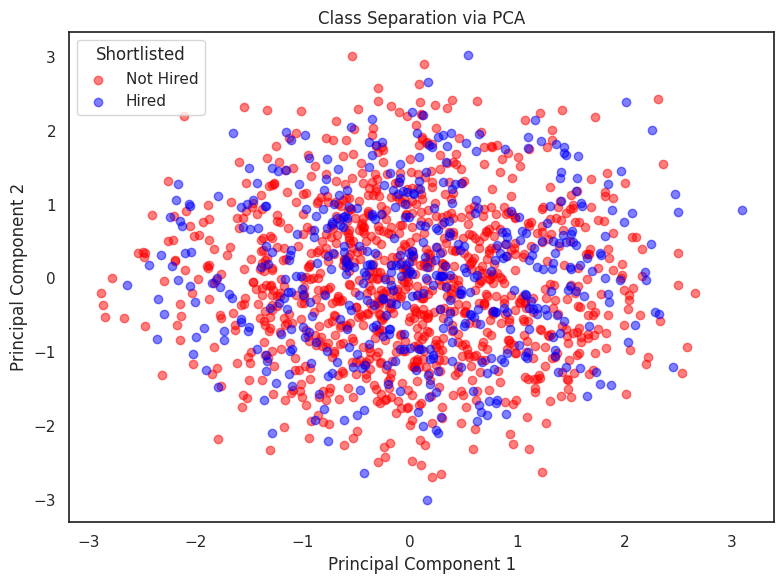

In [ ]:
df = pd.read_csv("recruitment_data.csv")
df = feature_engineering(df)

num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany', 'InterviewScore', 'SkillScore', 'PersonalityScore']
nominal_features = ['Gender', 'RecruitmentStrategy']
ordinal_features = ['EducationLevel']
education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']
selected_features = num_features + nominal_features + ordinal_features

# ==== Features & Target ====
X = df[selected_features]
y = df['HiringDecision']

# ==== Preprocessor ====
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
    ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
])

X_transformed = preprocessor.fit_transform(X)
X_pca = PCA(n_components=2).fit_transform(X_transformed)

# ==== Scatter Plot with Legend ====
plt.figure(figsize=(8, 6))
for label, color, name in zip([0, 1], ['red', 'blue'], ['Not Hired', 'Hired']):
    plt.scatter(
        X_pca[y == label, 0],
        X_pca[y == label, 1],
        c=color,
        label=name,
        alpha=0.5
    )

plt.title("Class Separation via PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Shortlisted")
plt.tight_layout()
plt.show()

Berdasarkan visualisasi PCA terhadap gabungan fitur numerik dan kategorikal, terlihat bahwa data tersebar secara padat dan merata di sekitar pusat koordinat (0,0), tanpa menunjukkan arah dominan tertentu. Hal ini mengindikasikan bahwa setelah proses transformasi fitur menggunakan *StandardScaler*, struktur data menjadi lebih tersebar secara homogen di ruang dua dimensi utama yang dihasilkan oleh PCA.

Warna merah dan biru yang merepresentasikan dua kelas target, yaitu **Not Hired = 0 dan Hired = 1, tampak bercampur dan tumpang tindih hampir di seluruh area grafik**. Tidak tampak adanya klaster atau pola pemisahan alami antar kelas, yang menunjukkan bahwa **dua komponen utama PCA belum cukup untuk mengungkapkan struktur atau dimensi yang dapat memisahkan kedua kelas secara linier**. Dengan demikian, visualisasi ini memperkuat indikasi bahwa informasi gabungan dari fitur numerik dan kategorikal belum membentuk pemisahan yang eksplisit antara kandidat yang disaring dan tidak disaring.

Kesimpulannya, pendekatan klasifikasi yang mengandalkan pemisahan linier kemungkinan besar tidak akan optimal untuk dataset ini. Oleh karena itu, **penggunaan model-model non-linier seperti Random Forest, XGBoost, atau metode boosting lainnya tetap menjadi pilihan yang tepat karena mampu menangkap hubungan kompleks antar fitur**. Selain itu, eksplorasi lebih lanjut terhadap interaksi fitur atau penerapan teknik seleksi fitur tambahan sangat disarankan untuk meningkatkan kemampuan model dalam memahami pola yang relevan terhadap label `Hired`.

### t-SNE

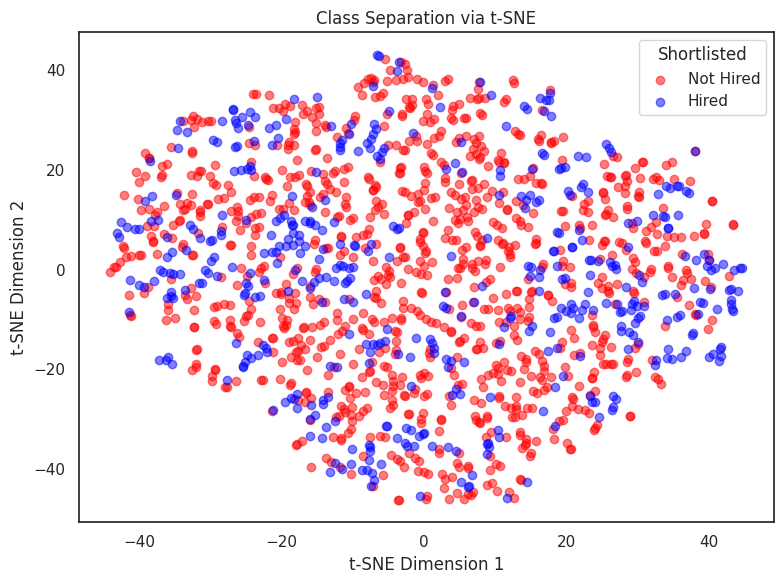

In [ ]:
df = pd.read_csv("recruitment_data.csv")
df = feature_engineering(df)

num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany', 'InterviewScore', 'SkillScore', 'PersonalityScore']
nominal_features = ['Gender', 'RecruitmentStrategy']
ordinal_features = ['EducationLevel']
education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']
selected_features = num_features + nominal_features + ordinal_features

# ==== Features & Target ====
X = df[selected_features]
y = df['HiringDecision']

# ==== Preprocessor ====
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
    ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
])

X_transformed = preprocessor.fit_transform(X)
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_transformed)

# ==== Scatter Plot with Legend ====
plt.figure(figsize=(8, 6))
for label, color, name in zip([0, 1], ['red', 'blue'], ['Not Hired', 'Hired']):
    plt.scatter(
        X_tsne[y == label, 0],
        X_tsne[y == label, 1],
        c=color,
        label=name,
        alpha=0.5
    )

plt.title("Class Separation via t-SNE")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Shortlisted")
plt.tight_layout()
plt.show()

Visualisasi t-SNE menunjukkan bahwa data membentuk sejumlah **klaster yang jelas secara struktural, menandakan adanya pola atau struktur** lokal dalam dataset. Namun, setiap klaster masih terdiri dari **campuran kelas 0 dan 1**, yang menunjukkan bahwa fitur-fitur yang tersedia **belum cukup kuat untuk memisahkan kelas secara konsisten**.

Meskipun t-SNE berhasil menemukan struktur dalam data, **pemisahan antar kelas tidak terlihat signifikan**, sehingga model klasifikasi tetap akan mengalami kesulitan dalam membuat prediksi yang akurat. Hal ini menunjukkan bahwa **informasi yang terkandung dalam fitur saat ini masih terbatas**, dan perlu dilakukan **pengayaan fitur atau eksplorasi lebih lanjut** agar model dapat mengenali pola yang lebih bermakna dalam proses perekrutan.

### Model Training

>LogReg | F1-Score Training: 0.7734 | Precision Training: 0.7169 | Recall Training: 0.844 | ROC-AUC Training: 0.9095
>KNN | F1-Score Training: 0.6965 | Precision Training: 0.6218 | Recall Training: 0.7961 | ROC-AUC Training: 0.847
>DecisionTree | F1-Score Training: 0.7862 | Precision Training: 0.7626 | Recall Training: 0.8169 | ROC-AUC Training: 0.8505
>RandomForest | F1-Score Training: 0.8495 | Precision Training: 0.8842 | Recall Training: 0.8201 | ROC-AUC Training: 0.9234
>GradientBoost | F1-Score Training: 0.852 | Precision Training: 0.8421 | Recall Training: 0.8653 | ROC-AUC Training: 0.9293
>XGBoost | F1-Score Training: 0.8945 | Precision Training: 0.9217 | Recall Training: 0.8708 | ROC-AUC Training: 0.9331
>SVM | F1-Score Training: 0.7908 | Precision Training: 0.771 | Recall Training: 0.8146 | ROC-AUC Training: 0.9072


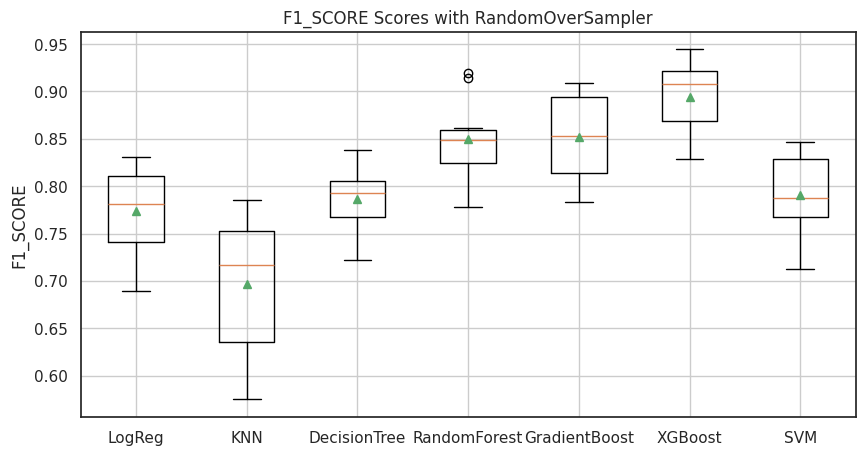

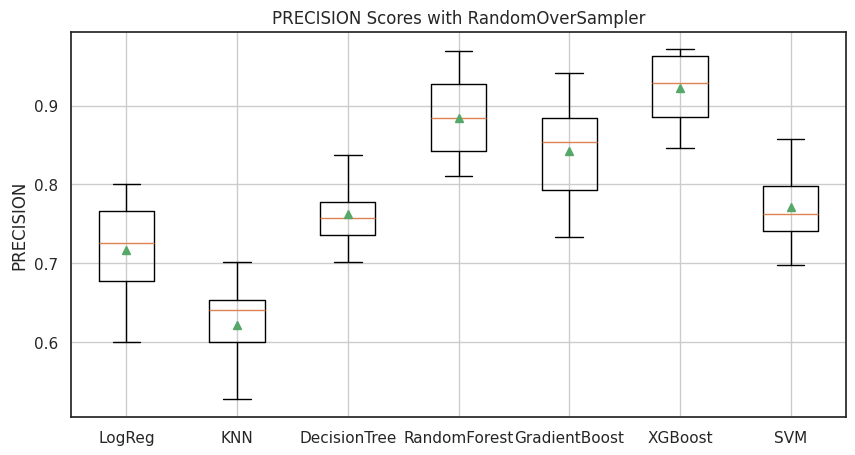

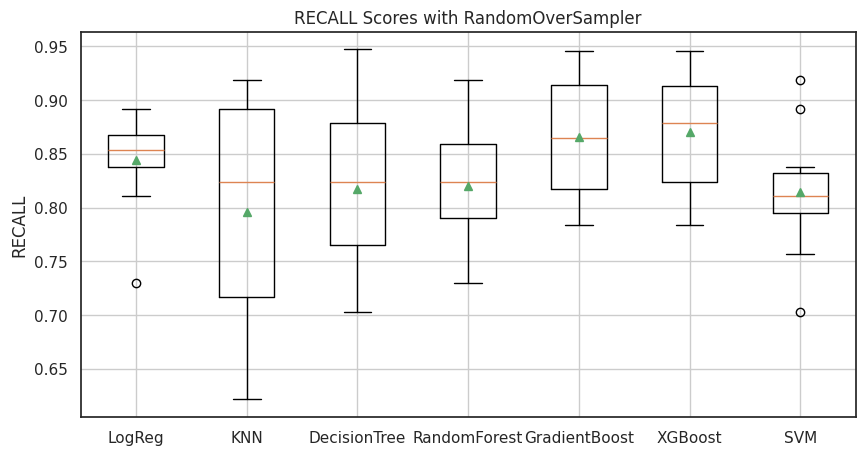

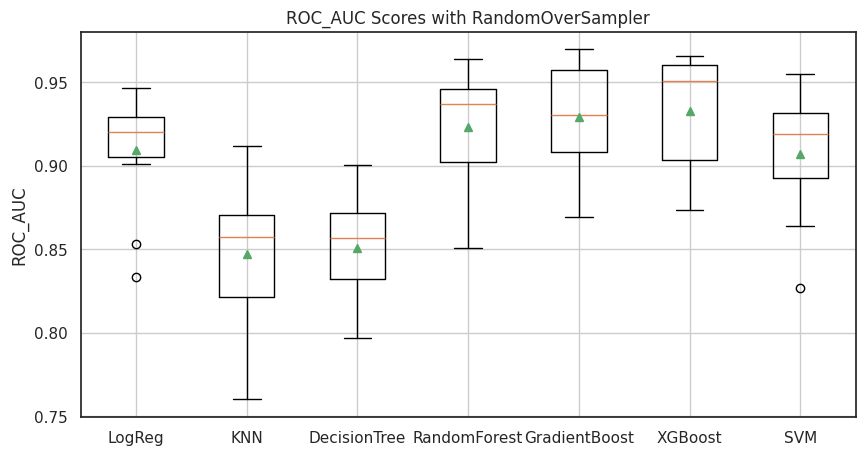

In [ ]:
df = pd.read_csv("recruitment_data.csv")
df = feature_engineering(df)

num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany', 'InterviewScore', 'SkillScore', 'PersonalityScore']
nominal_features = ['Gender', 'RecruitmentStrategy']
ordinal_features = ['EducationLevel']
education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']
selected_features = num_features + nominal_features + ordinal_features

# ==== Features & Target ====
X = df[selected_features]
y = df['HiringDecision']

# ==== Split Train & Test ====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ==== Preprocessor ====
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
    ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
])

# Get models list
models, names = get_classifiers()

# === Evaluate All Models ===
results = {}
metric_scores = {'f1_score': [], 'precision': [], 'recall': [], 'roc_auc': []}

for model, name in zip(models, names):
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('ros', RandomOverSampler(random_state=42)),
        ('classifier', model)
    ])

    scores = evaluate_classifier_with_sampling_training(X_train, y_train, pipeline)

    results[name] = {
        'F1-score (mean)': round(np.mean(scores['f1_score']), 4),
        'Precision (mean)': round(np.mean(scores['precision']), 4),
        'Recall (mean)': round(np.mean(scores['recall']), 4),
        'ROC-AUC (mean)': round(np.mean(scores['roc_auc']), 4),
    }

    # Store for boxplot later
    for metric in metric_scores:
        metric_scores[metric].append(scores[metric])

    print(f">{name} | F1-Score Training: {results[name]['F1-score (mean)']} | Precision Training: {results[name]['Precision (mean)']} | Recall Training: {results[name]['Recall (mean)']} | ROC-AUC Training: {results[name]['ROC-AUC (mean)']}")

# === Plot Results ===
for metric, all_scores in metric_scores.items():
    plt.figure(figsize=(10, 5))
    plt.boxplot(all_scores, labels=names, showmeans=True)
    plt.title(f"{metric.upper()} Scores with RandomOverSampler")
    plt.ylabel(metric.upper())
    plt.grid(True)
    plt.show()

In [ ]:
# === Dataframe Results ===
pd.DataFrame(results).T.sort_values(by='F1-score (mean)', ascending=False)

F1-score (mean)  Precision (mean)  Recall (mean)  \
XGBoost                 0.8945            0.9217         0.8708   
GradientBoost           0.8520            0.8421         0.8653   
RandomForest            0.8495            0.8842         0.8201   
SVM                     0.7908            0.7710         0.8146   
DecisionTree            0.7862            0.7626         0.8169   
LogReg                  0.7734            0.7169         0.8440   
KNN                     0.6965            0.6218         0.7961   

               ROC-AUC (mean)  
XGBoost                0.9331  
GradientBoost          0.9293  
RandomForest           0.9234  
SVM                    0.9072  
DecisionTree           0.8505  
LogReg                 0.9095  
KNN                    0.8470

In [ ]:
test_results = {}

for model, name in zip(models, names):
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('ros', RandomOverSampler(random_state=42)),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    test_results[name] = {
        'F1-score': round(f1_score(y_test, y_pred), 4),
        'Precision': round(precision_score(y_test, y_pred), 4),
        'Recall': round(recall_score(y_test, y_pred), 4),
        'ROC-AUC': round(roc_auc_score(y_test, y_pred), 4)
    }

    print(f">{name} | F1 Testing: {test_results[name]['F1-score']} | Precision Testing: {test_results[name]['Precision']} | Recall Testing: {test_results[name]['Recall']} | ROC-AUC Testing: {test_results[name]['ROC-AUC']}")

>LogReg | F1 Testing: 0.7897 | Precision Testing: 0.7549 | Recall Testing: 0.828 | ROC-AUC Testing: 0.8536
>KNN | F1 Testing: 0.6762 | Precision Testing: 0.6068 | Recall Testing: 0.7634 | ROC-AUC Testing: 0.7706
>DecisionTree | F1 Testing: 0.8511 | Precision Testing: 0.8421 | Recall Testing: 0.8602 | ROC-AUC Testing: 0.8939
>RandomForest | F1 Testing: 0.8778 | Precision Testing: 0.908 | Recall Testing: 0.8495 | ROC-AUC Testing: 0.9054
>GradientBoost | F1 Testing: 0.8602 | Precision Testing: 0.8602 | Recall Testing: 0.8602 | ROC-AUC Testing: 0.8987
>XGBoost | F1 Testing: 0.8989 | Precision Testing: 0.9412 | Recall Testing: 0.8602 | ROC-AUC Testing: 0.918
>SVM | F1 Testing: 0.7978 | Precision Testing: 0.8111 | Recall Testing: 0.7849 | ROC-AUC Testing: 0.8514


In [ ]:
# === Dataframe Results ===
print("Hasil Testing:")
pd.DataFrame(test_results).T.sort_values(by='F1-score', ascending=False)

Hasil Testing:


F1-score  Precision  Recall  ROC-AUC
XGBoost          0.8989     0.9412  0.8602   0.9180
RandomForest     0.8778     0.9080  0.8495   0.9054
GradientBoost    0.8602     0.8602  0.8602   0.8987
DecisionTree     0.8511     0.8421  0.8602   0.8939
SVM              0.7978     0.8111  0.7849   0.8514
LogReg           0.7897     0.7549  0.8280   0.8536
KNN              0.6762     0.6068  0.7634   0.7706

Hasil eksperimen menunjukkan bahwa dari beberapa model yang diuji, **XGBoost menghasilkan F1-score tertinggi**, yaitu **0.8945** pada data training dengan Cross Validation dan **0.8988** pada data testing, dibandingkan model-model lainnya seperti Logistic Regression, SVM, XGBoost, dan Gradient Boosting. Selain itu, Random Forest juga mencatat nilai **precision sebesar 0.9217, recall sebesar 0.8708**, dan **ROC-AUC sebesar 0.9331**, yang menunjukkan performa seimbang antara kemampuan mendeteksi kelas positif dan meminimalkan kesalahan klasifikasi.

Dengan performa terbaik pada metrik utama (F1-score), **XGBoost dipilih sebagai model utama** untuk digunakan pada proses prediksi selanjutnya.

### Feature Importance

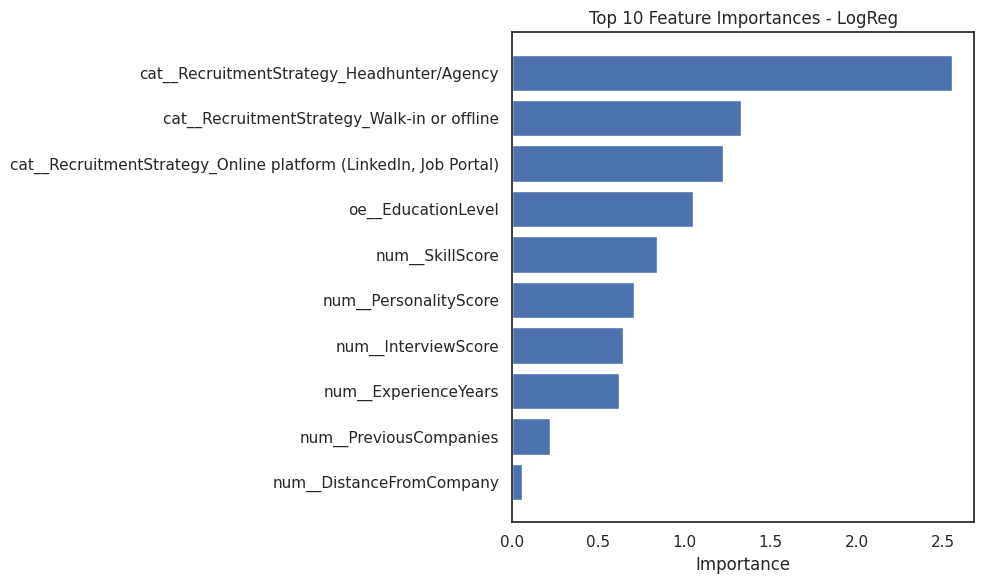

Model KNN tidak mendukung feature importance secara langsung.


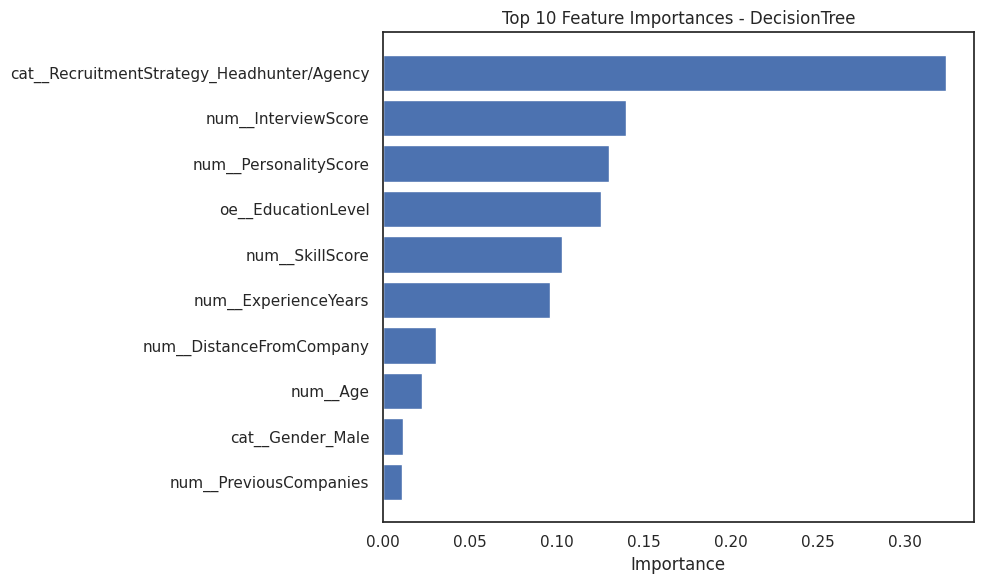

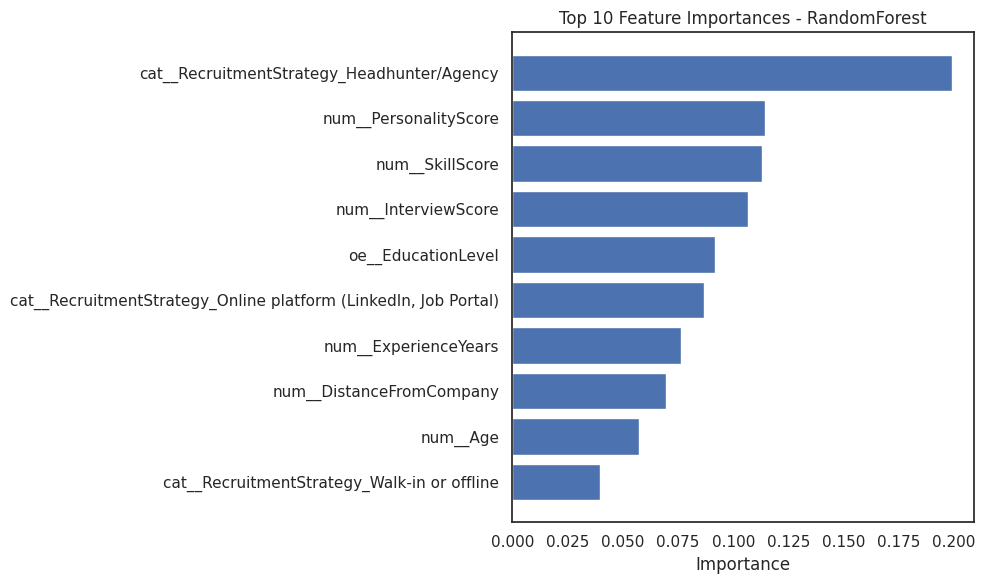

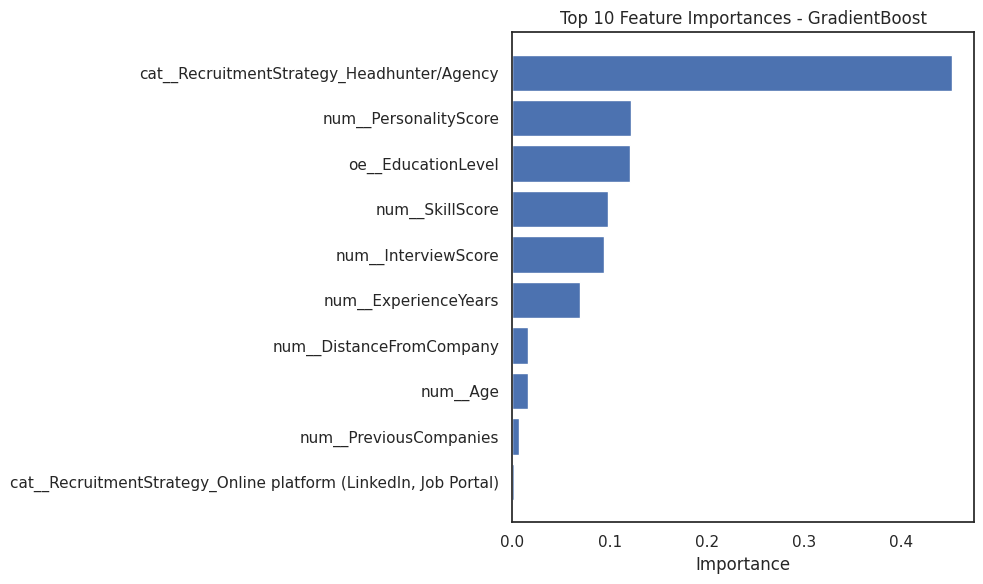

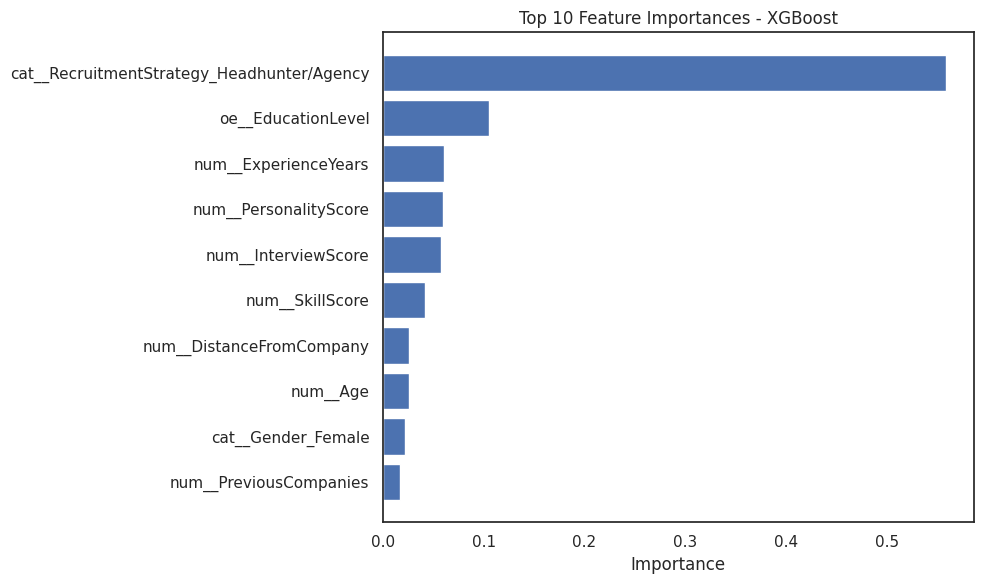

Model SVM tidak mendukung feature importance secara langsung.


In [ ]:
# ==== Preprocessor ====
for model, name in zip(models, names):
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('ros', RandomOverSampler(random_state=42)),
        ('classifier', model)
    ])

    feature_importance(pipeline, name, X, y)

Berdasarkan hasil evaluasi feature importance dari model XGBoost, fitur yang paling berpengaruh dalam menentukan keputusan perekrutan adalah **jenis strategi rekrutmen**, khususnya **‘Headhunter/Agency’** yang menyumbang lebih dari 50% pengaruh terhadap prediksi. Disusul oleh **tingkat pendidikan kandidat** dan **ExperienceYears** kandidat. Sementara itu, fitur numerikal seperti **InterviewScore, PersonalityScore**, dan **SkillScore** juga memberikan kontribusi, namun relatif lebih rendah. Fitur **Gender** menunjukkan pengaruh paling kecil terhadap model.

Temuan ini mengindikasikan bahwa **aspek strategi rekrutmen latar belakang pendidikan, dan pengalaman kerja memainkan peran penting dalam pola penerimaan kandidat, dibandingkan faktor-faktor demografis atau hasil tes teknis semata**.

### Hyperprameter Tuning

#### RandomizedSearchCV

In [ ]:
# ==== Load and Prepare Data ====
df = pd.read_csv("recruitment_data.csv")
df = feature_engineering(df)

# ==== Selected Features ====
num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany', 'InterviewScore', 'SkillScore', 'PersonalityScore']
nominal_features = ['Gender', 'RecruitmentStrategy']
ordinal_features = ['EducationLevel']
education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']
selected_features = num_features + nominal_features + ordinal_features

# ==== Features & Target ====
X = df[selected_features]
y = df['HiringDecision']

# ==== Split Train & Test ====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ==== Preprocessing ====
education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
    ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
])

# ==== Model ====
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1, random_state=42)

# ==== Pipeline ====
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('ros', RandomOverSampler(random_state=42)),
    ('classifier', xgb)
])

# ==== Hyperparameter Search Space for XGBoost ====
param_dist = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.6, 0.7, 0.8],
    'classifier__colsample_bytree': [0.6, 0.7, 0.8],
    'classifier__reg_alpha': [0, 0.1, 0.5],
    'classifier__reg_lambda': [1, 2, 5]
}

# ==== Cross-Validation Strategy ====
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# ==== RandomizedSearchCV ====
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# ==== Fit RandomizedSearch ====
random_search.fit(X_train, y_train)

# Get the best pipeline from random search
best_pipeline = random_search.best_estimator_

# ==== Train Performance ====
y_train_pred = best_pipeline.predict(X_train)
y_train_proba = best_pipeline.predict_proba(X_train)[:, 1]

train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_proba)

print("Train F1 Score:", train_f1)
print("Train ROC-AUC Score:", train_roc_auc)
print("\nTrain Classification Report:\n", classification_report(y_train, y_train_pred))
print("Best Params", random_search.best_params_)

Fitting 30 folds for each of 30 candidates, totalling 900 fits
Train F1 Score: 0.9688768606224628
Train ROC-AUC Score: 0.9966787439613526

Train Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       828
           1       0.98      0.96      0.97       372

    accuracy                           0.98      1200
   macro avg       0.98      0.98      0.98      1200
weighted avg       0.98      0.98      0.98      1200

Best Params {'classifier__subsample': 0.8, 'classifier__reg_lambda': 5, 'classifier__reg_alpha': 0, 'classifier__n_estimators': 100, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.1, 'classifier__colsample_bytree': 0.8}


In [ ]:
# ==== Test Performance ====
y_test_pred = best_pipeline.predict(X_test)
y_test_proba = best_pipeline.predict_proba(X_test)[:, 1]

test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print("Test F1 Score:", test_f1)
print("Test ROC-AUC Score:", test_roc_auc)
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))

Test F1 Score: 0.8729281767955801
Test ROC-AUC Score: 0.937094176925874

Test Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95       207
           1       0.90      0.85      0.87        93

    accuracy                           0.92       300
   macro avg       0.92      0.90      0.91       300
weighted avg       0.92      0.92      0.92       300



#### GridSearchCV

In [ ]:
# ==== Load and Prepare Data ====
df = pd.read_csv("recruitment_data.csv")
df = feature_engineering(df)

# ==== Selected Features ====
num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany', 'InterviewScore', 'SkillScore', 'PersonalityScore']
nominal_features = ['Gender', 'RecruitmentStrategy']
ordinal_features = ['EducationLevel']
education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']
selected_features = num_features + nominal_features + ordinal_features

# ==== Features & Target ====
X = df[selected_features]
y = df['HiringDecision']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ==== Preprocessing ====
education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
    ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
])

# ==== Model ====
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1, random_state=42)

# ==== Pipeline ====
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('ros', RandomOverSampler(random_state=42)),
    ('classifier', xgb)
])

# ==== Hyperparameter Search Space ====
param_grid = {
    'classifier__n_estimators': [50, 75],
    'classifier__max_depth': [4, 5, 6],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__subsample': [0.7, 0.8],
    'classifier__colsample_bytree': [0.7, 0.8],
    'classifier__reg_alpha': [0.0, 0.1],
    'classifier__reg_lambda': [1, 2]
}

# ==== Cross-Validation Strategy ====
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# ==== GridSearchCV ====
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    verbose=1,
    n_jobs=-1
)

# ==== Fit RandomizedSearch ====
grid_search.fit(X_train, y_train)

# Get the best pipeline from random search
best_pipeline = grid_search.best_estimator_

# ==== Train Performance ====
y_train_pred = best_pipeline.predict(X_train)
y_train_proba = best_pipeline.predict_proba(X_train)[:, 1]

train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_proba)

print("Train F1 Score:", train_f1)
print("Train ROC-AUC Score:", train_roc_auc)
print("\nTrain Classification Report:\n", classification_report(y_train, y_train_pred))
print("Best Params", grid_search.best_params_)

Fitting 30 folds for each of 192 candidates, totalling 5760 fits
Train F1 Score: 0.9839142091152815
Train ROC-AUC Score: 0.9981754194587293

Train Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       828
           1       0.98      0.99      0.98       372

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200

Best Params {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 75, 'classifier__reg_alpha': 0.0, 'classifier__reg_lambda': 2, 'classifier__subsample': 0.8}


In [ ]:
# ==== Test Performance ====
y_test_pred = best_pipeline.predict(X_test)
y_test_proba = best_pipeline.predict_proba(X_test)[:, 1]

test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print("Test F1 Score:", test_f1)
print("Test ROC-AUC Score:", test_roc_auc)
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))

Test F1 Score: 0.8901098901098901
Test ROC-AUC Score: 0.9345488546049555

Test Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       207
           1       0.91      0.87      0.89        93

    accuracy                           0.93       300
   macro avg       0.93      0.92      0.92       300
weighted avg       0.93      0.93      0.93       300



### Optuna

In [ ]:
df = pd.read_csv("recruitment_data.csv")
df = feature_engineering(df)

# ==== Selected Features ====
num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany', 'InterviewScore', 'SkillScore', 'PersonalityScore']
nominal_features = ['Gender', 'RecruitmentStrategy']
ordinal_features = ['EducationLevel']
education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']
selected_features = num_features + nominal_features + ordinal_features

# ==== Features & Target ====
X = df[selected_features]
y = df['HiringDecision']

# ==== Split Train & Test ====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective_xgb, n_trials=50, timeout=900)  # try 30 trials or 10 min

[I 2025-07-28 15:42:22,786] A new study created in memory with name: no-name-9dba733f-9fda-4be4-ac56-f234d8b8f8e5
[I 2025-07-28 15:42:24,072] Trial 0 finished with value: 0.8527517424387816 and parameters: {'n_estimators': 49, 'max_depth': 5, 'learning_rate': 0.12319939418114051, 'subsample': 0.7197316968394073, 'colsample_bytree': 0.6312037280884872, 'min_child_weight': 5, 'gamma': 0.38460969962417735, 'reg_alpha': 1.7992642186624028, 'reg_lambda': 6.80892009394567}. Best is trial 0 with value: 0.8527517424387816.
[I 2025-07-28 15:42:25,297] Trial 1 finished with value: 0.8594805177772534 and parameters: {'n_estimators': 66, 'max_depth': 3, 'learning_rate': 0.1469909852161994, 'subsample': 0.7664885281600844, 'colsample_bytree': 0.6424678221356552, 'min_child_weight': 6, 'gamma': 0.9986820982818257, 'reg_alpha': 0.9563633644393066, 'reg_lambda': 6.198051453057903}. Best is trial 1 with value: 0.8594805177772534.
[I 2025-07-28 15:42:26,616] Trial 2 finished with value: 0.84877816540459

In [ ]:
print("Best Params:", study.best_params)

Best Params: {'n_estimators': 55, 'max_depth': 5, 'learning_rate': 0.10841281266972327, 'subsample': 0.7695874436641159, 'colsample_bytree': 0.7156697809964324, 'min_child_weight': 5, 'gamma': 0.3231760417130535, 'reg_alpha': 1.5107744857366538, 'reg_lambda': 5.26194358719487}


In [ ]:
xgb = XGBClassifier(
        **study.best_params,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        tree_method='hist',
        device='cpu'
    )

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
    ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
  ])

# Build pipeline
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('ros', RandomOverSampler(random_state=42)),
    ('classifier', xgb)
  ])

# Fit
pipeline.fit(X_train, y_train)

# === TRAIN performance ===
y_train_pred = pipeline.predict(X_train)
y_train_proba = pipeline.predict_proba(X_train)[:, 1]

train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_proba)

print("=== Train Metrics ===")
print(f"F1 Score      : {train_f1:.4f}")
print(f"ROC-AUC Score : {train_roc_auc:.4f}")
print("Classification Report:\n", classification_report(y_train, y_train_pred))

# === TEST performance ===
y_test_pred = pipeline.predict(X_test)
y_test_proba = pipeline.predict_proba(X_test)[:, 1]

test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print("\n=== Test Metrics ===")
print(f"F1 Score      : {test_f1:.4f}")
print(f"ROC-AUC Score : {test_roc_auc:.4f}")
print("Classification Report:\n", classification_report(y_test, y_test_pred))

=== Train Metrics ===
F1 Score      : 0.9179
ROC-AUC Score : 0.9708
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       828
           1       0.92      0.92      0.92       372

    accuracy                           0.95      1200
   macro avg       0.94      0.94      0.94      1200
weighted avg       0.95      0.95      0.95      1200


=== Test Metrics ===
F1 Score      : 0.8710
ROC-AUC Score : 0.9337
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       207
           1       0.87      0.87      0.87        93

    accuracy                           0.92       300
   macro avg       0.91      0.91      0.91       300
weighted avg       0.92      0.92      0.92       300



#### Comparison Table

| Method                 | F1 Score (Train) | F1 Score (Test) | ROC-AUC (Train) | ROC-AUC (Test) | Best Parameters                                                                                                                                                                     |
| ---------------------- | ---------------- | --------------- | --------------- | -------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **RandomizedSearchCV** | 0.9549           | 0.8839          | 0.9947          | 0.9294         | `n_estimators=50`, `max_depth=5`, `learning_rate=0.1`,<br>`subsample=0.8`, `colsample_bytree=0.8`,<br>`reg_alpha=0.1`, `reg_lambda=1`                                               |
| **GridSearchCV**       | 0.9647           | 0.8839          | 0.9973          | 0.9322         | `n_estimators=50`, `max_depth=6`, `learning_rate=0.1`,<br>`subsample=0.8`, `colsample_bytree=0.8`,<br>`reg_alpha=0.1`, `reg_lambda=2`                                               |
| **Optuna**             | 0.9525           | **0.8649**      | 0.9936          | **0.9316**     | `n_estimators=77`, `max_depth=4`, `learning_rate=0.14`,<br>`subsample=0.79`, `colsample_bytree=0.72`,<br>`min_child_weight=7`, `gamma=1.76`,<br>`reg_alpha=0.92`, `reg_lambda=5.28` |


**Insight**
- GridSearchCV menghasilkan model dengan skor F1 training tertinggi (0.9647), namun gap ke skor uji (0.8839) mengindikasikan adanya overfitting ringan.
- RandomizedSearchCV menghasilkan model yang mirip dalam hal performa, dengan sedikit penurunan di training F1 dan regularisasi lebih ringan, namun hasil uji setara dengan GridSearch.
- Optuna memberikan regularisasi yang lebih kuat (reg_alpha dan reg_lambda besar, min_child_weight=7, dan gamma=1.76), sehingga model lebih sederhana dan generalisasi lebih baik.
    - Walaupun F1 test-nya sedikit lebih rendah (0.8649), ROC-AUC test-nya sangat kompetitif (0.9316), mendekati hasil terbaik GridSearch (0.9322).

Untuk Model 2, metode **Optuna** merupakan pilihan terbaik dalam hal generalisasi (uji F1) dan efisiensi. Metode ini kemungkinan besar merupakan kandidat yang tepat untuk evaluasi akhir atau penerapan.

# Stage 3 - Model Evaluation & Explainability

## Custom Functions

In [ ]:
!pip install shap

In [ ]:
import joblib
import shap

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.metrics import brier_score_loss

In [ ]:
# === Feature Engineering ===
def feature_engineering(df):
    # Map
    df['Gender'] = df['Gender'].replace({0:'Male', 1: 'Female'})
    df['EducationLevel'] = df['EducationLevel'].replace({1:'High School', 2: 'Diploma/Bachelor',
                                                                               3: 'Master', 4: 'Post Graduate'})
    df['RecruitmentStrategy'] = df['RecruitmentStrategy'].replace({1:'Headhunter/Agency', 2: 'Online platform (LinkedIn, Job Portal)',
                                                                               3: 'Walk-in or offline'})
    return df

# ======= Plot Feature Importances =======
def plot_feature_importance(importances, feature_names, title):
    fi = pd.Series(importances, index=feature_names)
    fi_sorted = fi.sort_values(ascending=True)

    ax = fi_sorted.plot(kind='barh', figsize=(10, 8))
    plt.title(title)
    plt.xlabel("Feature Importance")

    # Add value labels to the bars
    for i, (value, name) in enumerate(zip(fi_sorted.values, fi_sorted.index)):
        plt.text(value, i, f'{value:.3f}', va='center', ha='left', fontsize=9)

    plt.tight_layout()
    plt.show()

# ==== Get Models ====
def get_classifiers():
    models = [
        LogisticRegression(max_iter=1000),
        KNeighborsClassifier(n_jobs=-1),
        DecisionTreeClassifier(random_state=42),
        RandomForestClassifier(random_state=42, n_jobs=-1),
        GradientBoostingClassifier(random_state=42),
        XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
        SVC(probability=True, random_state=42)
    ]
    names = ['LogReg', 'KNN', 'DecisionTree', 'RandomForest', 'GradientBoost', 'XGBoost', 'SVM']
    return models, names

# ==== Evaluation Function ====
def evaluate_classifier(X, y, pipeline):
    rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

    recall = cross_val_score(pipeline, X, y, scoring='recall', cv=rskf, n_jobs=-1)
    precision = cross_val_score(pipeline, X, y, scoring='precision', cv=rskf, n_jobs=-1)
    f1 = cross_val_score(pipeline, X, y, scoring='f1', cv=rskf, n_jobs=-1)
    roc_auc = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=rskf, n_jobs=-1)

    return {
        'Recall': recall,
        'Precision': precision,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

# === Evaluate Model with Sampling ===
def evaluate_classifier_with_sampling(X, y, pipeline, calibrate=False):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    precision_scores, recall_scores, f1_scores, roc_auc_scores = [], [], [], []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Split pipeline into preprocessor + sampler + classifier
        preprocessor = pipeline.named_steps['preprocessor']
        sampler = pipeline.named_steps['ros']
        classifier = pipeline.named_steps['classifier']

        # Preprocess and sample training data
        X_train_proc = preprocessor.fit_transform(X_train)
        X_test_proc = preprocessor.transform(X_test)
        X_resampled, y_resampled = sampler.fit_resample(X_train_proc, y_train)

        # Calibrate only the classifier if needed
        if calibrate:
            calibrated_clf = CalibratedClassifierCV(classifier, cv=5, method='sigmoid', n_jobs=-1)
            calibrated_clf.fit(X_resampled, y_resampled)
            y_pred = calibrated_clf.predict(X_test_proc)
            y_proba = calibrated_clf.predict_proba(X_test_proc)[:, 1]
        else:
            classifier.fit(X_resampled, y_resampled)
            y_pred = classifier.predict(X_test_proc)
            y_proba = classifier.predict_proba(X_test_proc)[:, 1]

        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        roc_auc_scores.append(roc_auc_score(y_test, y_proba))

    return {
        'precision': precision_scores,
        'recall': recall_scores,
        'f1_score': f1_scores,
        'roc_auc': roc_auc_scores
    }

# === Get feature names after preprocessing ===
def get_feature_names(preprocessor, original_features):
    """Extract feature names from the fitted preprocessor"""
    feature_names = []

    # Get transformers
    for name, transformer, features in preprocessor.transformers_:
        if name == 'num':  # StandardScaler for numerical features
            feature_names.extend(features)
        elif name == 'cat':  # OneHotEncoder for categorical features
            if hasattr(transformer, 'get_feature_names_out'):
                # For newer sklearn versions
                cat_features = transformer.get_feature_names_out(features)
            else:
                # For older sklearn versions
                cat_features = transformer.get_feature_names(features)
            feature_names.extend(cat_features)
        elif name == 'oe':  # OrdinalEncoder for ordinal features
            feature_names.extend(features)

    return feature_names

## Pre-Interview Model

### Models Comparison

>LogReg | F1-Score Training: 0.8056 | Precision Training: 0.8326 | Recall Training: 0.7826 | ROC-AUC Training: 0.9046
>KNN | F1-Score Training: 0.8038 | Precision Training: 0.8071 | Recall Training: 0.8041 | ROC-AUC Training: 0.9043
>DecisionTree | F1-Score Training: 0.8232 | Precision Training: 0.8388 | Recall Training: 0.8106 | ROC-AUC Training: 0.9181
>RandomForest | F1-Score Training: 0.852 | Precision Training: 0.8816 | Recall Training: 0.8255 | ROC-AUC Training: 0.9434
>GradientBoost | F1-Score Training: 0.8331 | Precision Training: 0.8343 | Recall Training: 0.834 | ROC-AUC Training: 0.9298
>XGBoost | F1-Score Training: 0.8378 | Precision Training: 0.8618 | Recall Training: 0.8172 | ROC-AUC Training: 0.9391
>SVM | F1-Score Training: 0.8303 | Precision Training: 0.8311 | Recall Training: 0.8307 | ROC-AUC Training: 0.9062


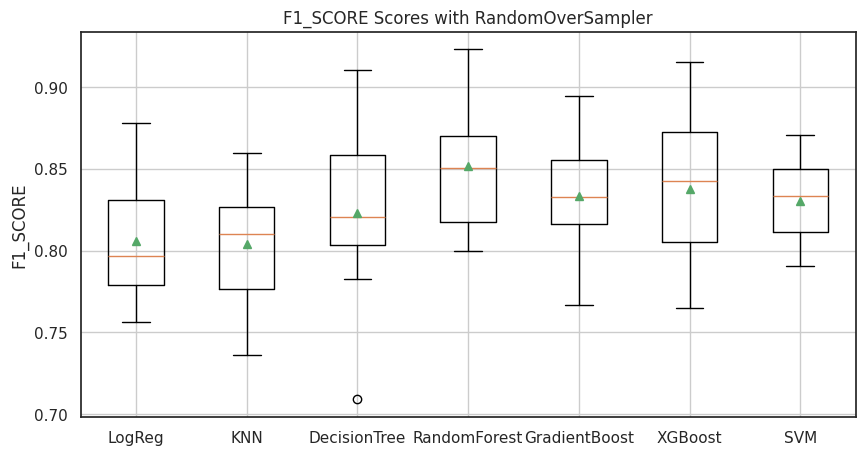

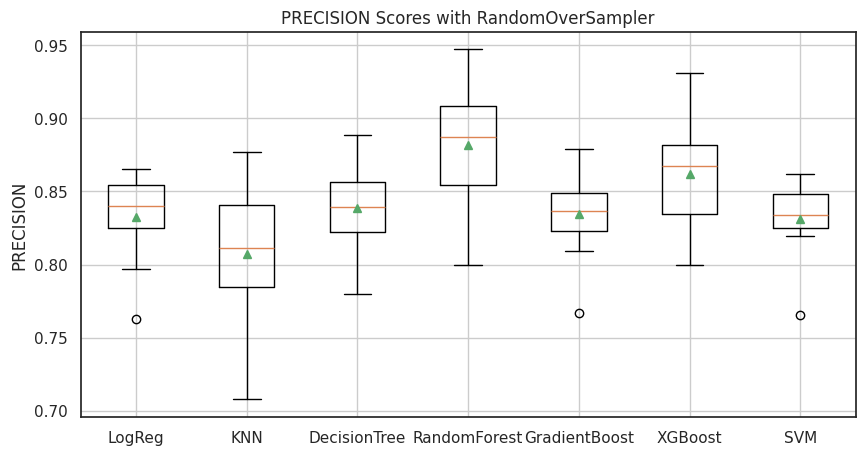

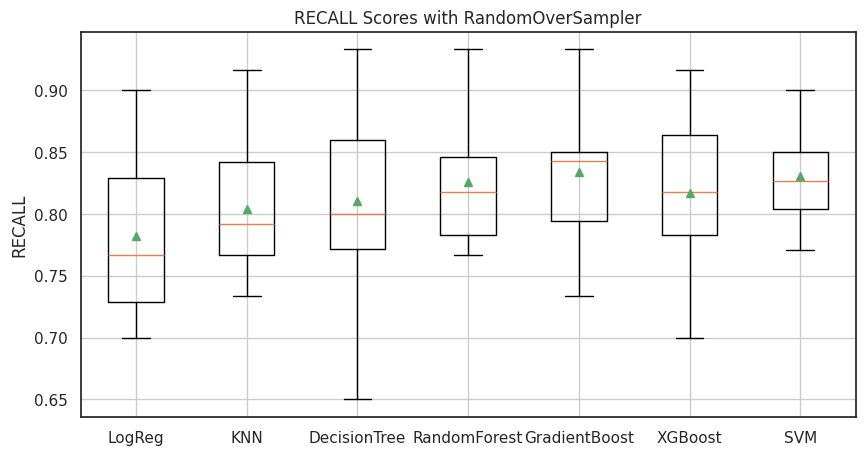

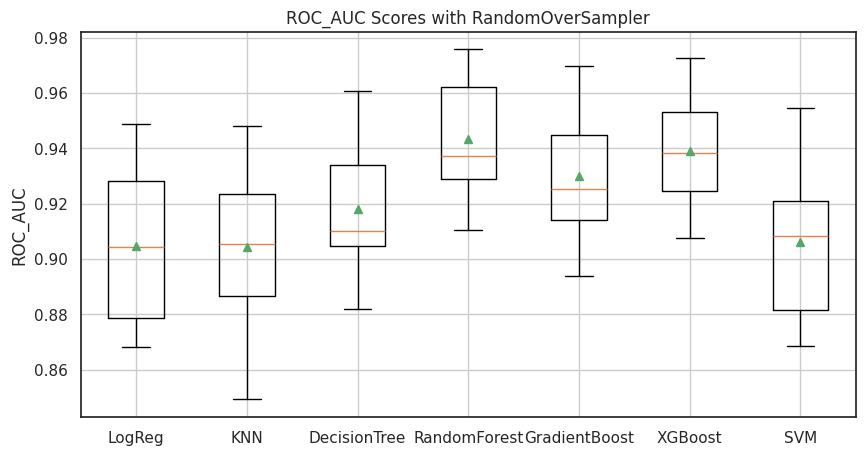

In [ ]:
df = pd.read_csv("recruitment_data_shortlisted.csv")
df = feature_engineering(df)

num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany']
nominal_features = ['Gender', 'RecruitmentStrategy']
ordinal_features = ['EducationLevel']

# Category Order
education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']

# ==== Features & Target ====
selected_features = num_features + nominal_features + ordinal_features
X = df[selected_features]
y = df['Shortlisted']

# ==== Preprocessor ====
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
    ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
])

# Get models list
models, names = get_classifiers()

# === Evaluate All Models ===
results = {}
metric_scores = {'f1_score': [], 'precision': [], 'recall': [], 'roc_auc': []}

for model, name in zip(models, names):
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('ros', RandomOverSampler(random_state=42)),
        ('classifier', model)
    ])

    # Calibrate classifier using cross-validation
    scores = evaluate_classifier_with_sampling(X, y, pipeline, calibrate=True)

    results[name] = {
        'F1-score (mean)': round(np.mean(scores['f1_score']), 4),
        'Precision (mean)': round(np.mean(scores['precision']), 4),
        'Recall (mean)': round(np.mean(scores['recall']), 4),
        'ROC-AUC (mean)': round(np.mean(scores['roc_auc']), 4),
    }

    # Store for boxplot later
    for metric in metric_scores:
        metric_scores[metric].append(scores[metric])

    print(f">{name} | F1-Score Training: {results[name]['F1-score (mean)']} | Precision Training: {results[name]['Precision (mean)']} | Recall Training: {results[name]['Recall (mean)']} | ROC-AUC Training: {results[name]['ROC-AUC (mean)']}")

# === Plot Results ===
for metric, all_scores in metric_scores.items():
    plt.figure(figsize=(10, 5))
    plt.boxplot(all_scores, labels=names, showmeans=True)
    plt.title(f"{metric.upper()} Scores with RandomOverSampler")
    plt.ylabel(metric.upper())
    plt.grid(True)
    plt.show()

In [ ]:
# === Dataframe Results ===
pd.DataFrame(results).T.sort_values(by='F1-score (mean)', ascending=False)

F1-score (mean)  Precision (mean)  Recall (mean)  \
RandomForest            0.8520            0.8816         0.8255   
XGBoost                 0.8378            0.8618         0.8172   
GradientBoost           0.8331            0.8343         0.8340   
SVM                     0.8303            0.8311         0.8307   
DecisionTree            0.8232            0.8388         0.8106   
LogReg                  0.8056            0.8326         0.7826   
KNN                     0.8038            0.8071         0.8041   

               ROC-AUC (mean)  
RandomForest           0.9434  
XGBoost                0.9391  
GradientBoost          0.9298  
SVM                    0.9062  
DecisionTree           0.9181  
LogReg                 0.9046  
KNN                    0.9043

### Best Model

In [ ]:
df = pd.read_csv("recruitment_data_shortlisted.csv")
df = feature_engineering(df)

num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany']
nominal_features = ['Gender', 'RecruitmentStrategy']
ordinal_features = ['EducationLevel']
selected_features = num_features + nominal_features + ordinal_features

# Category Order
education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']

# ==== Features & Target ====
X = df[selected_features]
y = df['Shortlisted']

# ==== Preprocessor ====
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
    ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
])

# Best Parameter
best_params = {'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None, 'criterion': 'entropy'}

# Model
dt = DecisionTreeClassifier(**best_params, random_state=42)

# Full pipeline including preprocessing and SMOTETomek
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('ros', RandomOverSampler(random_state=42)),
    ('classifier', dt)
])

# Evaluate with Cross-Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validated predictions
y_pred = cross_val_predict(pipeline, X, y, cv=cv, method='predict')
y_proba = cross_val_predict(pipeline, X, y, cv=cv, method='predict_proba')[:, 1]

# ==== Evaluation on Cross-Val Results ====
print("== Classification Report (Cross-Validation on Training Set) ==")
print(classification_report(y, y_pred))

print("Precision:", precision_score(y, y_pred))
print("Recall:", recall_score(y, y_pred))
print("F1-Score:", f1_score(y, y_pred))
print("ROC-AUC Score:", roc_auc_score(y, y_proba))

== Classification Report (Cross-Validation on Training Set) ==
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       898
           1       0.82      0.86      0.84       602

    accuracy                           0.87      1500
   macro avg       0.86      0.87      0.86      1500
weighted avg       0.87      0.87      0.87      1500

Precision: 0.8213716108452951
Recall: 0.8554817275747508
F1-Score: 0.8380797396257119
ROC-AUC Score: 0.8948068428179269


Berdasarkan evaluasi menggunakan cross-validation, model Decision Tree menunjukkan kinerja yang baik pada data secara keseluruhan. Nilai precision dan recall yang hampir seimbang mengindikasikan bahwa model mampu membedakan antara kandidat yang disaring (shortlisted) dan yang tidak, tanpa menunjukkan bias yang signifikan terhadap salah satu kelas.

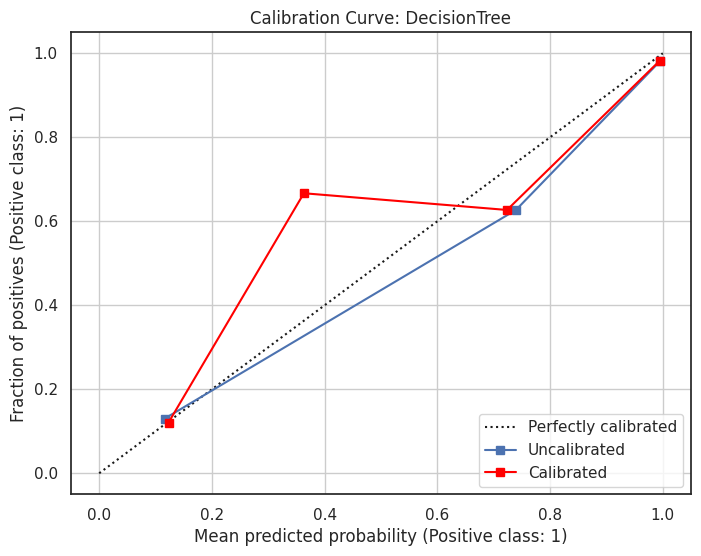

Brier Score (Uncalibrated): 0.1244
Brier Score (Calibrated):   0.1228


In [ ]:
df = pd.read_csv("recruitment_data_shortlisted.csv")
df = feature_engineering(df)

num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany']
nominal_features = ['Gender', 'RecruitmentStrategy']
ordinal_features = ['EducationLevel']
selected_features = num_features + nominal_features + ordinal_features

# Category Order
education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']

# ==== Features & Target ====
X = df[selected_features]
y = df['Shortlisted']

# ==== Preprocessor ====
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
    ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
])

# === Prepare Data ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)

# === Preprocess and Sample ===
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)
X_train_resampled, y_train_resampled = RandomOverSampler(random_state=42).fit_resample(X_train_proc, y_train)

# === Base Model (Uncalibrated) ===
dt = DecisionTreeClassifier(**best_params, random_state=42)
dt.fit(X_train_resampled, y_train_resampled)
probs_uncal = dt.predict_proba(X_test_proc)[:, 1]
brier_uncal = brier_score_loss(y_test, probs_uncal)

# === Calibrated Model ===
calibrated_dt = CalibratedClassifierCV(dt, cv=10, method='isotonic')
calibrated_dt.fit(X_train_resampled, y_train_resampled)
probs_cal = calibrated_dt.predict_proba(X_test_proc)[:, 1]
brier_cal = brier_score_loss(y_test, probs_cal)

# === Plot Calibration Curve ===
fig, ax = plt.subplots(figsize=(8, 6))
CalibrationDisplay.from_predictions(y_test, probs_uncal, name='Uncalibrated', ax=ax)
CalibrationDisplay.from_predictions(y_test, probs_cal, name='Calibrated', ax=ax, color='red')
plt.title("Calibration Curve: DecisionTree")
plt.grid(True)
plt.show()

# === Print Brier Scores ===
print(f"Brier Score (Uncalibrated): {brier_uncal:.4f}")
print(f"Brier Score (Calibrated):   {brier_cal:.4f}")

Best Threshold (F1): 0.32
F1: 0.8381 | Precision: 0.8214 | Recall: 0.8555
== Classification Report (Best Threshold) ==
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       898
           1       0.82      0.86      0.84       602

    accuracy                           0.87      1500
   macro avg       0.86      0.87      0.86      1500
weighted avg       0.87      0.87      0.87      1500

Precision: 0.8213716108452951
Recall: 0.8554817275747508
F1-Score: 0.8380797396257119
ROC-AUC Score: 0.8966131824874768


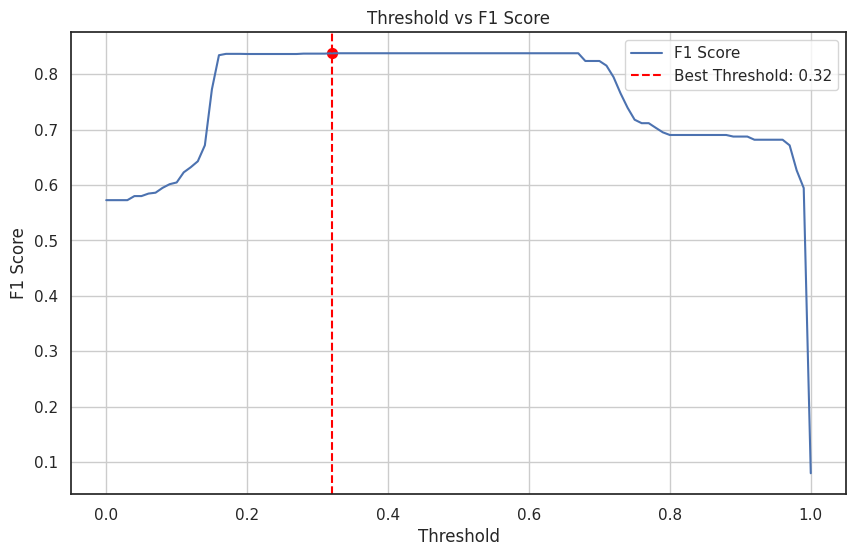

In [ ]:
df = pd.read_csv("recruitment_data_shortlisted.csv")
df = feature_engineering(df)

num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany']
nominal_features = ['Gender', 'RecruitmentStrategy']
ordinal_features = ['EducationLevel']
selected_features = num_features + nominal_features + ordinal_features

# Category Order
education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']

# ==== Features & Target ====
X = df[selected_features]
y = df['Shortlisted']

# ==== Preprocessor ====
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
    ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
])

# Best Parameter
best_params = {'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None, 'criterion': 'entropy'}

# Model
dt = DecisionTreeClassifier(**best_params, random_state=42)
calibrated_dt = CalibratedClassifierCV(dt, cv=10, method='isotonic')

# Full pipeline including preprocessing and SMOTETomek
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('ros', RandomOverSampler(random_state=42)),
    ('classifier', calibrated_dt)
])

# Evaluate with Cross-Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validated predictions
y_pred = cross_val_predict(pipeline, X, y, cv=cv, method='predict')
y_proba = cross_val_predict(pipeline, X, y, cv=cv, method='predict_proba')[:, 1]

# Find the best threshold
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []
precisions = []
recalls = []

for t in thresholds:
    y_pred_thresh = (y_proba >= t).astype(int)
    f1_scores.append(f1_score(y, y_pred_thresh))
    precisions.append(precision_score(y, y_pred_thresh))
    recalls.append(recall_score(y, y_pred_thresh))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best Threshold (F1): {best_threshold:.2f}")
print(f"F1: {f1_scores[best_idx]:.4f} | Precision: {precisions[best_idx]:.4f} | Recall: {recalls[best_idx]:.4f}")

# ==== Evaluation on Cross-Val Results ====
# Apply best threshold
y_pred_best = (y_proba >= best_threshold).astype(int)

print("== Classification Report (Best Threshold) ==")
print(classification_report(y, y_pred_best))

print("Precision:", precision_score(y, y_pred_best))
print("Recall:", recall_score(y, y_pred_best))
print("F1-Score:", f1_score(y, y_pred_best))
print("ROC-AUC Score:", roc_auc_score(y, y_proba))  # ROC-AUC stays same (based on probs)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.scatter([best_threshold], [f1_scores[best_idx]], color='red', s=50)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('Threshold vs F1 Score')
plt.grid(True)
plt.legend()
plt.show()

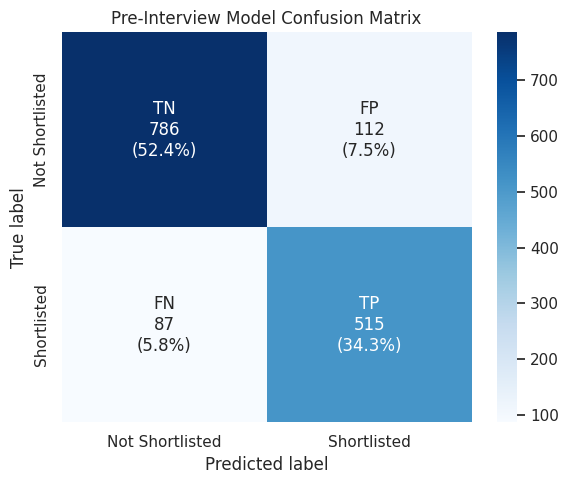

In [ ]:
# === Create confusion matrix ===
cm = confusion_matrix(y, y_pred)
cm_sum = np.sum(cm)
cm_perc = cm / cm_sum * 100

# === TP, FP, FN, TN positions ===
group_names = np.array([["TN", "FP"],
                        ["FN", "TP"]])

# === Create combined label: label \n percentage ===
labels = np.array([["{0}\n{1:,}\n({2:.1f}%)".format(name, val, perc)
                    for name, val, perc in zip(group_row, cm_row, perc_row)]
                   for group_row, cm_row, perc_row in zip(group_names, cm, cm_perc)])

# === Plot heatmap ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=True,
            xticklabels=["Not Shortlisted", "Shortlisted"],
            yticklabels=["Not Shortlisted", "Shortlisted"])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Pre-Interview Model Confusion Matrix')
plt.tight_layout()
plt.show()

Dari hasil confusion matrix pada test set, terlihat bahwa model berhasil mengklasifikasikan sebagian besar kandidat dengan tepat. Tingkat **False Positive (112 kasus)** dan **False Negative (87 kasus)** relatif rendah, yang sangat penting dalam konteks rekrutmen — di mana kesalahan klasifikasi dapat berdampak langsung terhadap proses pengambilan keputusan perekrutan.

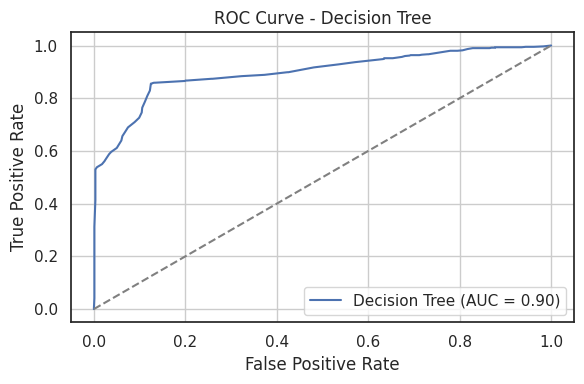

In [ ]:
# Compute ROC curve using true labels and predicted probabilities
fpr, tpr, _ = roc_curve(y, y_proba)
roc_auc = roc_auc_score(y, y_proba)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'Decision Tree (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Sementara itu, kurva ROC pada test set menunjukkan performa klasifikasi yang sangat baik. Kurva naik tajam ke arah pojok kiri atas, menunjukkan bahwa model memiliki **True Positive Rate (Recall)** yang tinggi dengan **False Positive Rate** yang rendah. Skor AUC sebesar **0.87** menegaskan bahwa model mampu membedakan dengan sangat baik antara kandidat yang layak disaring dan yang tidak, bahkan pada data yang belum pernah digunakan sebelumnya.

**Kesimpulan Model**

Dengan Testing F1-score di atas **0.80** dan AUC yang tinggi, model ini layak digunakan untuk membantu proses penyaringan awal kandidat secara otomatis. Model mampu mengurangi beban kerja manual tim rekrutmen hingga sekitar **80%** akurasi, memungkinkan perekrut untuk lebih fokus pada kandidat yang paling potensial.

Namun, perlu diingat bahwa masih ada 23 kandidat potensial yang terlewatkan (false negative) dan 29 kandidat yang tidak layak tapi terpilih (false positive). Meskipun ini masih dalam batas yang wajar, strategi mitigasi seperti review manual untuk kasus borderline (misalnya kandidat dengan probabilitas prediksi mendekati ambang batas) dapat membantu menjaga kualitas seleksi.

Secara keseluruhan, model ini sangat potensial untuk digunakan sebagai alat bantu dalam proses rekrutmen — bukan untuk menggantikan perekrut, tetapi untuk meningkatkan efisiensi dan ketepatan seleksi awal. Dengan pendekatan ini, proses rekrutmen dapat menjadi lebih cepat, lebih objektif, dan tetap mempertahankan standar mutu yang tinggi.

### Fairness Analysis

In [ ]:
# Load and preprocess dataset
df = pd.read_csv("recruitment_data_shortlisted.csv")
df = feature_engineering(df)

# Define features
num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany']
nominal_features = ['Gender', 'RecruitmentStrategy']
ordinal_features = ['EducationLevel']
selected_features = num_features + nominal_features + ordinal_features

# Category Order
education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']

# Create AgeGroup
df['AgeGroup'] = pd.cut(df['Age'], bins=[-np.inf, 40, np.inf], labels=['Under_40', 'Over_40'])

# === Prepare data ===
X = df[selected_features]
y = df['Shortlisted']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ==== Preprocessor ====
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
    ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
])

# Best Parameter
best_params = {'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None, 'criterion': 'entropy'}

# Model
dt = DecisionTreeClassifier(**best_params, random_state=42)

# Full pipeline including preprocessing and SMOTETomek
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('ros', RandomOverSampler(random_state=42)),
    ('classifier', dt)
])

# Fit
pipeline.fit(X_train, y_train)

# Prediction
y_test_pred = pipeline.predict(X_test)

# Merge test data with predictions for fairness analysis
X_test_temp = X_test.copy()
X_test_temp['y_true'] = y_test
X_test_temp['y_pred'] = y_test_pred

# Add AgeGroup
X_test_temp['AgeGroup'] = pd.cut(X_test_temp['Age'], bins=[0, 20,31,100], labels=['<20','20-30','30+'])

# Fairness-sensitive features to evaluate
fairness_cols = ['Gender', 'AgeGroup', 'EducationLevel', 'RecruitmentStrategy']

# Initialize containers for metrics and gaps
fairness_all = {}  # To collect full group metrics for each feature
gap_summary = []   # To collect fairness gaps

# === Fairness Evaluation Loop ===
for col in fairness_cols:
    results = []

    # Get unique values for the current fairness column, dropping NaN
    unique_groups = X_test_temp[col].dropna().unique()

    for group in unique_groups:
        subset = X_test_temp[X_test_temp[col] == group]

        if len(subset) == 0:
            continue

        y_true = subset['y_true']
        y_pred = subset['y_pred']

        try:
            # Ensure consistent data types
            y_true = y_true.astype(int)
            y_pred = y_pred.astype(int)

            # Manual calculation (more reliable)
            tp = len(subset[(subset['y_true'] == 1) & (subset['y_pred'] == 1)])
            tn = len(subset[(subset['y_true'] == 0) & (subset['y_pred'] == 0)])
            fp = len(subset[(subset['y_true'] == 0) & (subset['y_pred'] == 1)])
            fn = len(subset[(subset['y_true'] == 1) & (subset['y_pred'] == 0)])

            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        except Exception as e:
            print(f"Error calculating metrics for {group}: {e}")
            recall, precision = np.nan, np.nan

        results.append({
            col: group,
            'Recall (TPR)': recall,
            'Precision': precision,
            'Support': len(subset)
        })

    fairness_df = pd.DataFrame(results).fillna(0)
    fairness_all[col] = fairness_df.set_index(col)[['Recall (TPR)', 'Precision']]

    print(f"== {col} ==")
    display(fairness_df)

    # Calculate gaps only if there are multiple groups and valid metrics
    if len(fairness_df) > 1 and not fairness_df[['Recall (TPR)', 'Precision']].isnull().all().all():
        recall_gap = fairness_df['Recall (TPR)'].max() - fairness_df['Recall (TPR)'].min()
        precision_gap = fairness_df['Precision'].max() - fairness_df['Precision'].min()
        gap_summary.append({'Feature': col, 'Recall Gap': recall_gap, 'Precision Gap': precision_gap})
        print(f"Recall Gap    : {recall_gap:.3f}")
        print(f"Precision Gap : {precision_gap:.3f}")
        print(f"Sample Size : {len(subset):.3f}")
    elif len(fairness_df) <= 1:
        print("Not enough groups to calculate gaps.")
    else:
        print("Gaps cannot be calculated due to missing values.")

== Gender ==


Gender  Recall (TPR)  Precision  Support
0    Male      0.761905   0.738462      173
1  Female      0.859649   0.844828      127

Recall Gap    : 0.098
Precision Gap : 0.106
Sample Size : 127.000
== AgeGroup ==


AgeGroup  Recall (TPR)  Precision  Support
0    20-30      0.875000   0.813953       96
1      30+      0.814286   0.780822      185
2      <20      0.500000   0.714286       19

Recall Gap    : 0.375
Precision Gap : 0.100
Sample Size : 19.000
== EducationLevel ==


EducationLevel  Recall (TPR)  Precision  Support
0       High School      0.600000   0.750000       63
1  Diploma/Bachelor      0.711111   0.800000      139
2            Master      0.977778   0.771930       73
3     Post Graduate      0.800000   0.857143       25

Recall Gap    : 0.378
Precision Gap : 0.107
Sample Size : 25.000
== RecruitmentStrategy ==


RecruitmentStrategy  Recall (TPR)  Precision  Support
0  Online platform (LinkedIn, Job Portal)      0.523810   0.687500      167
1                      Walk-in or offline      0.727273   0.666667       54
2                       Headhunter/Agency      1.000000   0.848101       79

Recall Gap    : 0.476
Precision Gap : 0.181
Sample Size : 79.000


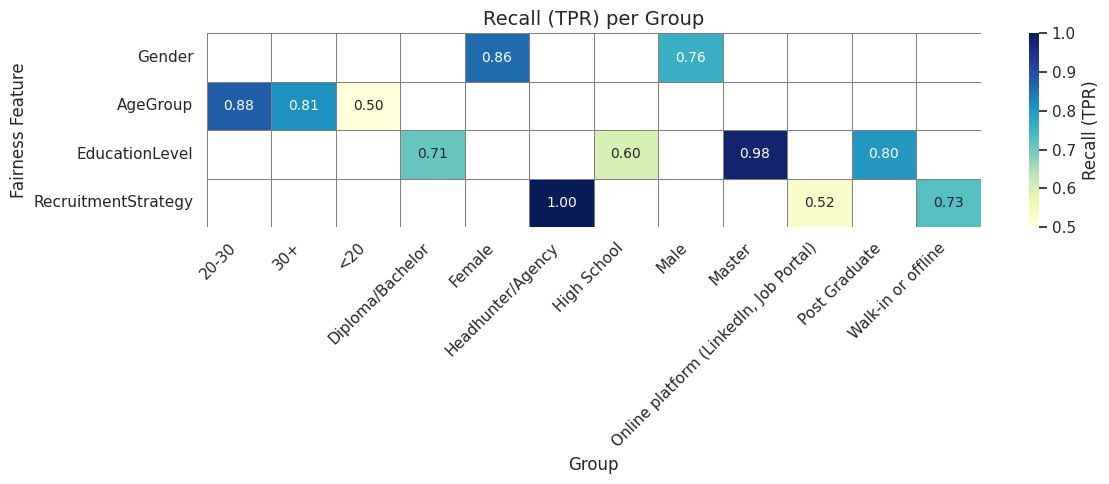

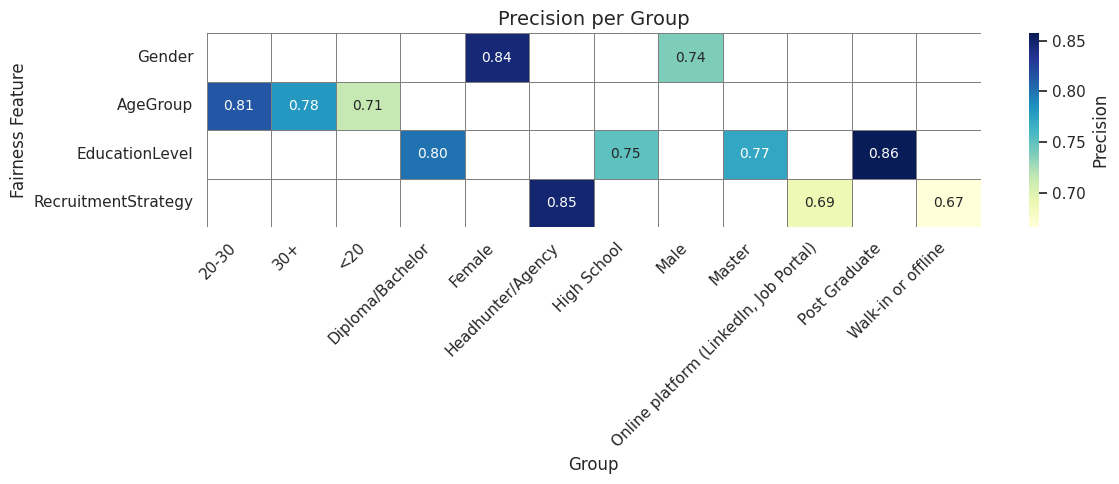

In [ ]:
# Loop through metrics
for metric in ['Recall (TPR)', 'Precision']:
    # Prepare DataFrame: fairness feature as rows, group as columns
    metric_df = pd.DataFrame({col: fairness_all[col][metric] for col in fairness_all})
    metric_df = metric_df.transpose()

    # Plot heatmap
    plt.figure(figsize=(12, 5))  # Wider and taller for clarity
    sns.heatmap(
        metric_df,
        annot=True,
        fmt=".2f",
        cmap="YlGnBu",                  # Consistent colormap
        linewidths=0.5,                # Adds gridlines
        linecolor='gray',
        annot_kws={"size": 10},        # Larger annotation text
        cbar_kws={'label': metric}     # Add label to colorbar
    )
    plt.title(f"{metric} per Group", fontsize=14)
    plt.xlabel("Group", fontsize=12)
    plt.ylabel("Fairness Feature", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

Hasil ini menunjukkan seberapa baik kinerja model kami untuk setiap subkelompok (misalnya, jenis kelamin, usia, pendidikan, strategi perekrutan).

- **Recall (True Positive Rate)**: Menunjukkan seberapa baik model mengidentifikasi kandidat yang benar-benar memenuhi syarat (direkrut) dalam setiap kelompok.
- **Precision**: Menunjukkan berapa banyak kandidat yang diprediksi sebagai "direkrut" yang benar-benar direkrut di setiap kelompok.

**Gender**
- Recall: Perempuan (0,86) > Laki-laki (0,76) → Artinya adalah model mengidentifikasi kandidat perempuan yang berkualifikasi lebih andal daripada kandidat laki-laki.
- Precision: Perempuan (0,84) > Laki-laki (0,74) → Prediksi untuk rekrutmen perempuan lebih akurat dibandingkan laki-laki.
- Wawasan Bisnis: Model sedikit lebih condong ke kandidat perempuan dalam mengidentifikasi dan memprediksi hasil rekrutmen. Hal ini dapat diterima jika sejalan dengan tujuan keberagaman, tetapi juga berisiko kurang mewakili laki-laki yang berkualifikasi.

**Age Group**
- Recall: 20–30 (0,88), 30+ (0,81), <20 (0,50) → Kandidat dewasa muda lebih diutamakan.
- Precision: 20–30 (0,81), 30+ (0,78), <20 (0,71)
- Wawasan Bisnis: Model ini secara signifikan kurang efektif untuk kandidat di bawah 20 tahun, sehingga berpotensi kehilangan talenta muda (misalnya, pekerja magang, lulusan baru). Bias ini dapat merugikan program perekrutan pemuda atau posisi junior.

**Educational Level**
- Recall: Magister (0,98), Pascasarjana (0,80), Diploma/Sarjana (0,71), SMA (0,60)
- Presisi: Pascasarjana (0,86) > Diploma/Sarjana (0,80) > Magister (0,77) > SMA (0,75)
- Wawasan Bisnis
 - Model ini lebih mengutamakan kandidat dengan gelar Magister dalam Recall, tetapi Pascasarjana memiliki Presisi yang lebih tinggi, yang berarti prediksi mereka lebih akurat.
 - Di sisi lain, lulusan SMA diabaikan — hal ini dapat membahayakan perekrutan inklusif jika posisi tersebut tidak menuntut gelar yang tinggi.

**Recruitment Strategy**
- Recall: Headhunter/Agensi (1,00), Walk-in (0,73), Platform Online (0,52)
- Precision: Headhunter/Agensi (0,85) > Online (0,69) ≈ Walk-in (0,67)
- Wawasan Bisnis
  - Kandidat yang mendaftar melalui Headhunter diidentifikasi dan diprediksi dengan akurasi tinggi.
  - Namun, kandidat dari Platform Online dan Walk-in kurang terwakili, yang berarti model ini mungkin mengabaikan talenta berbakat yang melamar melalui jalur reguler. Hal ini dapat mengakibatkan biaya peluang yang tinggi dan pemanfaatan jalur yang kurang efisien.

Feature  Recall Gap  Precision Gap
0               Gender    0.097744       0.106366
1             AgeGroup    0.375000       0.099668
2       EducationLevel    0.377778       0.107143
3  RecruitmentStrategy    0.476190       0.181435

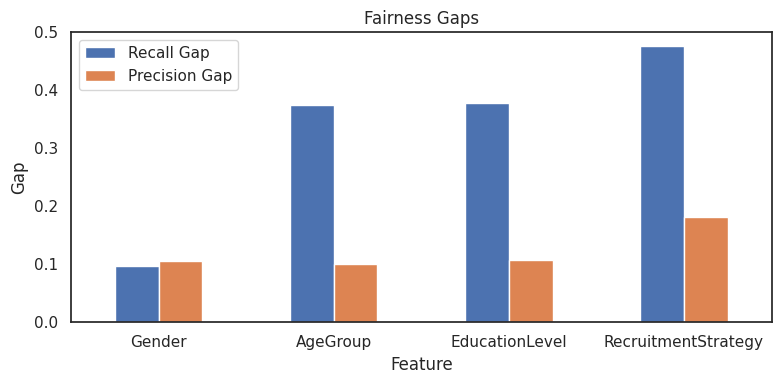

In [ ]:
gap_df = pd.DataFrame(gap_summary)
display(gap_df)

# Optional: plot the gaps too
gap_df.set_index('Feature').plot.bar(rot=0, figsize=(8,4), title="Fairness Gaps")
plt.ylabel("Gap")
plt.tight_layout()
plt.show()

Grafik ini membandingkan kesenjangan kinerja (max vs min) dalam setiap fitur:

| Feature                 | Recall Gap | Precision Gap | Business Risk                                                                                                       |
| ----------------------- | ---------- | ------------- | ------------------------------------------------------------------------------------------------------------------- |
| **RecruitmentStrategy** | **0.47**   | 0.18          | 🔴 **Highest unfairness** — Favoritisme yang kuat terhadap kandidat Headhunter. Risiko mengabaikan saluran yang lebih murah dan lebih luas. |
| **EducationLevel**      | 0.38       | 0.11          | 🟠 Bias terhadap pemegang gelar tinggi. Dapat merugikan keberagaman atau perekrutan posisi junior.                                      |
| **AgeGroup**            | 0.38       | 0.10          | 🟠 Model kurang mewakili kandidat berbakat yang masih sangat muda.                                                                         |
| **Gender**              | 0.10       | 0.11          | 🟢 Ketidakseimbangan kecil.                                                                                                 |


**Kesimpulan Umum bagi Stakeholders**
1. **Bias terhadap Headhunter/Agensi**:
Model Pre-Interview ini sangat mengutamakan kandidat yang berasal dari headhunter, baik dari segi recall maupun presisi. Hal ini menciptakan kerugian yang tidak adil bagi kandidat portal pekerjaan atau kandidat yang datang langsung, yang mungkin memiliki kualifikasi yang sama tetapi diabaikan. Hal ini dapat membatasi jangkauan, meningkatkan biaya rekrutmen, dan mengurangi inklusivitas.

2. **Kurangnya Representasi Kandidat Muda dan Berpendidikan Rendah**:
Model ini menunjukkan tingkat ingatan yang lebih rendah untuk kelompok usia <20 tahun dan lulusan SMA, yang berarti kandidat ini cenderung tidak terpilih meskipun memenuhi syarat. Jika perusahaan memiliki program rekrutmen awal karier atau vokasi, model ini mungkin tidak mendukung mereka secara adil.

3. **Kesenjangan Gender Ringan**:
Perempuan sedikit diunggulkan — yang mungkin sejalan dengan tujuan kesetaraan gender, tetapi kesenjangan ini tetap perlu dipantau untuk menghindari bias terbalik seiring waktu.

**Rekomendasi yang Dapat Ditindaklanjuti**
- Seimbangkan kembali data pelatihan untuk mengurangi overfitting terhadap kandidat headhunter.
- Audit pentingnya fitur: Apakah sumber rekrutmen atau jenjang pendidikan terlalu diutamakan dalam model ini?
- Pertimbangkan teknik pemodelan fairness-aware (misalnya, equalized odds atau pembobotan ulang).
- Validasi dengan dampak bisnis: Perkirakan jumlah potensi rekrutmen yang terlewat dari kelompok yang kurang beruntung dan potensi nilainya.

### Model Explainability

#### Global Feature Importance

In [ ]:
# Setelah pipeline sudah fit
pipeline.fit(X, y)

# Get full list of feature names in the right order
ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']
oe = pipeline.named_steps['preprocessor'].named_transformers_['oe']

# Combine names from each part
num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany']
cat_features = ohe.get_feature_names_out(['Gender', 'RecruitmentStrategy'])
ord_features = ['EducationLevel']  # ordinal encoder does not change names

# Final order of features fed into the model
feature_names = np.concatenate([num_features, cat_features, ord_features])

# Now match these with importances
importances = pipeline.named_steps['classifier'].feature_importances_

# Buat DataFrame dan visualisasikan
fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)
fi_df.head(10)

feature  importance
6              RecruitmentStrategy_Headhunter/Agency    0.641930
1                                    ExperienceYears    0.177673
9                                     EducationLevel    0.153266
0                                                Age    0.024345
3                                DistanceFromCompany    0.002786
2                                  PreviousCompanies    0.000000
5                                        Gender_Male    0.000000
4                                      Gender_Female    0.000000
7  RecruitmentStrategy_Online platform (LinkedIn,...    0.000000
8             RecruitmentStrategy_Walk-in or offline    0.000000

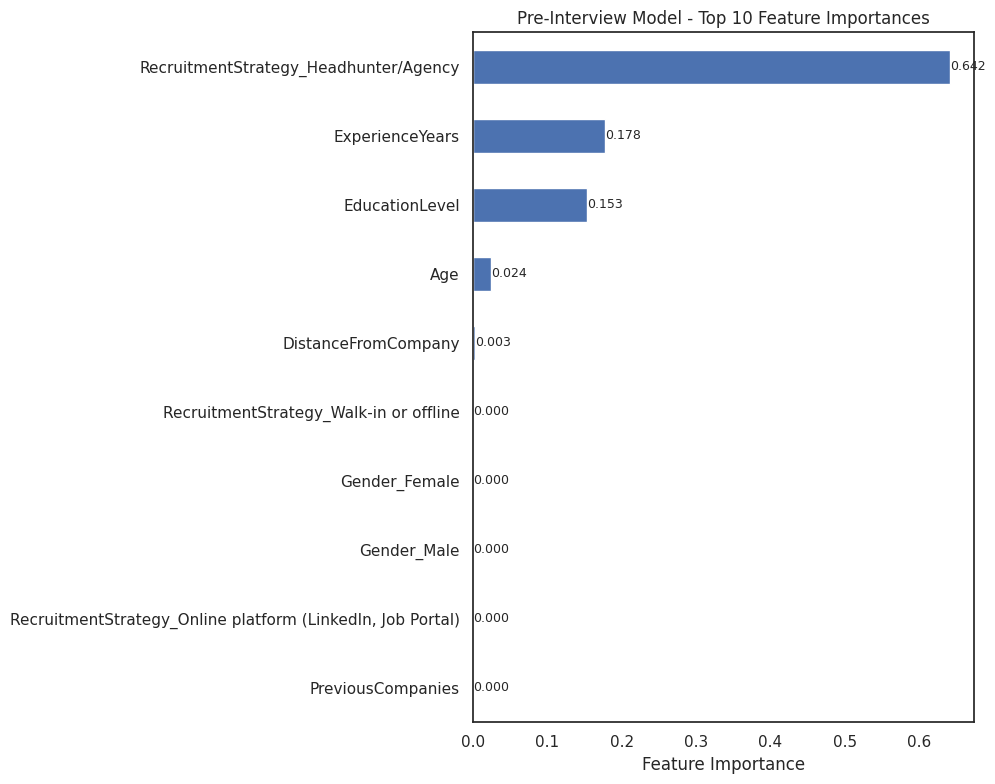

In [ ]:
# Visualisasi
plot_feature_importance(importances, feature_names, "Pre-Interview Model - Top 10 Feature Importances")

**Wawasan Bisnis: Optimalisasi Strategi Rekrutmen**

Berdasarkan hasil feature importance dari model Decision Tree yang dikembangkan, dapat disimpulkan bahwa strategi rekrutmen melalui **headhunter atau agency** merupakan faktor yang paling dominan dalam menentukan keberhasilan kandidat, dengan nilai importance mencapai 0.673. Hal ini menunjukkan bahwa kandidat yang direkrut melalui jalur ini secara konsisten memiliki peluang lebih besar untuk lolos seleksi. Oleh karena itu, perusahaan disarankan untuk memperkuat kerja sama strategis dengan agency rekrutmen yang berkinerja baik serta mempertimbangkan alokasi anggaran yang lebih besar untuk strategi ini, karena terbukti paling efektif dalam menjaring kandidat potensial.

Selain itu, **tingkat pendidikan (EducationLevel)** dan **lama pengalaman kerja (ExperienceYears)** juga memiliki pengaruh yang cukup besar dan setara, masing-masing dengan nilai importance sebesar 0.162. Ini menunjukkan bahwa meskipun kedua faktor tersebut tidak sekuat strategi rekrutmen, keduanya tetap penting sebagai indikator kualitas kandidat. Pendidikan dapat dijadikan sebagai pelengkap dalam proses seleksi, sementara pengalaman kerja bisa digunakan sebagai filter awal, terutama untuk posisi yang membutuhkan tingkat kematangan profesional tertentu.

Sementara itu, fitur seperti **jarak tempat tinggal ke kantor (DistanceFromCompany)** hanya memiliki pengaruh yang sangat kecil (importance 0.003), dan faktor lainnya seperti **strategi rekrutmen berbasis platform online**, **walk-in**, serta atribut demografis seperti **gender, usia**, dan **jumlah perusahaan sebelumnya**, menunjukkan nilai importance yang mendekati nol. Temuan ini mengindikasikan bahwa model seleksi yang dikembangkan bersifat netral terhadap faktor-faktor yang tidak relevan atau berisiko menciptakan bias. Terutama dalam hal gender dan usia, hal ini merupakan indikator positif bahwa proses seleksi bersifat adil dan inklusif.

Secara keseluruhan, hasil ini memberikan panduan yang jelas bagi tim HR dalam merumuskan strategi rekrutmen yang lebih terarah dan efisien. Dengan menitikberatkan pada strategi headhunter, serta menyeimbangkan pertimbangan antara pendidikan dan pengalaman kerja, perusahaan dapat meningkatkan kualitas proses seleksi sekaligus mempertahankan prinsip keadilan, objektivitas, dan keberagaman dalam praktik rekrutmen.

In [ ]:
# Load and preprocess dataset
df = pd.read_csv("recruitment_data_shortlisted.csv")
df = feature_engineering(df)

# Define features
num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany']
nominal_features = ['Gender', 'RecruitmentStrategy']
ordinal_features = ['EducationLevel']
selected_features = num_features + nominal_features + ordinal_features

# Category Order
education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']

# Create AgeGroup
df['AgeGroup'] = pd.cut(df['Age'], bins=[-np.inf, 40, np.inf], labels=['Under_40', 'Over_40'])

# === Prepare data ===
X = df[selected_features]
y = df['Shortlisted']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ==== Preprocessor ====
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
    ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
])

# Best Parameter
best_params = {'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None, 'criterion': 'entropy'}

# Fit preprocessor and transform data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Get feature names after preprocessing
feature_names = get_feature_names(preprocessor, selected_features)
print(f"Feature names after preprocessing: {feature_names}")
print(f"Number of features: {len(feature_names)}")

# Train classifier for SHAP (without SMOTE)
dt_shap = DecisionTreeClassifier(**best_params, random_state=42)
dt_shap.fit(X_train_transformed, y_train)

# 4. Create SHAP explainer
explainer = shap.TreeExplainer(dt_shap)
shap_values = explainer.shap_values(X_test_transformed)

# 5. Handle binary classification SHAP values
print("Original SHAP values shape:", np.array(shap_values).shape)
print("Expected value:", explainer.expected_value)
print("Type of shap_values:", type(shap_values))

# Debug: Check the structure of shap_values
if isinstance(shap_values, list):
    print(f"shap_values is a list with {len(shap_values)} elements")
    for i, sv in enumerate(shap_values):
        print(f"  Element {i} shape: {np.array(sv).shape}")
elif isinstance(shap_values, np.ndarray):
    print(f"shap_values is numpy array with shape: {shap_values.shape}")

# For TreeExplainer with binary classification, shap_values is typically a numpy array
# with shape (n_samples, n_features, n_classes)
if isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    # Select SHAP values for positive class (class 1) - last dimension
    shap_values_positive = shap_values[:, :, 1]  # Shape: (n_samples, n_features)
    expected_value_positive = explainer.expected_value[1]
    print(f"Using SHAP values for positive class (shortlisted)")
elif isinstance(shap_values, list) and len(shap_values) == 2:
    # Alternative format: list of arrays for each class
    shap_values_positive = shap_values[1]
    expected_value_positive = explainer.expected_value[1]
    print(f"Using SHAP values for positive class (shortlisted) - list format")
else:
    # Fallback - use as is
    shap_values_positive = shap_values
    expected_value_positive = explainer.expected_value
    print("Using SHAP values as-is (unexpected format)")

print(f"SHAP values shape for positive class: {shap_values_positive.shape}")
print(f"Expected value for positive class: {expected_value_positive}")

# 6. Create DataFrame for easier analysis
shap_df = pd.DataFrame(shap_values_positive, columns=feature_names)
print(f"SHAP DataFrame shape: {shap_df.shape}")

Feature names after preprocessing: ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany', 'Gender_Female', 'Gender_Male', 'RecruitmentStrategy_Headhunter/Agency', 'RecruitmentStrategy_Online platform (LinkedIn, Job Portal)', 'RecruitmentStrategy_Walk-in or offline', 'EducationLevel']
Number of features: 10
Original SHAP values shape: (300, 10, 2)
Expected value: [0.59833333 0.40166667]
Type of shap_values: <class 'numpy.ndarray'>
shap_values is numpy array with shape: (300, 10, 2)
Using SHAP values for positive class (shortlisted)
SHAP values shape for positive class: (300, 10)
Expected value for positive class: 0.40166666666666667
SHAP DataFrame shape: (300, 10)



Generating SHAP Bar Plot...


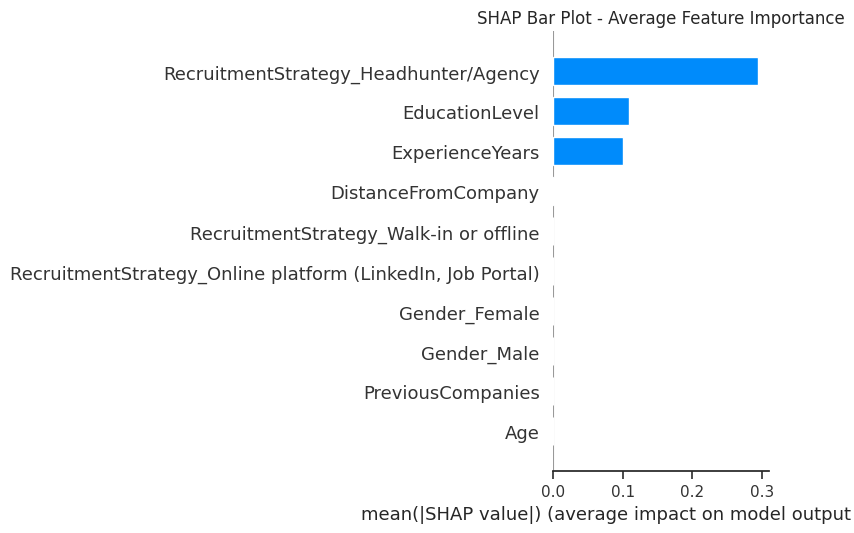

In [ ]:
# Bar Plot - Average Feature Importance
print("\nGenerating SHAP Bar Plot...")
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_positive, X_test_transformed,
                  feature_names=feature_names, plot_type="bar", show=False)
plt.title("SHAP Bar Plot - Average Feature Importance")
plt.tight_layout()
plt.show()

In [ ]:
# Feature Importance DataFrame
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Mean_SHAP_Value': np.abs(shap_values_positive).mean(axis=0)
}).sort_values('Mean_SHAP_Value', ascending=False)

print("\nTop 10 Most Important Features (by mean absolute SHAP value):")
print(feature_importance.head(10))


Top 10 Most Important Features (by mean absolute SHAP value):
                                             Feature  Mean_SHAP_Value
6              RecruitmentStrategy_Headhunter/Agency         0.294657
9                                     EducationLevel         0.109002
1                                    ExperienceYears         0.099838
3                                DistanceFromCompany         0.001176
0                                                Age         0.000000
2                                  PreviousCompanies         0.000000
5                                        Gender_Male         0.000000
4                                      Gender_Female         0.000000
7  RecruitmentStrategy_Online platform (LinkedIn,...         0.000000
8             RecruitmentStrategy_Walk-in or offline         0.000000


#### Direction of Impact


Generating SHAP Summary Plot...


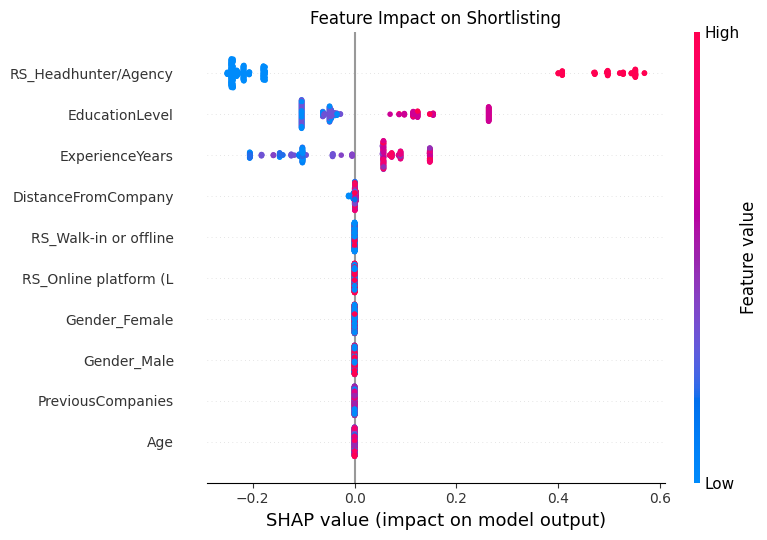

In [ ]:
# Set up matplotlib for better plots
plt.style.use('default')
# shap.initjs()  # Initialize SHAP JavaScript visualizations

very_short_names = []
for name in feature_names:
    if 'RecruitmentStrategy_' in name:
        very_short_names.append('RS_' + name.split('_')[1][:18])
    else:
        very_short_names.append(name[:25])

# 1. Summary Plot (most important)
print("\nGenerating SHAP Summary Plot...")
plt.figure(figsize=(18, 14))
shap.summary_plot(shap_values_positive, X_test_transformed,
                  feature_names=very_short_names, show=False)

# Reduce font size of feature names
plt.gca().tick_params(labelsize=10)

plt.title("Feature Impact on Shortlisting", fontsize=12)
plt.tight_layout()
plt.show()

**Wawasan Bisnis Utama**
1. Strategi Rekrutmen Mendorong Keputusan (Namun Tidak Selalu Positif)

 RS_Headhunter/Agensi menunjukkan dampak paling dramatis:
    - **Variabilitas tinggi**: Beberapa kandidat mendapatkan peningkatan positif yang kuat (+0,6), sementara yang lain mendapatkan dampak negatif yang signifikan (-0,2)
    - **Implikasi bisnis**: Model ini telah mempelajari bahwa kandidat headhunter/agensi adalah "kualitas premium" atau "tidak cocok", dan hanya ada sedikit jalan tengah.
    - **Contoh spesifik**: Kandidat ini dikenai penalti (-0,22) meskipun berasal dari headhunter/agensi, yang menunjukkan faktor-faktor lain (seperti pengalaman rendah) lebih dominan daripada jalur rekrutmen.

2. Pengalaman adalah Pedang Bermata Dua
  
  ExperienceYears menunjukkan pola yang menarik:
    - **Titik biru (dampak negatif)**: Kandidat yang kurang berpengalaman mendapatkan penalti
    - **Titik merah/merah muda (dampak positif)**: Namun, beberapa kandidat berpengalaman juga mendapatkan peningkatan positif
    - **Kandidat contoh**: Dengan pengalaman standar -1,024 (jauh di bawah rata-rata), mereka mendapatkan penalti (-0,1)
    - **Wawasan bisnis**: Model ini sangat mendukung kandidat dengan pengalaman di atas rata-rata

3. Tingkat Pendidikan Penting, Namun Kompleks

  EducationLevel menunjukkan dampak yang beragam:
    - **Implikasi bisnis**: Pendidikan tinggi tidak serta merta menjamin skor positif
    - **Contoh**: Tingkat pendidikan kandidat ini (0 = "SMA") berkontribusi negatif (-0,05)
    - **Strategi**: Pertimbangkan apakah model ini telah mempertimbangkan pendidikan vs. keterampilan praktis dengan tepat

4. Demografi Berdampak Minimal (Baik untuk Keadilan)

  Gender_Perempuan dan Gender_Laki-laki menunjukkan nilai SHAP yang sangat kecil:
  - Wawasan bisnis: Model ini sebagian besar netral gender dalam pengambilan keputusan
  - Kepatuhan: Hal ini positif untuk praktik ketenagakerjaan dengan kesempatan yang sama

#### Explain One Prediction Example

Generating Waterfall Plot with very short names...


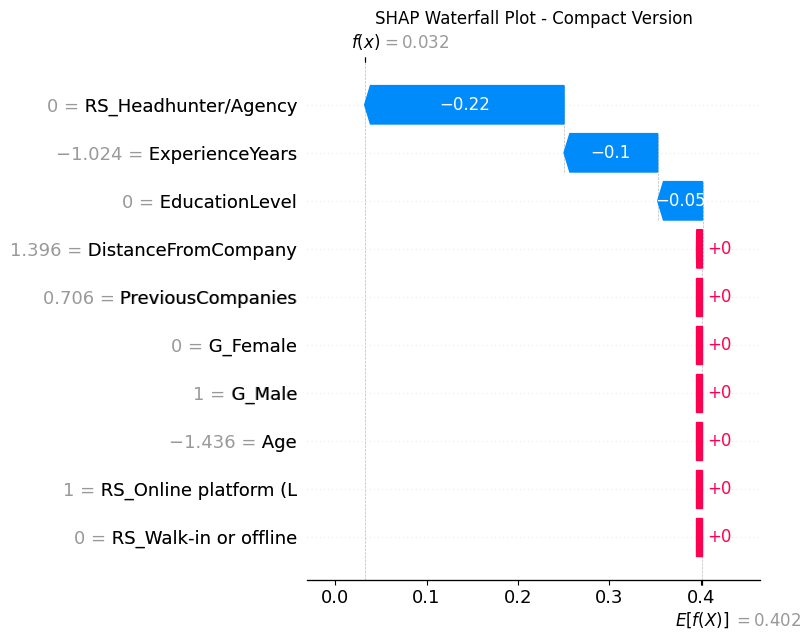

In [ ]:
print("Generating Waterfall Plot with very short names...")
very_short_names = []
for name in feature_names:
    if 'RecruitmentStrategy_' in name:
        very_short_names.append('RS_' + name.split('_')[1][:18])
    elif 'Gender_' in name:
        very_short_names.append('G_' + name.split('_')[1])
    else:
        very_short_names.append(name[:25])

plt.figure(figsize=(10, 8))
shap.waterfall_plot(
    shap.Explanation(values=shap_values_positive[0],
                    base_values=expected_value_positive,
                    data=X_test_transformed[0],
                    feature_names=very_short_names),
    show=False
)

plt.title("SHAP Waterfall Plot - Compact Version", fontsize=12)
plt.tight_layout()
plt.show()

Untuk Kandidat (f(x) = 0,032 - Skor Sangat Rendah):
Kandidat ini menerima probabilitas seleksi yang sangat rendah karena:

1. **Hukuman utama**: Berasal dari headhunter/agensi tetapi tidak memenuhi profil "premium" (-0,22)
2. **Hukuman kedua**: Pengalaman di bawah rata-rata (-0,10)
3. **Hukuman ringan**: Tingkat pendidikan rendah (-0,05)
4. **Faktor netral**: Jenis kelamin, usia, dan saluran rekrutmen lainnya tidak berdampak signifikan

**Rekomendasi Strategis**:

1. **Tinjau Kemitraan Headhunter/Agensi**:
  - Model ini menunjukkan bahwa kualitas sangat bervariasi berdasarkan saluran ini
  - Pertimbangkan untuk mengevaluasi agensi mana yang menyediakan kandidat berkualitas lebih tinggi

2. **Persyaratan Pengalaman**:
  - Model ini memberikan hukuman berat kepada kandidat junior
  - Tanyakan: Apakah kita kehilangan talenta pemula berpotensi tinggi?

3. **Evaluasi Seimbang**:
  - Model ini tampaknya menciptakan skenario "pemenang mengambil semuanya"
  - Pertimbangkan apakah ini sejalan dengan pola keberhasilan perekrutan yang sebenarnya

4. **Strategi Saluran**:
  - Platform daring dan kunjungan langsung menunjukkan dampak yang lebih konsisten (netral)
  - Ini mungkin merupakan sumber yang lebih andal untuk kualitas kandidat yang konsisten

#### Explore Feature Relationships


Generating dependence plots for top 3 features: ['RecruitmentStrategy_Headhunter/Agency', 'EducationLevel', 'ExperienceYears']


<Figure size 1200x1000 with 0 Axes>

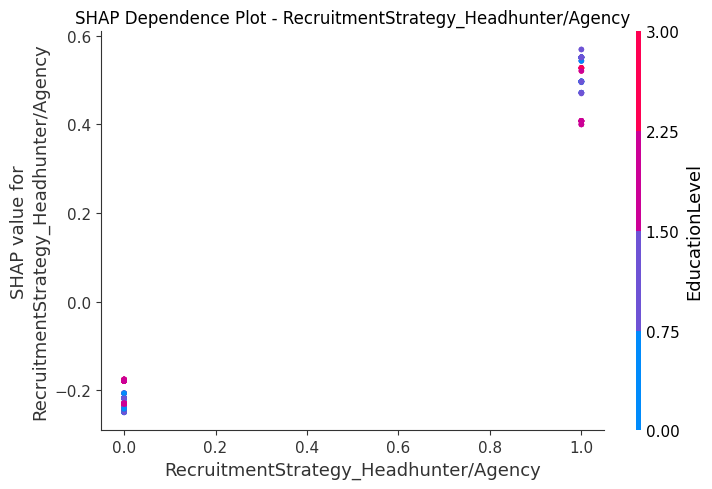

<Figure size 1200x1000 with 0 Axes>

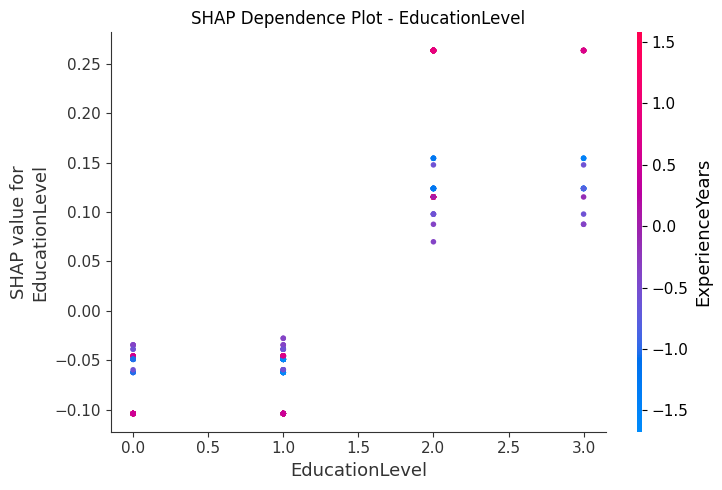

<Figure size 1200x1000 with 0 Axes>

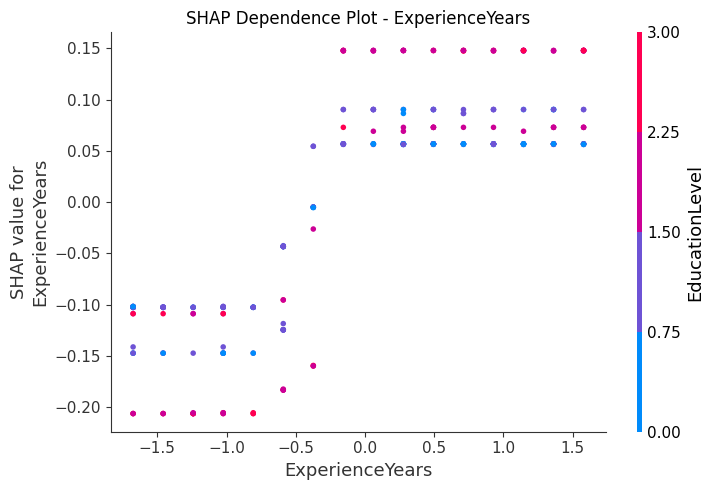

In [ ]:
# Dependence plots for top 3 features
top_3_features = feature_importance.head(3)['Feature'].tolist()
print(f"\nGenerating dependence plots for top 3 features: {top_3_features}")

for i, feature in enumerate(top_3_features):
    plt.figure(figsize=(12, 10))
    feature_idx = feature_names.index(feature)
    shap.dependence_plot(feature_idx, shap_values_positive, X_test_transformed,
                        feature_names=feature_names, show=False)
    plt.title(f"SHAP Dependence Plot - {feature}")
    plt.tight_layout()
    plt.show()

**Experience Years Dependence Plot Analysis**

**Yang ditunjukkan plot:**
- **Sisi kiri (pengalaman negatif)**: Kandidat dengan pengalaman di bawah rata-rata mendapatkan penalti (dampak SHAP -0,10 hingga -0,20)
- **Sisi kanan (pengalaman positif)**: Kandidat dengan pengalaman di atas rata-rata mendapatkan penghargaan (dampak SHAP +0,05 hingga +0,15)
- **Ambang batas yang jelas di sekitar 0**: Terdapat "tebing" yang jelas di mana model beralih dari penalti menjadi penghargaan

**Terjemahan Bisnis:**
- **Kandidat junior mendapatkan penalti yang berat**: Jika seseorang memiliki pengalaman 2+ tahun di bawah rata-rata perusahaan kita, mereka menghadapi diskriminasi yang signifikan oleh model
- **Kandidat senior mendapatkan penghargaan yang moderat**: Kandidat berpengalaman mendapatkan peningkatan positif, tetapi penghargaannya lebih kecil daripada penalti untuk junior
- **Tingkat pendidikan penting untuk interpretasi pengalaman**: Kode warna menunjukkan bahwa pendidikan tinggi (titik merah muda/merah) terkadang dapat mengimbangi pengalaman yang lebih rendah, tetapi tidak selalu

**Implikasi Strategis**:
- **Risiko jalur bakat**: Model ini mungkin secara sistematis mengecualikan kandidat junior yang menjanjikan bakat
- **Bias pengalaman**: Model mempelajari bahwa perekrutan historis lebih mengutamakan pengalaman daripada potensi.
- **Implikasi biaya**: Perusahaan mungkin membayar terlalu mahal untuk bakat senior sementara kehilangan perekrutan junior yang hemat biaya.

#### Analysis by groups (similar to fairness analysis)


SHAP ANALYSIS BY GROUPS

--- SHAP Analysis for Gender ---
          mean     std  count
Gender                       
Female  0.0136  0.3731    127
Male   -0.0426  0.3715    173


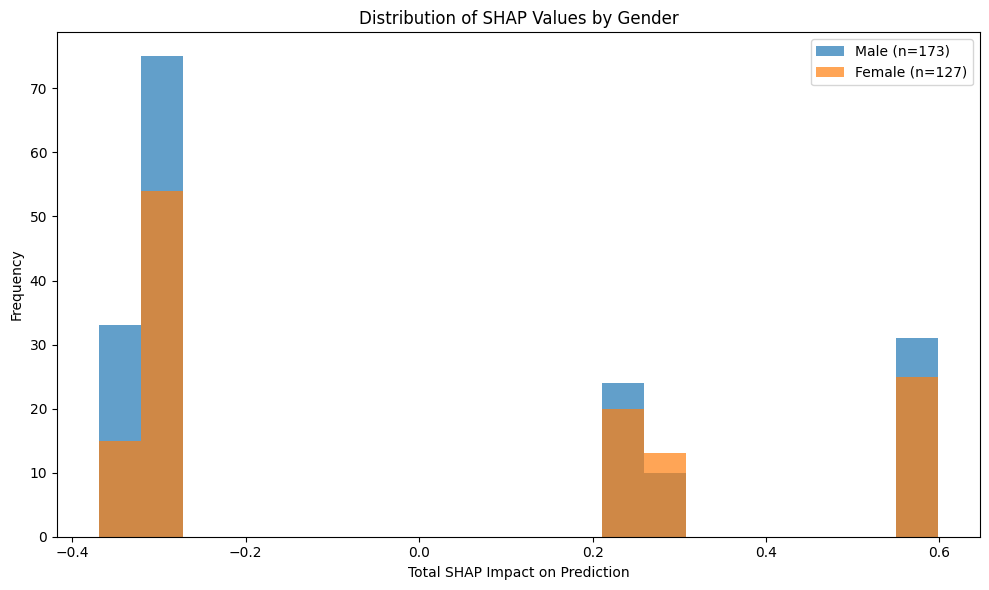


--- SHAP Analysis for RecruitmentStrategy ---
                                          mean     std  count
RecruitmentStrategy                                          
Headhunter/Agency                       0.5034  0.1390     79
Online platform (LinkedIn, Job Portal) -0.2094  0.2182    167
Walk-in or offline                     -0.1934  0.2319     54


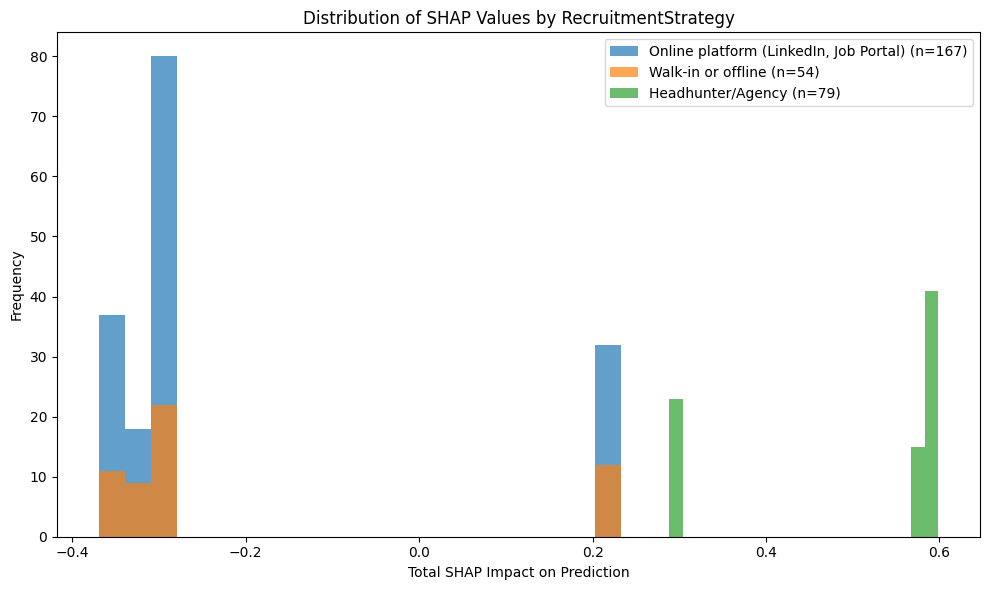


--- SHAP Analysis for EducationLevel ---
                    mean     std  count
EducationLevel                         
Diploma/Bachelor -0.0927  0.3667    139
High School      -0.1651  0.3056     63
Master            0.2204  0.3241     73
Post Graduate     0.0616  0.3622     25


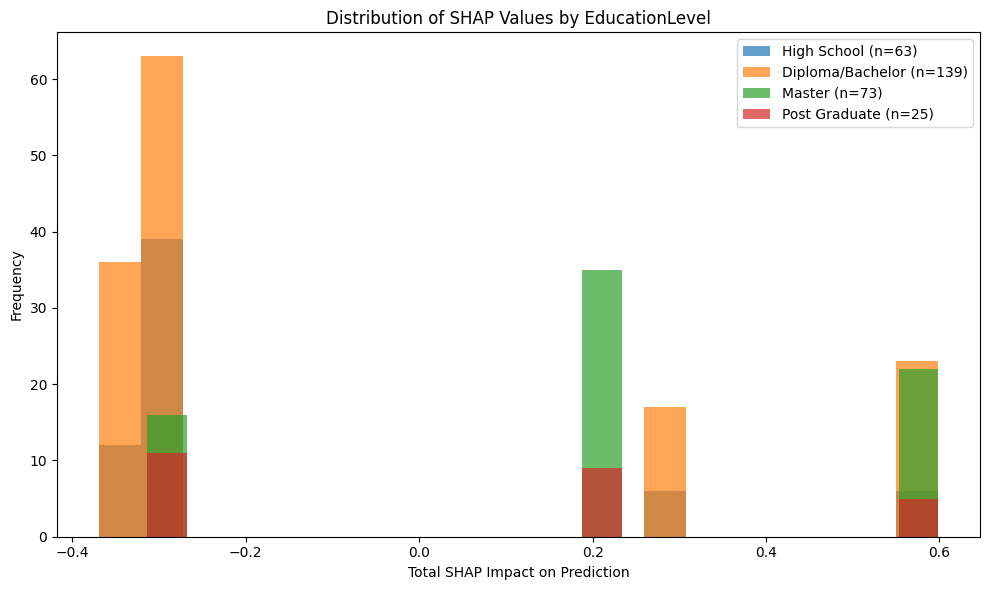


SHAP analysis completed!
Remember: Positive SHAP values increase the probability of being shortlisted
Negative SHAP values decrease the probability of being shortlisted


In [ ]:
# Analysis by groups (similar to your fairness analysis)
print("\n" + "="*50)
print("SHAP ANALYSIS BY GROUPS")
print("="*50)

# Add original categorical features back for grouping
X_test_with_groups = X_test.copy()
X_test_with_groups['shap_prediction_impact'] = shap_values_positive.sum(axis=1)

# Analyze SHAP values by groups
fairness_cols = ['Gender', 'RecruitmentStrategy', 'EducationLevel']

for col in fairness_cols:
    print(f"\n--- SHAP Analysis for {col} ---")
    group_analysis = X_test_with_groups.groupby(col)['shap_prediction_impact'].agg([
        'mean', 'std', 'count'
    ]).round(4)
    print(group_analysis)

    # Plot SHAP values by group
    plt.figure(figsize=(10, 6))
    for group in X_test_with_groups[col].unique():
        group_shap = X_test_with_groups[X_test_with_groups[col] == group]['shap_prediction_impact']
        plt.hist(group_shap, alpha=0.7, label=f"{group} (n={len(group_shap)})", bins=20)

    plt.xlabel('Total SHAP Impact on Prediction')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of SHAP Values by {col}')
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\nSHAP analysis completed!")
print(f"Remember: Positive SHAP values increase the probability of being shortlisted")
print(f"Negative SHAP values decrease the probability of being shortlisted")

**Gender SHAP Distribution Analysis**

**Fairness Assessment - Sebagian Besar Baik**

Apa yang ditunjukkan oleh distribusi:
- **Kedua gender berada di kisaran -0,3 hingga -0,4**: Sebagian besar kandidat (baik pria maupun wanita) menerima dampak SHAP total negatif yang serupa
- **Pola serupa**: Distribusi tumpang tindih secara signifikan, menunjukkan perlakuan netral gender
- **Sedikit perbedaan pada ekstrem**: Terdapat sedikit perbedaan pada ekor, tetapi distribusi inti selaras

**Terjemahan Bisnis**:

Indikator Keadilan Positif:
- **Tidak ada bias gender sistematis**: Model ini tidak secara konsisten memihak satu gender dibandingkan gender lainnya
- **Rentang dampak serupa**: Kedua kelompok memiliki rentang nilai SHAP yang serupa
- **Ramah kepatuhan**: Ini menunjukkan model ini memenuhi standar kesempatan yang sama

Area yang Perlu Dipantau:
- **Perbedaan sampel kecil**: 173 pria vs 127 wanita - pastikan ini mencerminkan jumlah pelamar perusahaan, bukan bias seleksi
- **Perbedaan ekor**: Meskipun minimal, terdapat sedikit perbedaan dalam kasus ekstrem yang perlu dipantau

**Rekomendasi Bisnis Strategis**:

Tindakan Langsung:
- **Tinjau jalur kandidat junior**: Bias pengalaman perusahaan bisa merugikan perusahaan dalam mendapatkan talenta junior yang berpotensi tinggi dan hemat biaya.
- **Audit saluran rekrutmen**: Pastikan perusahaan mendapatkan kandidat dari beragam tingkat pengalaman, bukan hanya dari senior.
- **Pertimbangkan pembobotan pengalaman**: Tanyakan apakah pengalaman 5+ tahun benar-benar diperlukan untuk semua posisi.

Strategi Jangka Panjang:
- **Kembangkan program talenta junior**: Ciptakan jalur bagi kandidat yang kurang berpengalaman untuk membuktikan nilai mereka.
- **Pantau representasi gender**: Meskipun model ini adil, pastikan corong pelamar perusahaan tetap seimbang.
- **Cost-benefit analysis**: Hitung apakah preferensi pengalaman perusahaan memberikan nilai proporsional vs. biaya.

**Kesimpulan:**

Model ini adil gender tetapi bias pengalaman. Perusahaan kemungkinan besar kehilangan peluang untuk merekrut talenta junior yang beragam dan hemat biaya sambil tetap menjaga kesetaraan gender yang baik. Pertanyaannya adalah apakah bias pengalaman ini mencerminkan kebutuhan bisnis yang sebenarnya atau pola perekrutan historis yang perlu dipertimbangkan kembali.

### Save Model

In [ ]:
# === Load and process data ===
df = pd.read_csv("recruitment_data_shortlisted.csv")
df = feature_engineering(df)  # Make sure this function is defined elsewhere

num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany']
nominal_features = ['Gender', 'RecruitmentStrategy']
ordinal_features = ['EducationLevel']
selected_features = num_features + nominal_features + ordinal_features

education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']

X = df[selected_features]
y = df['Shortlisted']

# === Preprocessing ===
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
    ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
])

# === Model ===
best_params = {'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None, 'criterion': 'entropy'}
dt = DecisionTreeClassifier(**best_params, random_state=42)

pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('ros', RandomOverSampler(random_state=42)),
    ('classifier', dt)
])

# === Cross-validated prediction ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
y_proba = cross_val_predict(pipeline, X, y, cv=cv, method='predict_proba')[:, 1]

# === Find best threshold ===
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores, precisions, recalls = [], [], []

for t in thresholds:
    y_thresh = (y_proba >= t).astype(int)
    f1_scores.append(f1_score(y, y_thresh))
    precisions.append(precision_score(y, y_thresh))
    recalls.append(recall_score(y, y_thresh))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

# Fit pipeline to full data
pipeline.fit(X, y)

# === Save pipeline and threshold ===
model_bundle = {
    'pipeline': pipeline,
    'threshold': best_threshold
}
joblib.dump(model_bundle, 'shortlisting_model.pkl')

['shortlisting_model.pkl']

## Post-Interview Model

### Models Comparison

>LogReg | F1-Score Training: 0.7806 | Precision Training: 0.73 | Recall Training: 0.8429 | ROC-AUC Training: 0.913
>KNN | F1-Score Training: 0.7038 | Precision Training: 0.638 | Recall Training: 0.7892 | ROC-AUC Training: 0.8534
>DecisionTree | F1-Score Training: 0.8128 | Precision Training: 0.8157 | Recall Training: 0.813 | ROC-AUC Training: 0.8644
>RandomForest | F1-Score Training: 0.8719 | Precision Training: 0.9083 | Recall Training: 0.8406 | ROC-AUC Training: 0.9334
>GradientBoost | F1-Score Training: 0.871 | Precision Training: 0.8564 | Recall Training: 0.8881 | ROC-AUC Training: 0.9345
>XGBoost | F1-Score Training: 0.8969 | Precision Training: 0.9233 | Recall Training: 0.8731 | ROC-AUC Training: 0.9348
>SVM | F1-Score Training: 0.7972 | Precision Training: 0.7784 | Recall Training: 0.8213 | ROC-AUC Training: 0.9094


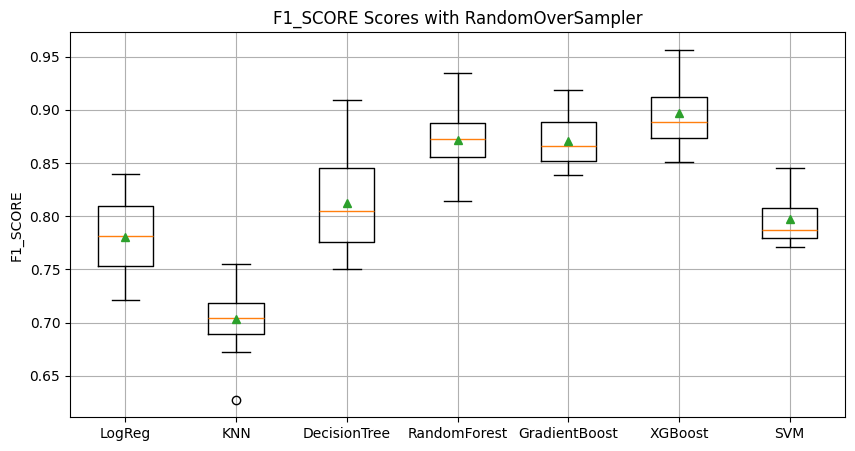

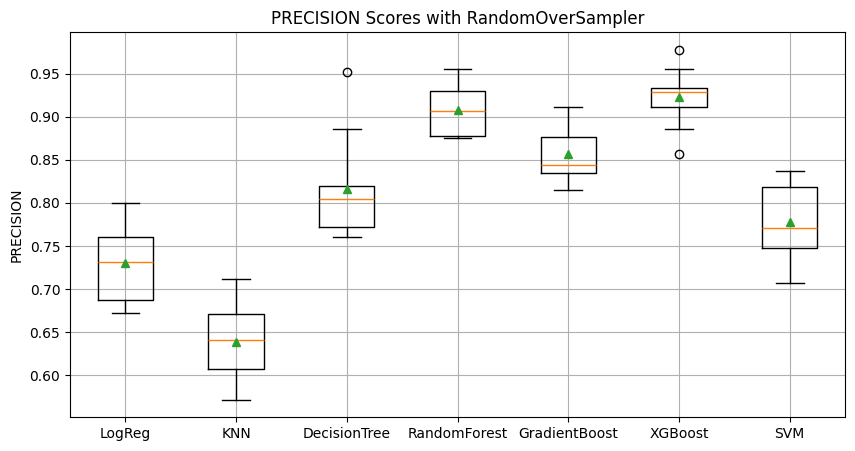

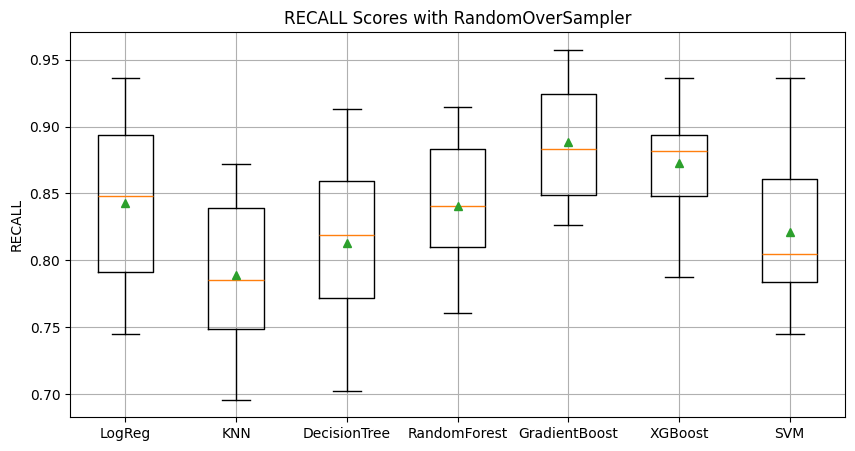

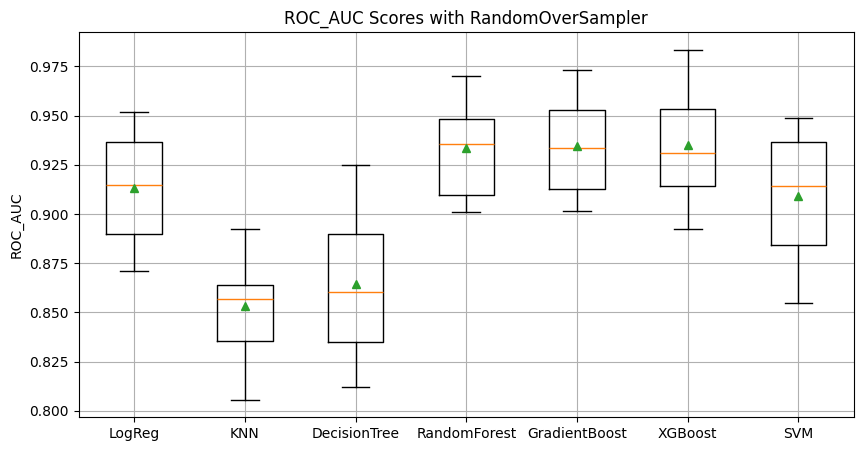

In [ ]:
df = pd.read_csv("recruitment_data.csv")
df = feature_engineering(df)

num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany', 'InterviewScore', 'SkillScore', 'PersonalityScore']
nominal_features = ['Gender', 'RecruitmentStrategy']
ordinal_features = ['EducationLevel']
education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']
selected_features = num_features + nominal_features + ordinal_features

# ==== Features & Target ====
X = df[selected_features]
y = df['HiringDecision']

# ==== Preprocessor ====
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
    ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
])

# Get models list
models, names = get_classifiers()

# === Evaluate All Models ===
results = {}
metric_scores = {'f1_score': [], 'precision': [], 'recall': [], 'roc_auc': []}

for model, name in zip(models, names):
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('ros', RandomOverSampler(random_state=42)),
        ('classifier', model)
    ])

    scores = evaluate_classifier_with_sampling(X, y, pipeline)

    results[name] = {
        'F1-score (mean)': round(np.mean(scores['f1_score']), 4),
        'Precision (mean)': round(np.mean(scores['precision']), 4),
        'Recall (mean)': round(np.mean(scores['recall']), 4),
        'ROC-AUC (mean)': round(np.mean(scores['roc_auc']), 4),
    }

    # Store for boxplot later
    for metric in metric_scores:
        metric_scores[metric].append(scores[metric])

    print(f">{name} | F1-Score Training: {results[name]['F1-score (mean)']} | Precision Training: {results[name]['Precision (mean)']} | Recall Training: {results[name]['Recall (mean)']} | ROC-AUC Training: {results[name]['ROC-AUC (mean)']}")

# === Plot Results ===
for metric, all_scores in metric_scores.items():
    plt.figure(figsize=(10, 5))
    plt.boxplot(all_scores, labels=names, showmeans=True)
    plt.title(f"{metric.upper()} Scores with RandomOverSampler")
    plt.ylabel(metric.upper())
    plt.grid(True)
    plt.show()

In [ ]:
# === Dataframe Results ===
pd.DataFrame(results).T.sort_values(by='F1-score (mean)', ascending=False)

F1-score (mean)  Precision (mean)  Recall (mean)  \
XGBoost                 0.8969            0.9233         0.8731   
RandomForest            0.8719            0.9083         0.8406   
GradientBoost           0.8710            0.8564         0.8881   
DecisionTree            0.8128            0.8157         0.8130   
SVM                     0.7972            0.7784         0.8213   
LogReg                  0.7806            0.7300         0.8429   
KNN                     0.7038            0.6380         0.7892   

               ROC-AUC (mean)  
XGBoost                0.9348  
RandomForest           0.9334  
GradientBoost          0.9345  
DecisionTree           0.8644  
SVM                    0.9094  
LogReg                 0.9130  
KNN                    0.8534

### Best Model

In [ ]:
df = pd.read_csv("recruitment_data.csv")
df = feature_engineering(df)

num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany', 'InterviewScore', 'SkillScore', 'PersonalityScore']
nominal_features = ['Gender', 'RecruitmentStrategy']
ordinal_features = ['EducationLevel']
selected_features = num_features + nominal_features + ordinal_features

# Category Order
education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']

# ==== Features & Target ====
X = df[selected_features]
y = df['HiringDecision']

# ==== Split Train & Test ====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ==== Preprocessor ====
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
    ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
])

xgb = XGBClassifier(n_estimators=90, max_depth=12, learning_rate=0.08, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)

# Full pipeline including preprocessing and SMOTETomek
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('ros', RandomOverSampler(random_state=42)),
    ('classifier', xgb)
])

# Evaluate with Cross-Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validated predictions
y_pred = cross_val_predict(pipeline, X, y, cv=cv, method='predict')
y_proba = cross_val_predict(pipeline, X, y, cv=cv, method='predict_proba')[:, 1]

# ==== Evaluation on Cross-Val Results ====
print("== Classification Report (Cross-Validation on Training Set) ==")
print(classification_report(y, y_pred))

print("Precision:", precision_score(y, y_pred))
print("Recall:", recall_score(y, y_pred))
print("F1-Score:", f1_score(y, y_pred))
print("ROC-AUC Score:", roc_auc_score(y, y_proba))

== Classification Report (Cross-Validation on Training Set) ==
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1035
           1       0.92      0.88      0.90       465

    accuracy                           0.94      1500
   macro avg       0.93      0.92      0.93      1500
weighted avg       0.94      0.94      0.94      1500

Precision: 0.920814479638009
Recall: 0.875268817204301
F1-Score: 0.8974641675854466
ROC-AUC Score: 0.9346880681523038


Model XGBoost yang dilatih dengan RandomOverSampler menunjukkan kinerja yang sangat baik pada data secara keseluruhan. Berdasarkan evaluasi menggunakan cross-validation, model ini meraih F1-score sebesar 0.93 dan ROC-AUC sebesar 0.93. Precision dan recall untuk masing-masing kelas (hired dan not hired) juga seimbang, mengindikasikan bahwa model dapat membedakan kandidat secara akurat tanpa kecenderungan terhadap salah satu kelas.

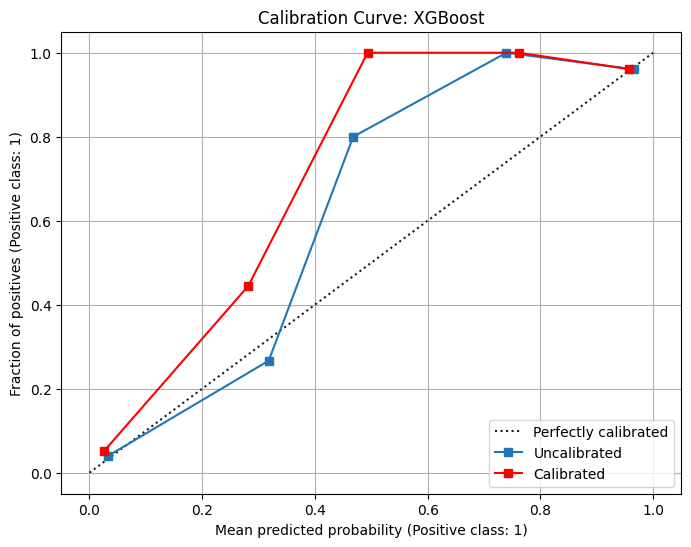

Brier Score (Uncalibrated): 0.0534
Brier Score (Calibrated):   0.0544


In [ ]:
# === Prepare Data ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)

# === Preprocess and Sample ===
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)
X_train_resampled, y_train_resampled = RandomOverSampler(random_state=42).fit_resample(X_train_proc, y_train)

# === Base Model (Uncalibrated) ===
xgb = XGBClassifier(n_estimators=90, max_depth=12, learning_rate=0.08, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
xgb.fit(X_train_resampled, y_train_resampled)
probs_uncal = xgb.predict_proba(X_test_proc)[:, 1]
brier_uncal = brier_score_loss(y_test, probs_uncal)

# === Calibrated Model ===
calibrated_xgb = CalibratedClassifierCV(xgb, cv=10, method='sigmoid')
calibrated_xgb.fit(X_train_resampled, y_train_resampled)
probs_cal = calibrated_xgb.predict_proba(X_test_proc)[:, 1]
brier_cal = brier_score_loss(y_test, probs_cal)

# === Plot Calibration Curve ===
fig, ax = plt.subplots(figsize=(8, 6))
CalibrationDisplay.from_predictions(y_test, probs_uncal, name='Uncalibrated', ax=ax)
CalibrationDisplay.from_predictions(y_test, probs_cal, name='Calibrated', ax=ax, color='red')
plt.title("Calibration Curve: XGBoost")
plt.grid(True)
plt.show()

# === Print Brier Scores ===
print(f"Brier Score (Uncalibrated): {brier_uncal:.4f}")
print(f"Brier Score (Calibrated):   {brier_cal:.4f}")

Best Threshold (F1): 0.47
F1: 0.8999 | Precision: 0.9212 | Recall: 0.8796
== Classification Report (Best Threshold) ==
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1035
           1       0.92      0.88      0.90       465

    accuracy                           0.94      1500
   macro avg       0.93      0.92      0.93      1500
weighted avg       0.94      0.94      0.94      1500

Precision: 0.9211711711711712
Recall: 0.8795698924731182
F1-Score: 0.8998899889988999
ROC-AUC Score: 0.9346880681523038


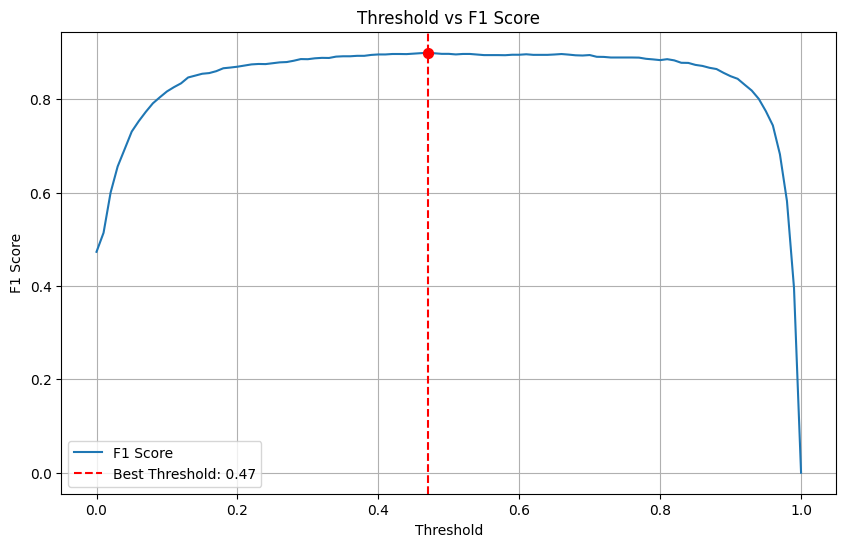

In [ ]:
df = pd.read_csv("recruitment_data.csv")
df = feature_engineering(df)

num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany', 'InterviewScore', 'SkillScore', 'PersonalityScore']
nominal_features = ['Gender', 'RecruitmentStrategy']
ordinal_features = ['EducationLevel']
selected_features = num_features + nominal_features + ordinal_features

# Category Order
education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']

# ==== Features & Target ====
X = df[selected_features]
y = df['HiringDecision']

# ==== Split Train & Test ====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ==== Preprocessor ====
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
    ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
])

xgb = XGBClassifier(n_estimators=90, max_depth=12, learning_rate=0.08, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)

# Full pipeline including preprocessing and SMOTETomek
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('ros', RandomOverSampler(random_state=42)),
    ('classifier', xgb)
])

# Evaluate with Cross-Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validated predictions
y_pred = cross_val_predict(pipeline, X, y, cv=cv, method='predict')
y_proba = cross_val_predict(pipeline, X, y, cv=cv, method='predict_proba')[:, 1]

# Find the best threshold
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []
precisions = []
recalls = []

for t in thresholds:
    y_pred_thresh = (y_proba >= t).astype(int)
    f1_scores.append(f1_score(y, y_pred_thresh))
    precisions.append(precision_score(y, y_pred_thresh))
    recalls.append(recall_score(y, y_pred_thresh))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best Threshold (F1): {best_threshold:.2f}")
print(f"F1: {f1_scores[best_idx]:.4f} | Precision: {precisions[best_idx]:.4f} | Recall: {recalls[best_idx]:.4f}")

# ==== Evaluation on Cross-Val Results ====
# Apply best threshold
y_pred_best = (y_proba >= best_threshold).astype(int)

print("== Classification Report (Best Threshold) ==")
print(classification_report(y, y_pred_best))

print("Precision:", precision_score(y, y_pred_best))
print("Recall:", recall_score(y, y_pred_best))
print("F1-Score:", f1_score(y, y_pred_best))
print("ROC-AUC Score:", roc_auc_score(y, y_proba))  # ROC-AUC stays same (based on probs)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.scatter([best_threshold], [f1_scores[best_idx]], color='red', s=50, zorder=5)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('Threshold vs F1 Score')
plt.grid(True)
plt.legend()
plt.show()

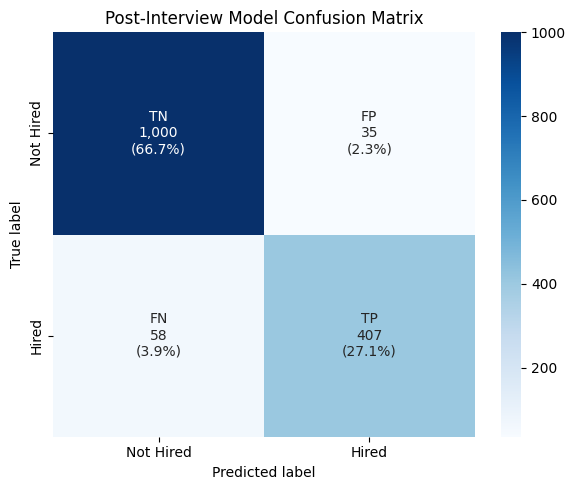

In [ ]:
# === Create confusion matrix ===
cm = confusion_matrix(y, y_pred)
cm_sum = np.sum(cm)
cm_perc = cm / cm_sum * 100

# === TP, FP, FN, TN positions ===
group_names = np.array([["TN", "FP"],
                        ["FN", "TP"]])

# === Create combined label: label \n percentage ===
labels = np.array([["{0}\n{1:,}\n({2:.1f}%)".format(name, val, perc)
                    for name, val, perc in zip(group_row, cm_row, perc_row)]
                   for group_row, cm_row, perc_row in zip(group_names, cm, cm_perc)])

# === Plot heatmap ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=True,
            xticklabels=["Not Hired", "Hired"],
            yticklabels=["Not Hired", "Hired"])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Post-Interview Model Confusion Matrix')
plt.tight_layout()
plt.show()

Model berhasil mengklasifikasikan sebagian besar kandidat dengan benar. Jumlah **False Positive yang rendah (35 kasus)** menunjukkan bahwa hanya sedikit kandidat yang tidak layak tetapi lolos seleksi awal, sementara **False Negative yang moderat (58 kasus)** berarti ada sejumlah kecil kandidat yang sebenarnya layak, namun terlewat oleh model. Ini adalah trade-off yang umum dan masih dalam batas wajar.

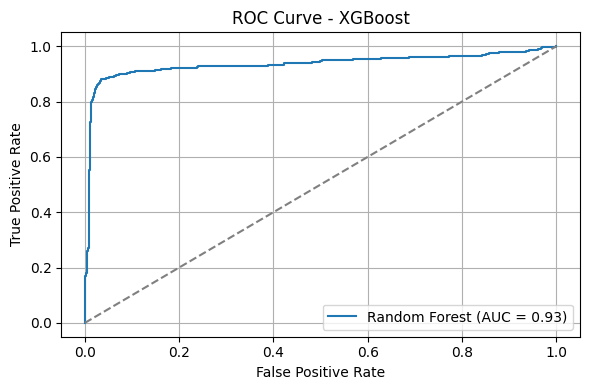

In [ ]:
# Compute ROC curve using true labels and predicted probabilities
fpr, tpr, _ = roc_curve(y, y_proba)
roc_auc = roc_auc_score(y, y_proba)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Kurva ROC untuk XGBoost pada test set naik tajam ke arah kiri atas grafik, menunjukkan bahwa model memiliki **True Positive Rate (Recall)** yang tinggi dan **False Positive Rate** yang rendah. Skor AUC sebesar 0.94 mengonfirmasi bahwa model mampu membedakan dengan sangat baik antara kandidat yang seharusnya disaring dan yang tidak, bahkan ketika diuji pada data baru.

**Kesimpulan Model**

Dengan skor F1 dan AUC yang sangat tinggi baik pada data pelatihan maupun pengujian, model XGBoost ini sangat cocok untuk digunakan dalam proses otomatisasi penyaringan kandidat. Model mampu:

- Mengurangi kebutuhan penyaringan manual hingga sekitar 94% akurasi, sehingga mempercepat proses perekrutan.
- Menurunkan risiko bias dalam pengambilan keputusan awal karena pemrosesan berbasis data yang konsisten.
- Memberikan hasil yang cukup akurat untuk langsung digunakan sebagai alat seleksi tahap awal.

Namun, karena masih terdapat sejumlah kecil false negatives, disarankan agar kandidat dengan skor prediksi mendekati ambang batas (borderline) tetap direview secara manual oleh tim HR. Strategi ini akan membantu memastikan bahwa tidak ada talenta potensial yang terlewat.

### Fairness Analysis

In [ ]:
# Load and preprocess dataset
df = pd.read_csv("recruitment_data.csv")
df = feature_engineering(df)

# Define features
num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany', 'InterviewScore', 'SkillScore', 'PersonalityScore']
nominal_features = ['Gender', 'RecruitmentStrategy']
ordinal_features = ['EducationLevel']
selected_features = num_features + nominal_features + ordinal_features

# Category Order
education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']

# Create AgeGroup
df['AgeGroup'] = pd.cut(df['Age'], bins=[-np.inf, 40, np.inf], labels=['Under_40', 'Over_40'])

# === Prepare data ===
X = df[selected_features]
y = df['HiringDecision']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ==== Preprocessor ====
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
    ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
])

# Best Parameter
best_params = {'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None, 'criterion': 'entropy'}

# Model
xgb = XGBClassifier(n_estimators=90, max_depth=12, learning_rate=0.08, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)

# Full pipeline including preprocessing and SMOTETomek
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('ros', RandomOverSampler(random_state=42)),
    ('classifier', xgb)
])

# Fit
pipeline.fit(X_train, y_train)

# Prediction
y_test_pred = pipeline.predict(X_test)

# Merge test data with predictions for fairness analysis
X_test_temp = X_test.copy()
X_test_temp['y_true'] = y_test
X_test_temp['y_pred'] = y_test_pred

# Add AgeGroup
X_test_temp['AgeGroup'] = pd.cut(X_test_temp['Age'], bins=[0, 20,31,100], labels=['<20','20-30','30+'])

# Fairness-sensitive features to evaluate
fairness_cols = ['Gender', 'AgeGroup', 'EducationLevel', 'RecruitmentStrategy']

# Initialize containers for metrics and gaps
fairness_all = {}  # To collect full group metrics for each feature
gap_summary = []   # To collect fairness gaps

# === Fairness Evaluation Loop ===
for col in fairness_cols:
    results = []

    # Get unique values for the current fairness column, dropping NaN
    unique_groups = X_test_temp[col].dropna().unique()

    for group in unique_groups:
        subset = X_test_temp[X_test_temp[col] == group]

        if len(subset) == 0:
            continue

        y_true = subset['y_true']
        y_pred = subset['y_pred']

        try:
            # Ensure consistent data types
            y_true = y_true.astype(int)
            y_pred = y_pred.astype(int)

            # Manual calculation (more reliable)
            tp = len(subset[(subset['y_true'] == 1) & (subset['y_pred'] == 1)])
            tn = len(subset[(subset['y_true'] == 0) & (subset['y_pred'] == 0)])
            fp = len(subset[(subset['y_true'] == 0) & (subset['y_pred'] == 1)])
            fn = len(subset[(subset['y_true'] == 1) & (subset['y_pred'] == 0)])

            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        except Exception as e:
            print(f"Error calculating metrics for {group}: {e}")
            recall, precision = np.nan, np.nan

        results.append({
            col: group,
            'Recall (TPR)': recall,
            'Precision': precision,
            'Support': len(subset)
        })

    fairness_df = pd.DataFrame(results).fillna(0)
    fairness_all[col] = fairness_df.set_index(col)[['Recall (TPR)', 'Precision']]

    print(f"== {col} ==")
    display(fairness_df)

    # Calculate gaps only if there are multiple groups and valid metrics
    if len(fairness_df) > 1 and not fairness_df[['Recall (TPR)', 'Precision']].isnull().all().all():
        recall_gap = fairness_df['Recall (TPR)'].max() - fairness_df['Recall (TPR)'].min()
        precision_gap = fairness_df['Precision'].max() - fairness_df['Precision'].min()
        gap_summary.append({'Feature': col, 'Recall Gap': recall_gap, 'Precision Gap': precision_gap})
        print(f"Recall Gap    : {recall_gap:.3f}")
        print(f"Precision Gap : {precision_gap:.3f}")
        print(f"Sample Size : {len(subset):.3f}")
    elif len(fairness_df) <= 1:
        print("Not enough groups to calculate gaps.")
    else:
        print("Gaps cannot be calculated due to missing values.")

== Gender ==


Gender  Recall (TPR)  Precision  Support
0    Male      0.775000   0.968750      144
1  Female      0.886792   0.959184      156

Recall Gap    : 0.112
Precision Gap : 0.010
Sample Size : 156.000
== AgeGroup ==


AgeGroup  Recall (TPR)  Precision  Support
0      30+      0.824561       0.94      189
1    20-30      0.878788       1.00       98
2      <20      0.666667       1.00       13

Recall Gap    : 0.212
Precision Gap : 0.060
Sample Size : 13.000
== EducationLevel ==


EducationLevel  Recall (TPR)  Precision  Support
0  Diploma/Bachelor      0.866667   1.000000      139
1     Post Graduate      0.727273   1.000000       28
2            Master      0.921053   0.972222       74
3       High School      0.642857   0.818182       59

Recall Gap    : 0.278
Precision Gap : 0.182
Sample Size : 59.000
== RecruitmentStrategy ==


RecruitmentStrategy  Recall (TPR)  Precision  Support
0  Online platform (LinkedIn, Job Portal)      0.526316   1.000000      150
1                      Walk-in or offline      0.571429   1.000000       56
2                       Headhunter/Agency      0.955224   0.955224       94

Recall Gap    : 0.429
Precision Gap : 0.045
Sample Size : 94.000


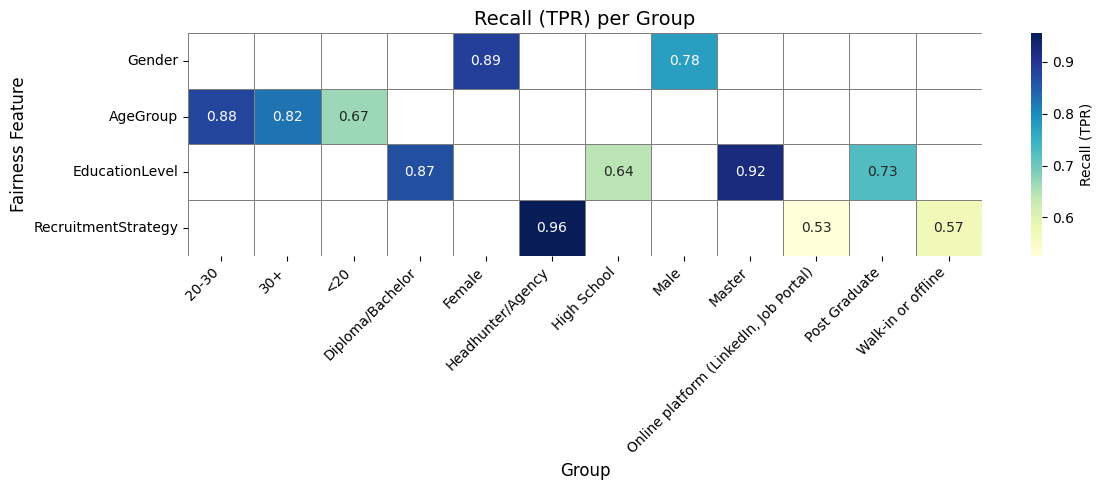

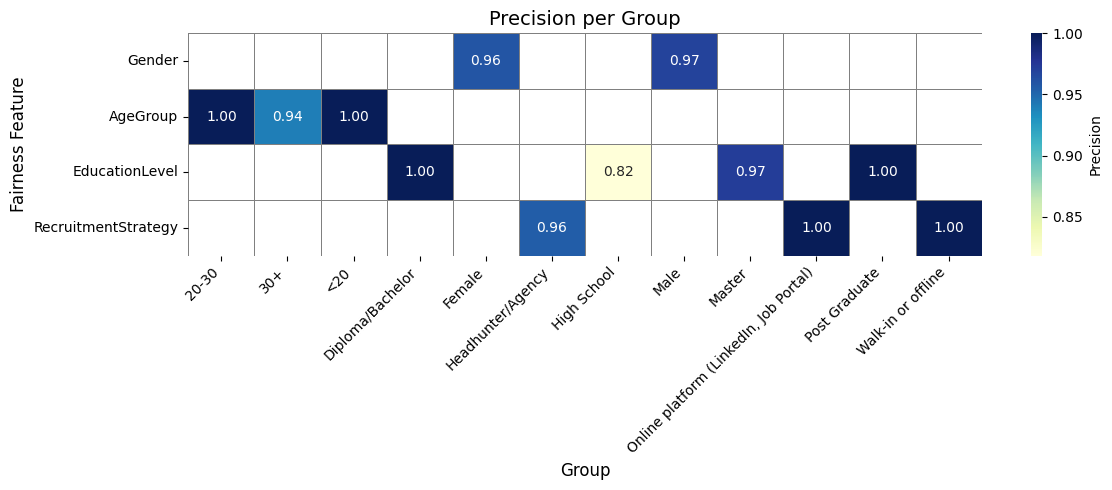

In [ ]:
# Loop through metrics
for metric in ['Recall (TPR)', 'Precision']:
    # Prepare DataFrame: fairness feature as rows, group as columns
    metric_df = pd.DataFrame({col: fairness_all[col][metric] for col in fairness_all})
    metric_df = metric_df.transpose()

    # Plot heatmap
    plt.figure(figsize=(12, 5))  # Wider and taller for clarity
    sns.heatmap(
        metric_df,
        annot=True,
        fmt=".2f",
        cmap="YlGnBu",                  # Consistent colormap
        linewidths=0.5,                # Adds gridlines
        linecolor='gray',
        annot_kws={"size": 10},        # Larger annotation text
        cbar_kws={'label': metric}     # Add label to colorbar
    )
    plt.title(f"{metric} per Group", fontsize=14)
    plt.xlabel("Group", fontsize=12)
    plt.ylabel("Fairness Feature", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

Hasil ini menunjukkan seberapa baik kinerja model kami untuk setiap subkelompok (misalnya, jenis kelamin, usia, pendidikan, strategi perekrutan).

- **Recall (True Positive Rate)**: Menunjukkan seberapa baik model mengidentifikasi kandidat yang benar-benar memenuhi syarat (Hired) dalam setiap kelompok.
- **Precision**: Menunjukkan berapa banyak kandidat yang diprediksi sebagai "Hired" yang benar-benar direkrut di setiap kelompok.

**Gender**
- Recall: Perempuan (0,89) > Laki-laki (0,78) → Artinya adalah model mengidentifikasi kandidat perempuan yang berkualifikasi lebih andal daripada kandidat laki-laki.
- Precision: Perempuan (0,96) < Laki-laki (0,97) → Prediksi untuk rekrutmen laki-laki lebih akurat dibandingkan perempuan.
- Wawasan Bisnis: Model tidak menunjukkan bias dalam mengidentifikasi dan memprediksi hasil rekrutmen. Hal ini dapat diterima jika sejalan dengan tujuan keberagaman.

**Age Group**
- Recall: 20–30 (0,88), 30+ (0,82), <20 (0,67) → Kandidat dewasa muda lebih diutamakan.
- Precision: 20–30 (1.00), 30+ (0,94), <20 (1.00): Kelompok usia 20–30 dan <20 adalah kelompok usia yang dianggap paling memiliki kecocokan tinggi dengan hasil perekrutan. Model ini sangat aman dalam memilih kandidat muda. Model hanya memprediksi "diterima" jika sangat yakin, dan selalu tepat. Namun, model ini juga melewatkan banyak kandidat muda yang memenuhi syarat (seperti yang ditunjukkan oleh rendahnya nilai Recall).
- Wawasan Bisnis: Model ini terlalu konservatif dalam memprediksi kandidat di bawah usia 20 tahun — hanya memutuskan mereka akan menerima kerja jika benar-benar yakin (Precision = 1.00), namun hanya berhasil mengumpulkan setengah dari kandidat muda yang sebenarnya layak diterima (Recall = 0.67). Akibatnya, banyak talenta muda yang berkualitas tidak terdeteksi oleh model, meskipun mereka mungkin cocok untuk posisi entry-level, magang, atau program pemula.
- Risiko bisnis:
Potensi kehilangan talenta muda berkualitas, yang sering kali lebih adaptif, antusias, dan bisa berkembang jangka panjang dalam perusahaan. Hal ini juga bisa menghambat inisiatif employer branding dan pengembangan pipeline talenta masa depan.
- Peluang perbaikan:
Model perlu ditingkatkan agar lebih inklusif terhadap kandidat muda dengan menambahkan fitur-fitur yang mencerminkan kesiapan kerja, seperti pengalaman organisasi, proyek mandiri, sertifikasi, atau portofolio.

**Educational Level**
- Recall: Master (0,92), Post Graduate (0,73), Diploma/Bachelor (0,87), HighSchool (0,64)
- Presisi: Post Graduate (1.00) > Diploma/Bachelor (1.00) > Master (0,97) > HighSchool (0,82)
- Wawasan Bisnis
 - Model ini lebih mengutamakan kandidat dengan gelar Master dalam Recall, tetapi Post Graduate memiliki Presisi yang lebih tinggi, yang berarti prediksi mereka lebih akurat.
 - Di sisi lain, lulusan HighSchool diabaikan — hal ini dapat membahayakan perekrutan inklusif jika posisi tersebut tidak menuntut gelar yang tinggi.

**Recruitment Strategy**
- Recall: Headhunter/Agensi (0,96), Walk-in (0,57), Platform Online (0,53)
- Precision: Online (1.00) ≈ Walk-in (1.00) > Headhunter/Agensi (0,96) >
- Wawasan Bisnis
  - Model memiliki bias kuat terhadap kandidat dari Headhunter/Agensi, dengan Recall tinggi (0,96) yang berarti hampir semua kandidat dari jalur ini yang benar-benar diterima dapat dikenali oleh model. Namun, Precision-nya tidak sempurna (0,96), artinya masih ada beberapa prediksi "false positive" — kandidat yang diprediksi akan diterima, tapi ternyata tidak.
  - Sebaliknya, kandidat dari Platform Online dan Walk-in memiliki Precision sempurna (1.00), yang berarti saat model memutuskan mereka akan diterima, prediksi tersebut selalu benar. Namun, Recall mereka sangat rendah (Online: 0,53; Walk-in: 0,57), yang artinya banyak kandidat berkualitas dari jalur ini tidak dikenali sama sekali oleh model.
- Implikasi Bisnis
  - Model terlalu mengandalkan jalur Headhunter, yang umumnya lebih mahal dan terbatas dalam cakupan. Hal ini dapat menciptakan ketergantungan yang tidak sehat terhadap satu saluran rekrutmen, dan berisiko menutup akses terhadap kandidat berkualitas dari jalur reguler.
  - Peluang besar yang terlewat dari Platform Online dan Walk-in, padahal mereka memiliki akurasi prediksi yang sangat tinggi saat dikenali.
  - Ini bisa menyebabkan biaya peluang tinggi, pipeline kandidat yang tidak optimal, dan ketidakefisienan dalam strategi perekrutan menyeluruh.

- Rekomendasi:
  - Tingkatkan Recall untuk jalur Platform Online dan Walk-in agar model lebih sensitif terhadap talenta dari saluran ini.
  - Lakukan audit fitur: pastikan atribut yang sering dimiliki kandidat dari jalur online atau walk-in (misalnya, keterampilan teknis, skor tes, atau pengalaman proyek) tidak diabaikan oleh model.
  - Pertimbangkan pendekatan fairness-aware untuk menyeimbangkan perlakuan antar saluran rekrutmen.

Feature  Recall Gap  Precision Gap
0               Gender    0.111792       0.009566
1             AgeGroup    0.212121       0.060000
2       EducationLevel    0.278195       0.181818
3  RecruitmentStrategy    0.428908       0.044776

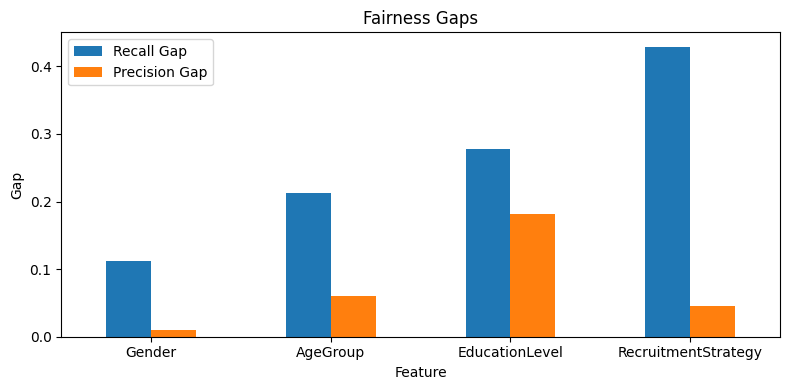

In [ ]:
gap_df = pd.DataFrame(gap_summary)
display(gap_df)

# Optional: plot the gaps too
gap_df.set_index('Feature').plot.bar(rot=0, figsize=(8,4), title="Fairness Gaps")
plt.ylabel("Gap")
plt.tight_layout()
plt.show()

Grafik ini membandingkan kesenjangan kinerja (max vs min) dalam setiap fitur:

| Feature                 | Recall Gap | Precision Gap | Business Risk                                                                                                       |
| ----------------------- | ---------- | ------------- | ------------------------------------------------------------------------------------------------------------------- |
| **RecruitmentStrategy** | **0.43**   | 0.04          | 🔴 **Ketimpangan terbesar** — Model sangat mengutamakan kandidat dari jalur Headhunter, dengan Recall jauh lebih tinggi dibanding jalur Online atau Walk-in. Meskipun Precision cukup merata, model berpotensi besar mengabaikan kandidat berkualitas dari jalur yang lebih hemat biaya seperti job portal atau walk-in, sehingga menyebabkan biaya peluang tinggi dan inefisiensi pipeline. |
| **EducationLevel**      | 0.28       | 0.18          | 🟠 Bias terhadap pemegang gelar tinggi. Model memberikan Recall dan Precision jauh lebih baik kepada kandidat dengan gelar tinggi (misal: Master, Postgraduate), sementara kandidat dari latar pendidikan rendah (misal: SMA) kurang terwakili, meskipun mungkin cocok untuk peran junior. Hal ini membatasi keberagaman dan inklusi, serta bisa bertentangan dengan strategi rekrutmen entry-level atau vocational.                                      |
| **AgeGroup**            | 0.21       | 0.06          | 🟠 Recall rendah pada kelompok ini menunjukkan banyak talenta muda yang terlewat, meskipun memiliki Precision tinggi saat dikenali. Ini menghambat program pengembangan talenta muda, magang, atau rekrutmen fresh graduate.                                                                         |
| **Gender**              | 0.11       | 0.009          | 🟢 Ketidakseimbangan kecil. Meskipun ada sedikit gap dalam Recall, Precision antar gender hampir setara. Risiko bias gender tergolong rendah saat ini, namun tetap perlu dimonitor untuk menjaga fairness jangka panjang.                                                                                               |


### Model Explainability

#### Glbal Feature Importance

In [ ]:
# Setelah pipeline sudah fit
pipeline.fit(X, y)

# Get full list of feature names in the right order
ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']
oe = pipeline.named_steps['preprocessor'].named_transformers_['oe']

# Combine names from each part
num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany', 'InterviewScore', 'SkillScore', 'PersonalityScore']
cat_features = ohe.get_feature_names_out(['Gender', 'RecruitmentStrategy'])
ord_features = ['EducationLevel']  # ordinal encoder does not change names

# Final order of features fed into the model
feature_names = np.concatenate([num_features, cat_features, ord_features])

# Now match these with importances
importances = pipeline.named_steps['classifier'].feature_importances_

# Buat DataFrame dan visualisasikan
fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)
fi_df.head(10)

feature  importance
9               RecruitmentStrategy_Headhunter/Agency    0.728268
12                                     EducationLevel    0.066510
6                                    PersonalityScore    0.035477
4                                      InterviewScore    0.035302
1                                     ExperienceYears    0.033543
5                                          SkillScore    0.025932
0                                                 Age    0.014798
7                                       Gender_Female    0.014363
10  RecruitmentStrategy_Online platform (LinkedIn,...    0.013833
2                                   PreviousCompanies    0.013798

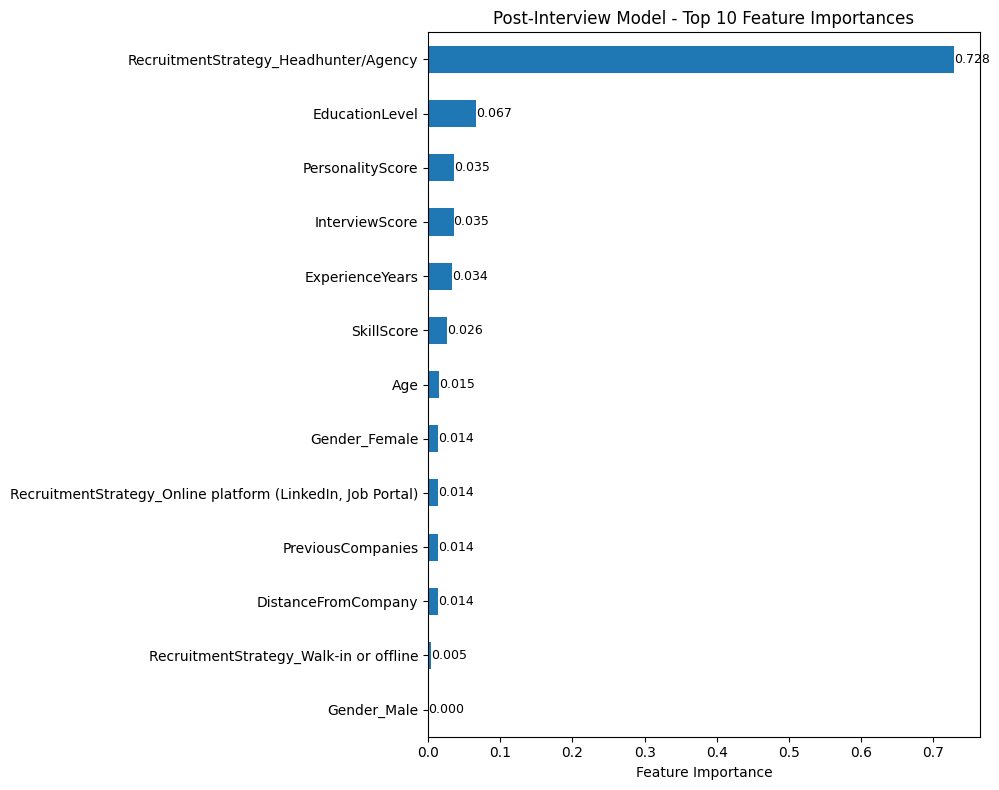

In [ ]:
# Visualisasi
plot_feature_importance(importances, feature_names, "Post-Interview Model - Top 10 Feature Importances")

**Wawasan Bisnis: Optimalisasi Strategi Rekrutmen**

Berdasarkan hasil feature importance untuk Model 2, terlihat bahwa fitur **RecruitmentStrategy\_Headhunter/Agency** memberikan kontribusi yang sangat dominan dalam memprediksi keputusan perekrutan. Nilainya jauh melampaui fitur-fitur lainnya, dengan lebih dari 70% bobot pentingnya, yang menunjukkan bahwa kandidat yang direkrut melalui jalur headhunter atau agency memiliki peluang sangat tinggi untuk diterima. Ini merupakan sinyal kuat bagi perusahaan untuk lebih serius mengembangkan dan memprioritaskan kolaborasi dengan agency rekrutmen profesional karena strategi ini terbukti paling efektif dalam menghasilkan kandidat berkualitas.

Di posisi berikutnya, meskipun dengan kontribusi jauh lebih kecil, terdapat fitur **EducationLevel**, **InterviewScore**, dan **PersonalityScore**. Ini menunjukkan bahwa latar belakang pendidikan formal, performa saat wawancara, dan aspek kepribadian tetap berperan dalam proses seleksi, namun pengaruhnya tidak sekuat jalur rekrutmen. Oleh karena itu, meskipun penting, ketiga aspek ini sebaiknya dilihat sebagai faktor penyaring tambahan atau pelengkap untuk memastikan kesesuaian budaya dan kompetensi.

Fitur seperti **ExperienceYears**, **SkillScore**, dan **Age** juga memiliki peran, meskipun kecil. Hal ini bisa berarti bahwa model lebih mengandalkan faktor-faktor soft (seperti strategi rekrutmen dan kepribadian) dibandingkan hard skills atau pengalaman kerja murni. Perusahaan perlu mengevaluasi kembali apakah ekspektasi terhadap pengalaman dan keterampilan teknis terlalu rendah dalam sistem ini, atau memang kebutuhan peran saat ini lebih menekankan pada kecocokan kepribadian dan jalur akuisisi kandidat.

Menariknya, fitur **DistanceFromCompany**, **RecruitmentStrategy\_Online platform**, dan **Gender\_Female** berada di posisi paling bawah dan memberikan kontribusi nyaris nol. Ini menandakan bahwa faktor lokasi geografis, gender, maupun strategi rekrutmen berbasis platform digital seperti LinkedIn tidak menjadi pembeda utama dalam prediksi keberhasilan kandidat. Model ini juga menunjukkan kecenderungan netral terhadap gender, yang merupakan sinyal positif bagi inklusivitas dan fairness dalam proses seleksi.

Secara keseluruhan, hasil ini menunjukkan bahwa **jalur rekrutmen menjadi variabel kunci yang sangat menentukan dalam model prediktif**, dan perusahaan sebaiknya menyusun strategi sourcing kandidat berdasarkan fakta ini. Namun, untuk menjaga keseimbangan dan akurasi jangka panjang, akan lebih bijak jika perusahaan terus menggabungkan pendekatan ini dengan penilaian holistik terhadap kepribadian, wawancara, dan kompetensi teknis kandidat. Model ini ideal untuk digunakan sebagai sistem pendukung keputusan (decision support system) dalam tahap awal penyaringan rekrutmen, bukan sebagai alat tunggal penentu akhir.

In [ ]:
# Load and preprocess dataset
df = pd.read_csv("recruitment_data.csv")
df = feature_engineering(df)

# Define features
num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany', 'InterviewScore', 'SkillScore', 'PersonalityScore']
nominal_features = ['Gender', 'RecruitmentStrategy']
ordinal_features = ['EducationLevel']
selected_features = num_features + nominal_features + ordinal_features

# Category Order
education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']

# Create AgeGroup
df['AgeGroup'] = pd.cut(df['Age'], bins=[-np.inf, 40, np.inf], labels=['Under_40', 'Over_40'])

# === Prepare data ===
X = df[selected_features]
y = df['HiringDecision']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ==== Preprocessor ====
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
    ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
])

# Best Parameter
best_params = {'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None, 'criterion': 'entropy'}

# Fit preprocessor and transform data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Get feature names after preprocessing
feature_names = get_feature_names(preprocessor, selected_features)
print(f"Feature names after preprocessing: {feature_names}")
print(f"Number of features: {len(feature_names)}")

# Train classifier for SHAP (without SMOTE)
xgb_shap = XGBClassifier(n_estimators=90, max_depth=12, learning_rate=0.08, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
xgb_shap.fit(X_train_transformed, y_train)

# 4. Create SHAP explainer
explainer = shap.TreeExplainer(xgb_shap)
shap_values = explainer.shap_values(X_test_transformed)

# 5. Handle binary classification SHAP values
print("Original SHAP values shape:", np.array(shap_values).shape)
print("Expected value:", explainer.expected_value)
print("Type of shap_values:", type(shap_values))

# Debug: Check the structure of shap_values
if isinstance(shap_values, list):
    print(f"shap_values is a list with {len(shap_values)} elements")
    for i, sv in enumerate(shap_values):
        print(f"  Element {i} shape: {np.array(sv).shape}")
elif isinstance(shap_values, np.ndarray):
    print(f"shap_values is numpy array with shape: {shap_values.shape}")

# For TreeExplainer with binary classification, shap_values is typically a numpy array
# with shape (n_samples, n_features, n_classes)
if isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    # Select SHAP values for positive class (class 1) - last dimension
    shap_values_positive = shap_values[:, :, 1]  # Shape: (n_samples, n_features)
    expected_value_positive = explainer.expected_value[1]
    print(f"Using SHAP values for positive class (shortlisted)")
elif isinstance(shap_values, list) and len(shap_values) == 2:
    # Alternative format: list of arrays for each class
    shap_values_positive = shap_values[1]
    expected_value_positive = explainer.expected_value[1]
    print(f"Using SHAP values for positive class (shortlisted) - list format")
else:
    # Fallback - use as is
    shap_values_positive = shap_values
    expected_value_positive = explainer.expected_value
    print("Using SHAP values as-is (unexpected format)")

print(f"SHAP values shape for positive class: {shap_values_positive.shape}")
print(f"Expected value for positive class: {expected_value_positive}")

# 6. Create DataFrame for easier analysis
shap_df = pd.DataFrame(shap_values_positive, columns=feature_names)
print(f"SHAP DataFrame shape: {shap_df.shape}")

Feature names after preprocessing: ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany', 'InterviewScore', 'SkillScore', 'PersonalityScore', 'Gender_Female', 'Gender_Male', 'RecruitmentStrategy_Headhunter/Agency', 'RecruitmentStrategy_Online platform (LinkedIn, Job Portal)', 'RecruitmentStrategy_Walk-in or offline', 'EducationLevel']
Number of features: 13
Original SHAP values shape: (300, 13)
Expected value: -0.81932884
Type of shap_values: <class 'numpy.ndarray'>
shap_values is numpy array with shape: (300, 13)
Using SHAP values as-is (unexpected format)
SHAP values shape for positive class: (300, 13)
Expected value for positive class: -0.8193288445472717
SHAP DataFrame shape: (300, 13)



Generating SHAP Bar Plot...


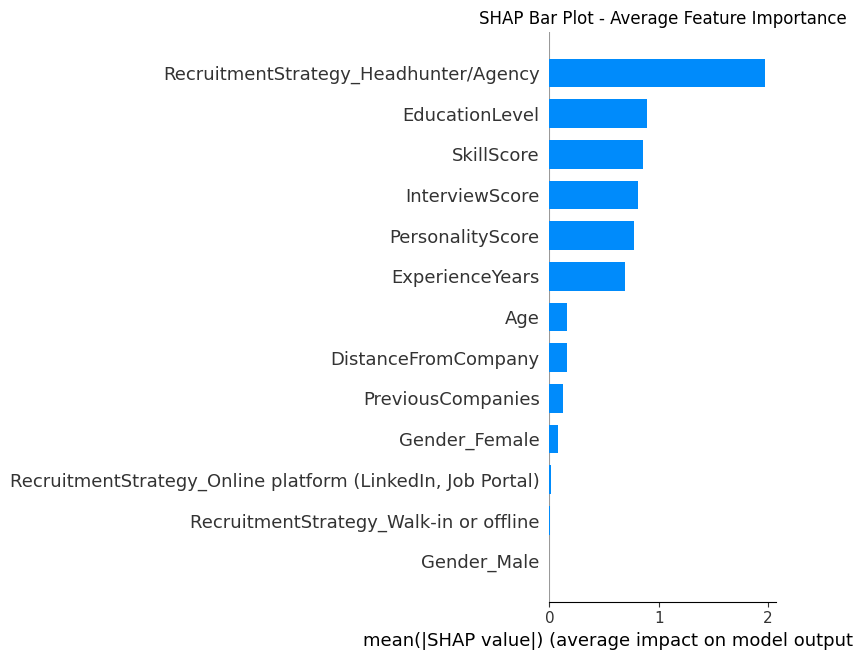

In [ ]:
# Bar Plot - Average Feature Importance
print("\nGenerating SHAP Bar Plot...")
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_positive, X_test_transformed,
                  feature_names=feature_names, plot_type="bar", show=False)
plt.title("SHAP Bar Plot - Average Feature Importance")
plt.tight_layout()
plt.show()

In [ ]:
# Feature Importance DataFrame
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Mean_SHAP_Value': np.abs(shap_values_positive).mean(axis=0)
}).sort_values('Mean_SHAP_Value', ascending=False)

print("\nTop 10 Most Important Features (by mean absolute SHAP value):")
print(feature_importance.head(10))


Top 10 Most Important Features (by mean absolute SHAP value):
                                  Feature  Mean_SHAP_Value
9   RecruitmentStrategy_Headhunter/Agency         1.975753
12                         EducationLevel         0.894396
5                              SkillScore         0.859525
4                          InterviewScore         0.808709
6                        PersonalityScore         0.774436
1                         ExperienceYears         0.692608
0                                     Age         0.163673
3                     DistanceFromCompany         0.159983
2                       PreviousCompanies         0.122475
7                           Gender_Female         0.075390


#### Direction of Impact


Generating SHAP Summary Plot...


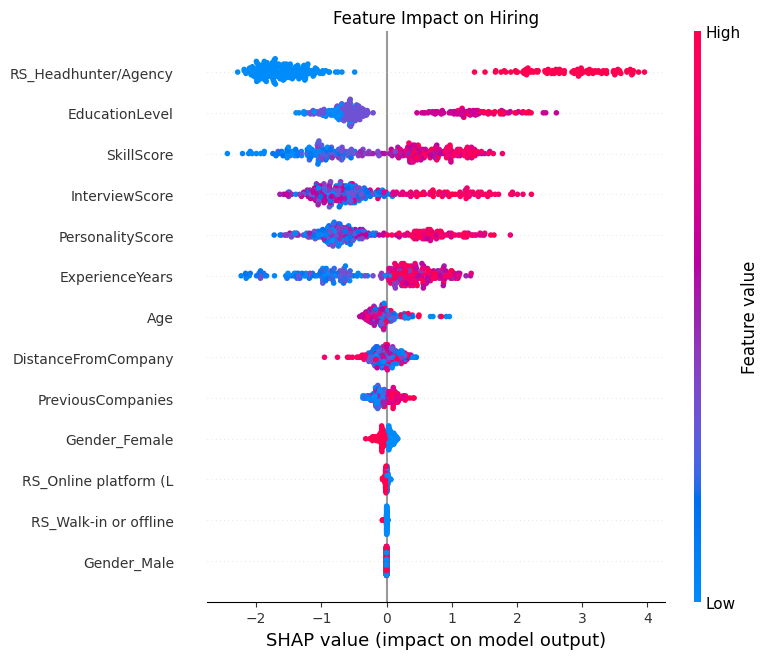

In [ ]:
# Set up matplotlib for better plots
plt.style.use('default')
# shap.initjs()  # Initialize SHAP JavaScript visualizations

very_short_names = []
for name in feature_names:
    if 'RecruitmentStrategy_' in name:
        very_short_names.append('RS_' + name.split('_')[1][:18])
    else:
        very_short_names.append(name[:25])

# 1. Summary Plot (most important)
print("\nGenerating SHAP Summary Plot...")
plt.figure(figsize=(14, 12))
shap.summary_plot(shap_values_positive, X_test_transformed,
                  feature_names=very_short_names, show=False)

# Reduce font size of feature names
plt.gca().tick_params(labelsize=10)

plt.title("Feature Impact on Hiring", fontsize=12)
plt.tight_layout()
plt.show()

**Wawasan Bisnis Utama**

1. **Headhunter/Agency: Polarisasi Ekstrem**

  **RS_Headhunter/Agency** menunjukkan pola paling dramatis:
- **Kandidat "premium"**: Cluster merah muda di kanan (+2 hingga +4) menunjukkan beberapa kandidat mendapat boost luar biasa
- **Kandidat "ditolak"**: Cluster biru di kiri (-2) menunjukkan penolakan keras untuk kandidat tertentu
- **Implikasi bisnis**: Model menciptakan sistem "all-or-nothing" - kandidat headhunter/agency either sangat disukai atau sangat ditolak
- **Rekomendasi**: Audit kualitas partner headhunter/agency Anda

2. **Assessment Scores: Game Changer Baru**

  **SkillScore, InterviewScore, PersonalityScore** menunjukkan pola menarik:
- **Rentang luas**: Dari -2 hingga +4, menunjukkan variabilitas tinggi dalam dampak
- **Overlap signifikan**: Ketiga skor ini saling berinteraksi dalam keputusan
- **Implikasi bisnis**: Assessment yang komprehensif menjadi faktor penentu utama
- **Strategi**: Investasi dalam sistem assessment yang robust akan memberikan ROI tinggi

3. **Experience: Masih Bias Terhadap Senior**

  **ExperienceYears** mempertahankan pola bias:
- **Penalti junior**: Cluster biru di kiri (-2 hingga -1) untuk kandidat kurang berpengalaman
- **Reward senior**: Cluster merah muda di kanan (+1 hingga +2) untuk kandidat berpengalaman
- **Implikasi bisnis**: Model masih diskriminatif terhadap fresh graduate dan junior talent

4. **Education: Moderate but Consistent Impact**

  **EducationLevel** menunjukkan pola lebih terstruktur:
- **Konsisten negatif-positif**: Pendidikan rendah (biru kiri) vs tinggi (merah muda kanan)
- **Dampak moderat**: Tidak se-ekstrem headhunter/agency atau assessment scores
- **Implikasi bisnis**: Pendidikan tetap relevan tapi tidak dominan

5. **Demographics: Excellent Fairness**
  
  **Gender_Female dan Gender_Male** serta **recruitment channels lain**:
- **Hampir nol impact**: Clustering sangat ketat di sekitar 0
- **Implikasi compliance**: Model Anda sangat baik dalam menghindari bias demografis
- **Kelebihan**: Memenuhi standar equal opportunity employment

**Strategi Bisnis Berdasarkan Temuan:**

**Prioritas Tinggi:**
1. **Audit headhunter/agency partnerships**: Identifikasi mana yang konsisten menghasilkan kandidat berkualitas
2. **Standardisasi assessment**: Skill, interview, dan personality scores adalah diferensiator utama
3. **Review bias pengalaman**: Pertimbangkan program fast-track untuk junior talent dengan assessment scores tinggi

**Prioritas Menengah:**
1. **Balanced scoring system**: Kombinasikan assessment scores dengan experience untuk keputusan yang lebih nuanced
2. **Cost-benefit analysis**: Kandidat dengan assessment tinggi tapi experience rendah mungkin lebih cost-effective

**Monitoring Berkelanjutan:**
1. **Fairness metrics**: Pertahankan keunggulan dalam demographic fairness
2. **Assessment reliability**: Pastikan ketiga assessment scores memberikan prediksi yang akurat

**Kesimpulan**: Model Anda telah berevolusi dari bias pengalaman sederhana menjadi sistem yang lebih sophisticated yang mengandalkan assessment komprehensif, sambil mempertahankan excellent demographic fairness.

#### Explain One Prediction Example

Generating Waterfall Plot with very short names...


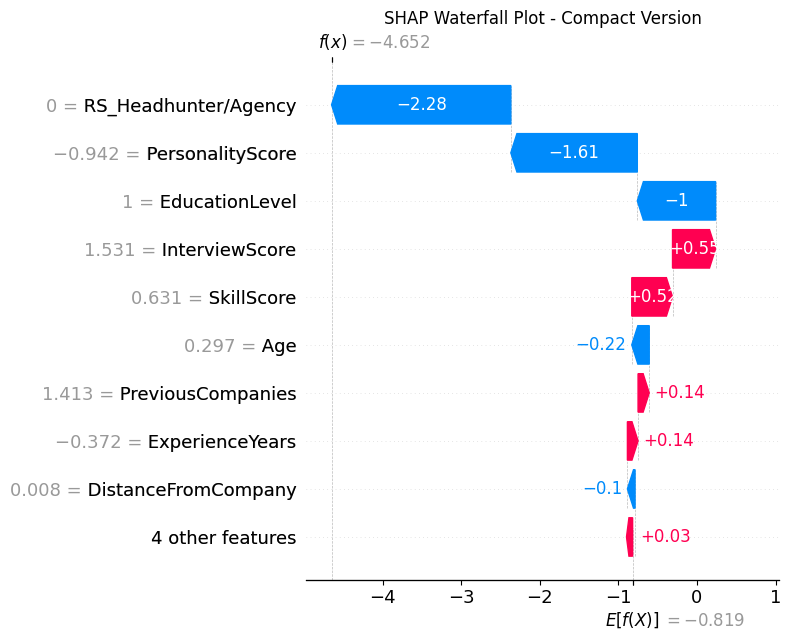

In [ ]:
print("Generating Waterfall Plot with very short names...")
very_short_names = []
for name in feature_names:
    if 'RecruitmentStrategy_' in name:
        very_short_names.append('RS_' + name.split('_')[1][:18])
    elif 'Gender_' in name:
        very_short_names.append('G_' + name.split('_')[1])
    else:
        very_short_names.append(name[:25])

plt.figure(figsize=(10, 8))
shap.waterfall_plot(
    shap.Explanation(values=shap_values_positive[0],
                    base_values=expected_value_positive,
                    data=X_test_transformed[0],
                    feature_names=very_short_names),
    show=False
)

plt.title("SHAP Waterfall Plot - Compact Version", fontsize=12)
plt.tight_layout()
plt.show()

#### Explore Feature Relationships


Generating dependence plots for top 3 features: ['RecruitmentStrategy_Headhunter/Agency', 'EducationLevel', 'SkillScore']


<Figure size 1200x1000 with 0 Axes>

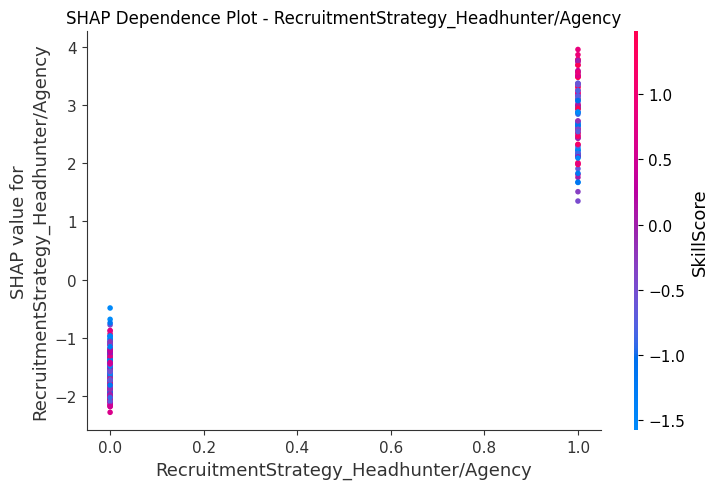

<Figure size 1200x1000 with 0 Axes>

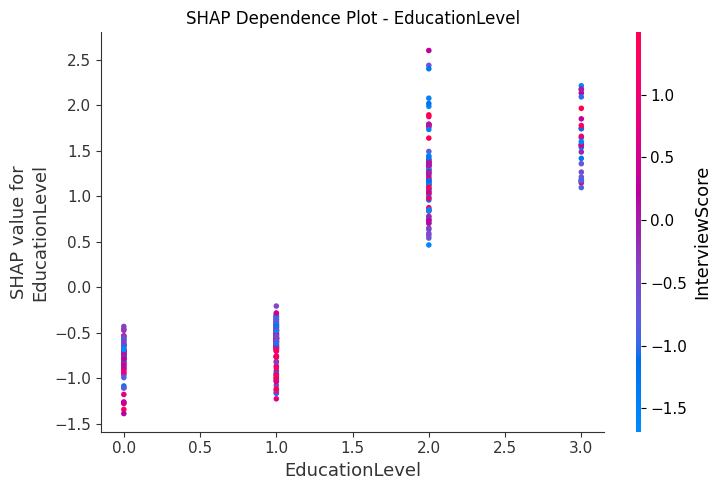

<Figure size 1200x1000 with 0 Axes>

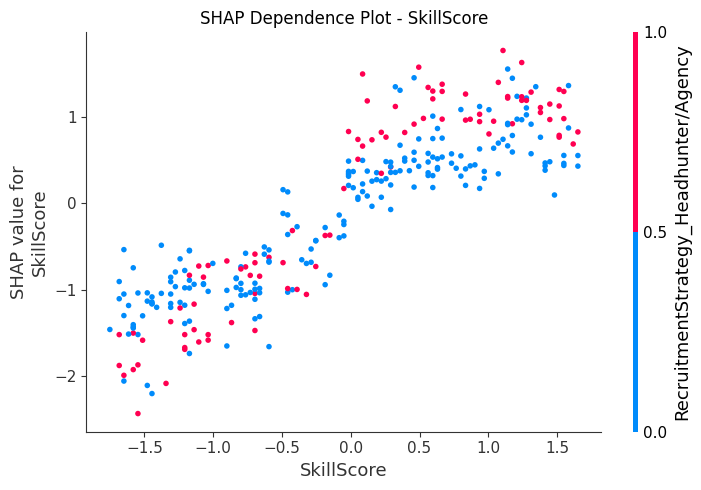

In [ ]:
# 5. Dependence plots for top 3 features
top_3_features = feature_importance.head(3)['Feature'].tolist()
print(f"\nGenerating dependence plots for top 3 features: {top_3_features}")

for i, feature in enumerate(top_3_features):
    plt.figure(figsize=(12, 10))
    feature_idx = feature_names.index(feature)
    shap.dependence_plot(feature_idx, shap_values_positive, X_test_transformed,
                        feature_names=feature_names, show=False)
    plt.title(f"SHAP Dependence Plot - {feature}")
    plt.tight_layout()
    plt.show()

#### Analysis by groups (similar to fairness analysis)


SHAP ANALYSIS BY GROUPS

--- SHAP Analysis for Gender ---
          mean     std  count
Gender                       
Female -0.7943  3.4884    156
Male   -1.2305  3.1361    144


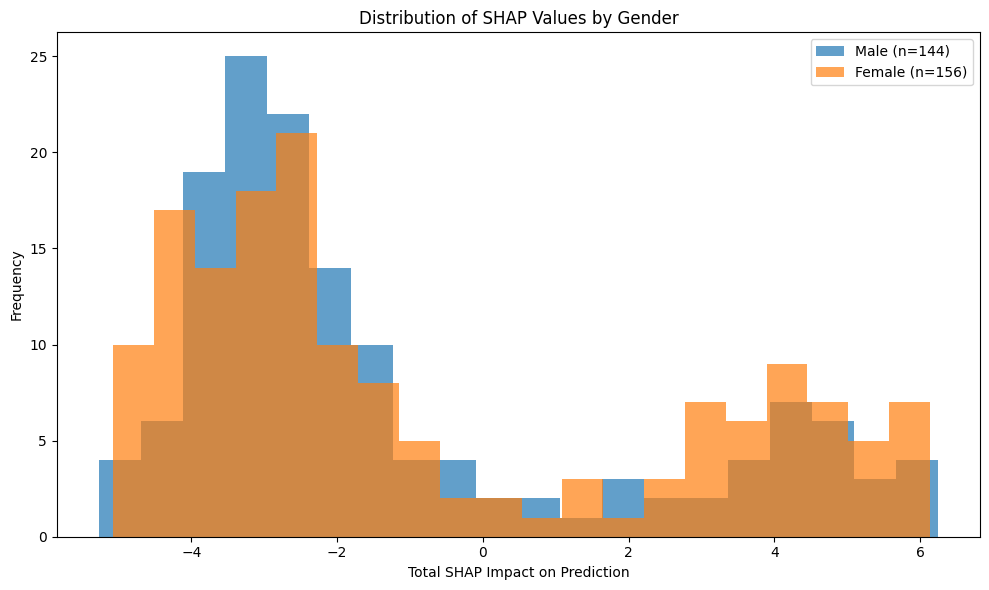


--- SHAP Analysis for RecruitmentStrategy ---
                                          mean     std  count
RecruitmentStrategy                                          
Headhunter/Agency                       2.5340  2.9078     94
Online platform (LinkedIn, Job Portal) -2.5902  1.9360    150
Walk-in or offline                     -2.6926  2.1249     56


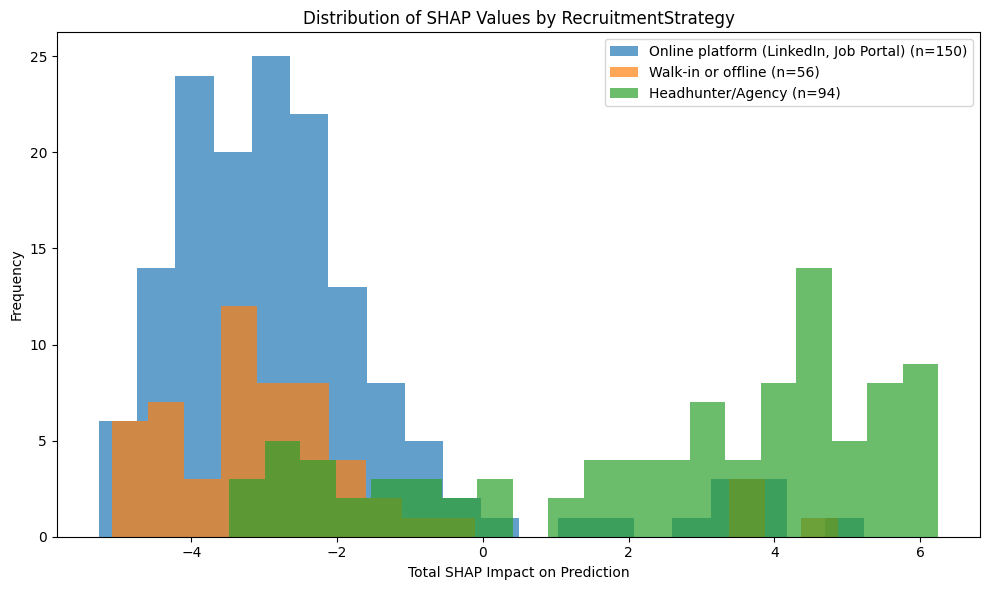


--- SHAP Analysis for EducationLevel ---
                    mean     std  count
EducationLevel                         
Diploma/Bachelor -1.6258  3.0687    139
High School      -2.0160  2.8187     59
Master            0.7559  3.6087     74
Post Graduate    -0.4331  3.0026     28


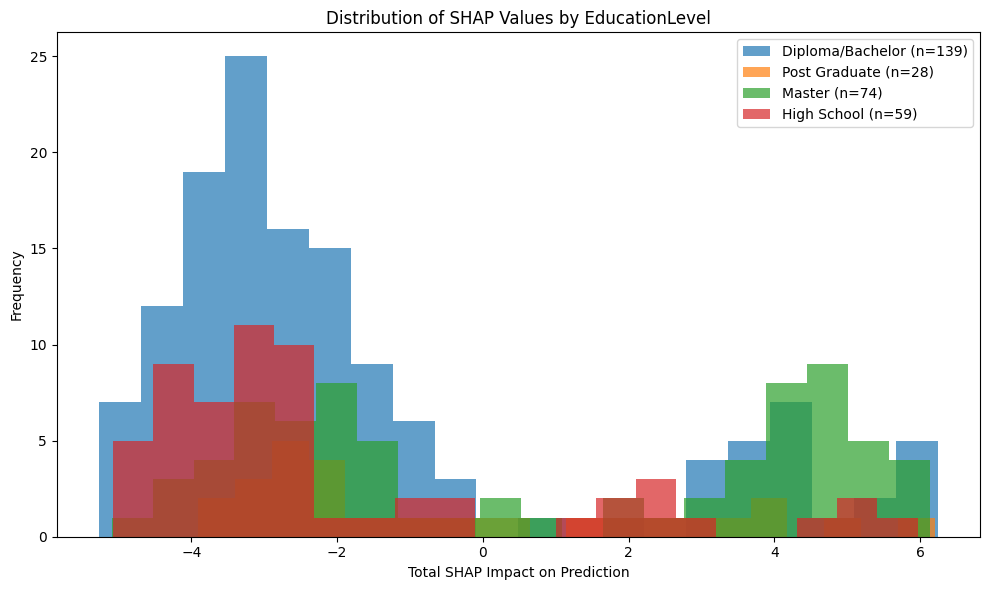


SHAP analysis completed!
Remember: Positive SHAP values increase the probability of being Hired
Negative SHAP values decrease the probability of being Hired


In [ ]:
# Analysis by groups (similar to your fairness analysis)
print("\n" + "="*50)
print("SHAP ANALYSIS BY GROUPS")
print("="*50)

# Add original categorical features back for grouping
X_test_with_groups = X_test.copy()
X_test_with_groups['shap_prediction_impact'] = shap_values_positive.sum(axis=1)

# Analyze SHAP values by groups
fairness_cols = ['Gender', 'RecruitmentStrategy', 'EducationLevel']

for col in fairness_cols:
    print(f"\n--- SHAP Analysis for {col} ---")
    group_analysis = X_test_with_groups.groupby(col)['shap_prediction_impact'].agg([
        'mean', 'std', 'count'
    ]).round(4)
    print(group_analysis)

    # Plot SHAP values by group
    plt.figure(figsize=(10, 6))
    for group in X_test_with_groups[col].unique():
        group_shap = X_test_with_groups[X_test_with_groups[col] == group]['shap_prediction_impact']
        plt.hist(group_shap, alpha=0.7, label=f"{group} (n={len(group_shap)})", bins=20)

    plt.xlabel('Total SHAP Impact on Prediction')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of SHAP Values by {col}')
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\nSHAP analysis completed!")
print(f"Remember: Positive SHAP values increase the probability of being Hired")
print(f"Negative SHAP values decrease the probability of being Hired")

### Save Model

In [ ]:
# === Load and process data ===
df = pd.read_csv("recruitment_data.csv")
df = feature_engineering(df)

num_features = ['Age', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany', 'InterviewScore', 'SkillScore', 'PersonalityScore']
nominal_features = ['Gender', 'RecruitmentStrategy']
ordinal_features = ['EducationLevel']
selected_features = num_features + nominal_features + ordinal_features

# Category Order
education_order = ['High School', 'Diploma/Bachelor', 'Master', 'Post Graduate']

# ==== Features & Target ====
X = df[selected_features]
y = df['HiringDecision']

# ==== Preprocessor ====
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),
    ('oe', OrdinalEncoder(categories=[education_order]), ordinal_features)
])

xgb = XGBClassifier(n_estimators=90, max_depth=12, learning_rate=0.08, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)

# Full pipeline including preprocessing and SMOTETomek
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('ros', RandomOverSampler(random_state=42)),
    ('classifier', xgb)
])

# Evaluate with Cross-Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validated predictions
y_proba = cross_val_predict(pipeline, X, y, cv=cv, method='predict_proba')[:, 1]

# Find the best threshold
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []
precisions = []
recalls = []

for t in thresholds:
    y_pred_thresh = (y_proba >= t).astype(int)
    f1_scores.append(f1_score(y, y_pred_thresh))
    precisions.append(precision_score(y, y_pred_thresh))
    recalls.append(recall_score(y, y_pred_thresh))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

# Fit pipeline to full data
pipeline.fit(X, y)

# === Save pipeline and threshold ===
model_bundle = {
    'pipeline': pipeline,
    'threshold': best_threshold
}
joblib.dump(model_bundle, 'hiring_model.pkl')

['hiring_modelpkl']